# Analyse Unified dataset

In [1]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,scanpy,requests,topicpy -a Filippo_Valle -g -r -b -w

2022-10-19 12:13:25.401041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 12:13:25.883926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 12:13:25.883945: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-19 12:13:25.933519: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 12:13:27.200589: W tensorflow/stream_executor/platform/de

Author: Filippo_Valle

Last updated: Wed Oct 19 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.5.0

pandas  : 1.1.5
numpy   : 1.22.4
scanpy  : 1.9.1
requests: 2.28.1
topicpy : 0.2.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.19.0-21-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Git hash: 6af288ff4fa34a7f9f04237fa48bed0dbc8ec340

Git repo: git@github.com:fvalle1/topics.git

Git branch: HEAD

Watermark: 2.3.1



In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import requests
import json
import os, sys

## Download data

Please download data from [https://doi.org/10.6084/m9.figshare.5330593](https://doi.org/10.6084/m9.figshare.5330593) and save all the files in a directory called *data*

In [4]:
#path/to/files/downloaded/
working_dir = f"{os.getcwd()}"
os.chdir(working_dir)

In [ ]:
files = filter(lambda f: "fpkm" in f, os.listdir("data"))

We download files metadate from [GTEx project](gtexportal.org)

In [ ]:
df_gtex=pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t', index_col=0)

We then download metadata for TCGA files using [GDC API](https://docs.gdc.cancer.gov/API/Users_Guide/Getting_Started/)

In [ ]:
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "cases.project.program.name",
            "value": ["TCGA"]
            }
        }
        
    ]
}
params = {
    "filters": json.dumps(filters),
    "fields": "primary_site,disease_type,submitter_id,project.project_id",
    "format": "TSV",
    "size": "10000000"
    }
response = requests.get("https://api.gdc.cancer.gov/cases", headers = {"Content-Type": "application/json"}, params = params)
with open("files.txt","w") as file:
    file.write(response.content.decode("utf-8"))
df_tcga = pd.read_csv("files.txt", sep='\t').set_index("submitter_id")

We create an empty dataframe to fulfill with data

In [ ]:
df=pd.DataFrame()

In [ ]:
for file in files:
    df = df.append(pd.read_csv("data/%s"%file, sep='\t', index_col=0).drop('Entrez_Gene_Id',1).transpose(), sort=True)
df = df.transpose()
df = df.dropna(how='any', axis=0) # drop genes not always determined

We create a file of metadata

In [ ]:
df_files = pd.DataFrame(index=df.columns)

import our helper functions

In [ ]:
from unified import get_source, get_status

def get_site(file):
    '''
    Returns GTEX or TCGA primary site
    '''
    if ("df_gtex" not in globals().keys()) or ("df_tcga" not in globals().keys()):
        raise NotImplementedError("Please define datasets with gtex and tcga metadata")
    if 'GTEX' in file:
        return df_gtex.at[file, 'SMTS']
    if 'TCGA' in file:
        return df_tcga.at[file[:12],'primary_site']

In [ ]:
df_files.insert(0, 'primary_site', [get_site(file) for file in df.columns])
df_files.insert(1, 'dataset', [get_source(file) for file in df.columns])
df_files.insert(1, 'status', [get_status(file) for file in df.columns])
df_files["dataset_status"]=df_files["dataset"]+"_"+df_files["status"]
df_files.groupby(["dataset","status"]).count()

Save the DataFrame just created

In [ ]:
df.to_csv("mainTable.csv", index=True, header=True)
df_files.to_csv("files.dat", index=True, header=True)

## Split / shuffle and select

In [ ]:
df = pd.read_csv("mainTable.csv", index_col=0)
df_files = pd.read_csv("files.dat", index_col=0)
df.head(2)

Group together same site with different names

In [ ]:
df_files.replace('Uterus, NOS', 'Uterus', inplace=True)
df_files.replace('Bronchus and lung', 'Lung', inplace=True)
df_files.replace('Liver and intrahepatic bile ducts', 'Liver', inplace=True)
df_files.replace('Prostate gland', 'Prostate', inplace=True)
df_files.replace('Thyroid gland', 'Thyroid', inplace=True)
df_files.replace('Base of Tongue', 'Salivary Gland', inplace=True)
df_files.replace('Bones, joints and articular cartilage of other and unspecified sites', 'Salivary Gland', inplace=True)
df_files.replace('Floor of mouth', 'Salivary Gland', inplace=True)
df_files.replace('Gum', 'Salivary Gland', inplace=True)
df_files.replace('Hypopharynx', 'Salivary Gland', inplace=True)
df_files.replace('Larynx', 'Salivary Gland', inplace=True)
df_files.replace('Lip', 'Salivary Gland', inplace=True)
df_files.replace('Oropharynx', 'Salivary Gland', inplace=True)
df_files.replace('Other and ill-defined sites in lip, oral cavity and pharynx', 'Salivary Gland', inplace=True)
df_files.replace('Other and unspecified parts of mouth', 'Salivary Gland', inplace=True)
df_files["tissue_hd"]=df_files["primary_site"]+"_"+df_files["dataset"]
df_files['primary_site'].unique()

In [ ]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5903355/
sites_with_enough_statistics = ['Breast', 'Colon', 'Liver', 'Esophagus', 'Prostate', 'Stomach', 'Lung', 'Uterus']

We uniformly sample some samples from the chosen tissues

In [ ]:
rs = np.random.RandomState(seed=42)
samples = pd.DataFrame(columns=df_files.columns)
for site in sites_with_enough_statistics:
    samples = samples.append(df_files[(df_files['primary_site']==site) & (df_files['dataset']=='tcga')].sample(50, random_state=rs))
    samples = samples.append(df_files[(df_files['primary_site']==site) & (df_files['dataset']=='gtex')].sample(50, random_state=rs))

Just a check

In [ ]:
samples.groupby('primary_site').count()

In [ ]:
samples.groupby('dataset').count()

### Split into train and test set

In [ ]:
df[df.columns[~df.columns.isin(samples.index) & df.columns.isin(df_files[df_files["primary_site"].isin(sites_with_enough_statistics)].index)]].to_csv("mainTable_test.csv", index=True, header=True)

In [ ]:
df[df.columns[df.columns.isin(samples.index)]].to_csv("mainTable_train.csv", index=True, header=True)

In [ ]:
df_files["tissue_hd"].unique()

In [ ]:
df_files.to_csv("files.dat", index=True, header=True)

# Filtering Highly Variable Genes with *scapy*

In [ ]:
adata = sc.AnnData(df[samples.index].transpose(), obs=samples)
adata_log = sc.pp.log1p(adata, copy=True)

In [ ]:
sc.pp.highly_variable_genes(adata_log, n_top_genes=3000, n_bins=50)

In [ ]:
sc.pl.highly_variable_genes(adata_log, log=True, save='hvg.pdf')

In [ ]:
hvg = adata_log.var[adata_log.var['highly_variable']==True].index
samples = adata_log.obs.index

# Use hSBM

In [ ]:
sys.path.append("/home/jovyan/work/topics/hSBM_Topicmodel/")
from sbmtm import sbmtm

In [ ]:
model = sbmtm()

In [ ]:
model.make_graph_from_BoW_df(df.loc[hvg, samples])

In [ ]:
model.save_graph("graph.xml.gz")

# Analyse clusters

/opt/conda/lib/python3.9/site-packages/topicpy/hsbmpy/hsbmpy.py:806: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  df_files_shuffled.apply(lambda x: np.random.shuffle(x), 0)


True tissue_hd 4


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


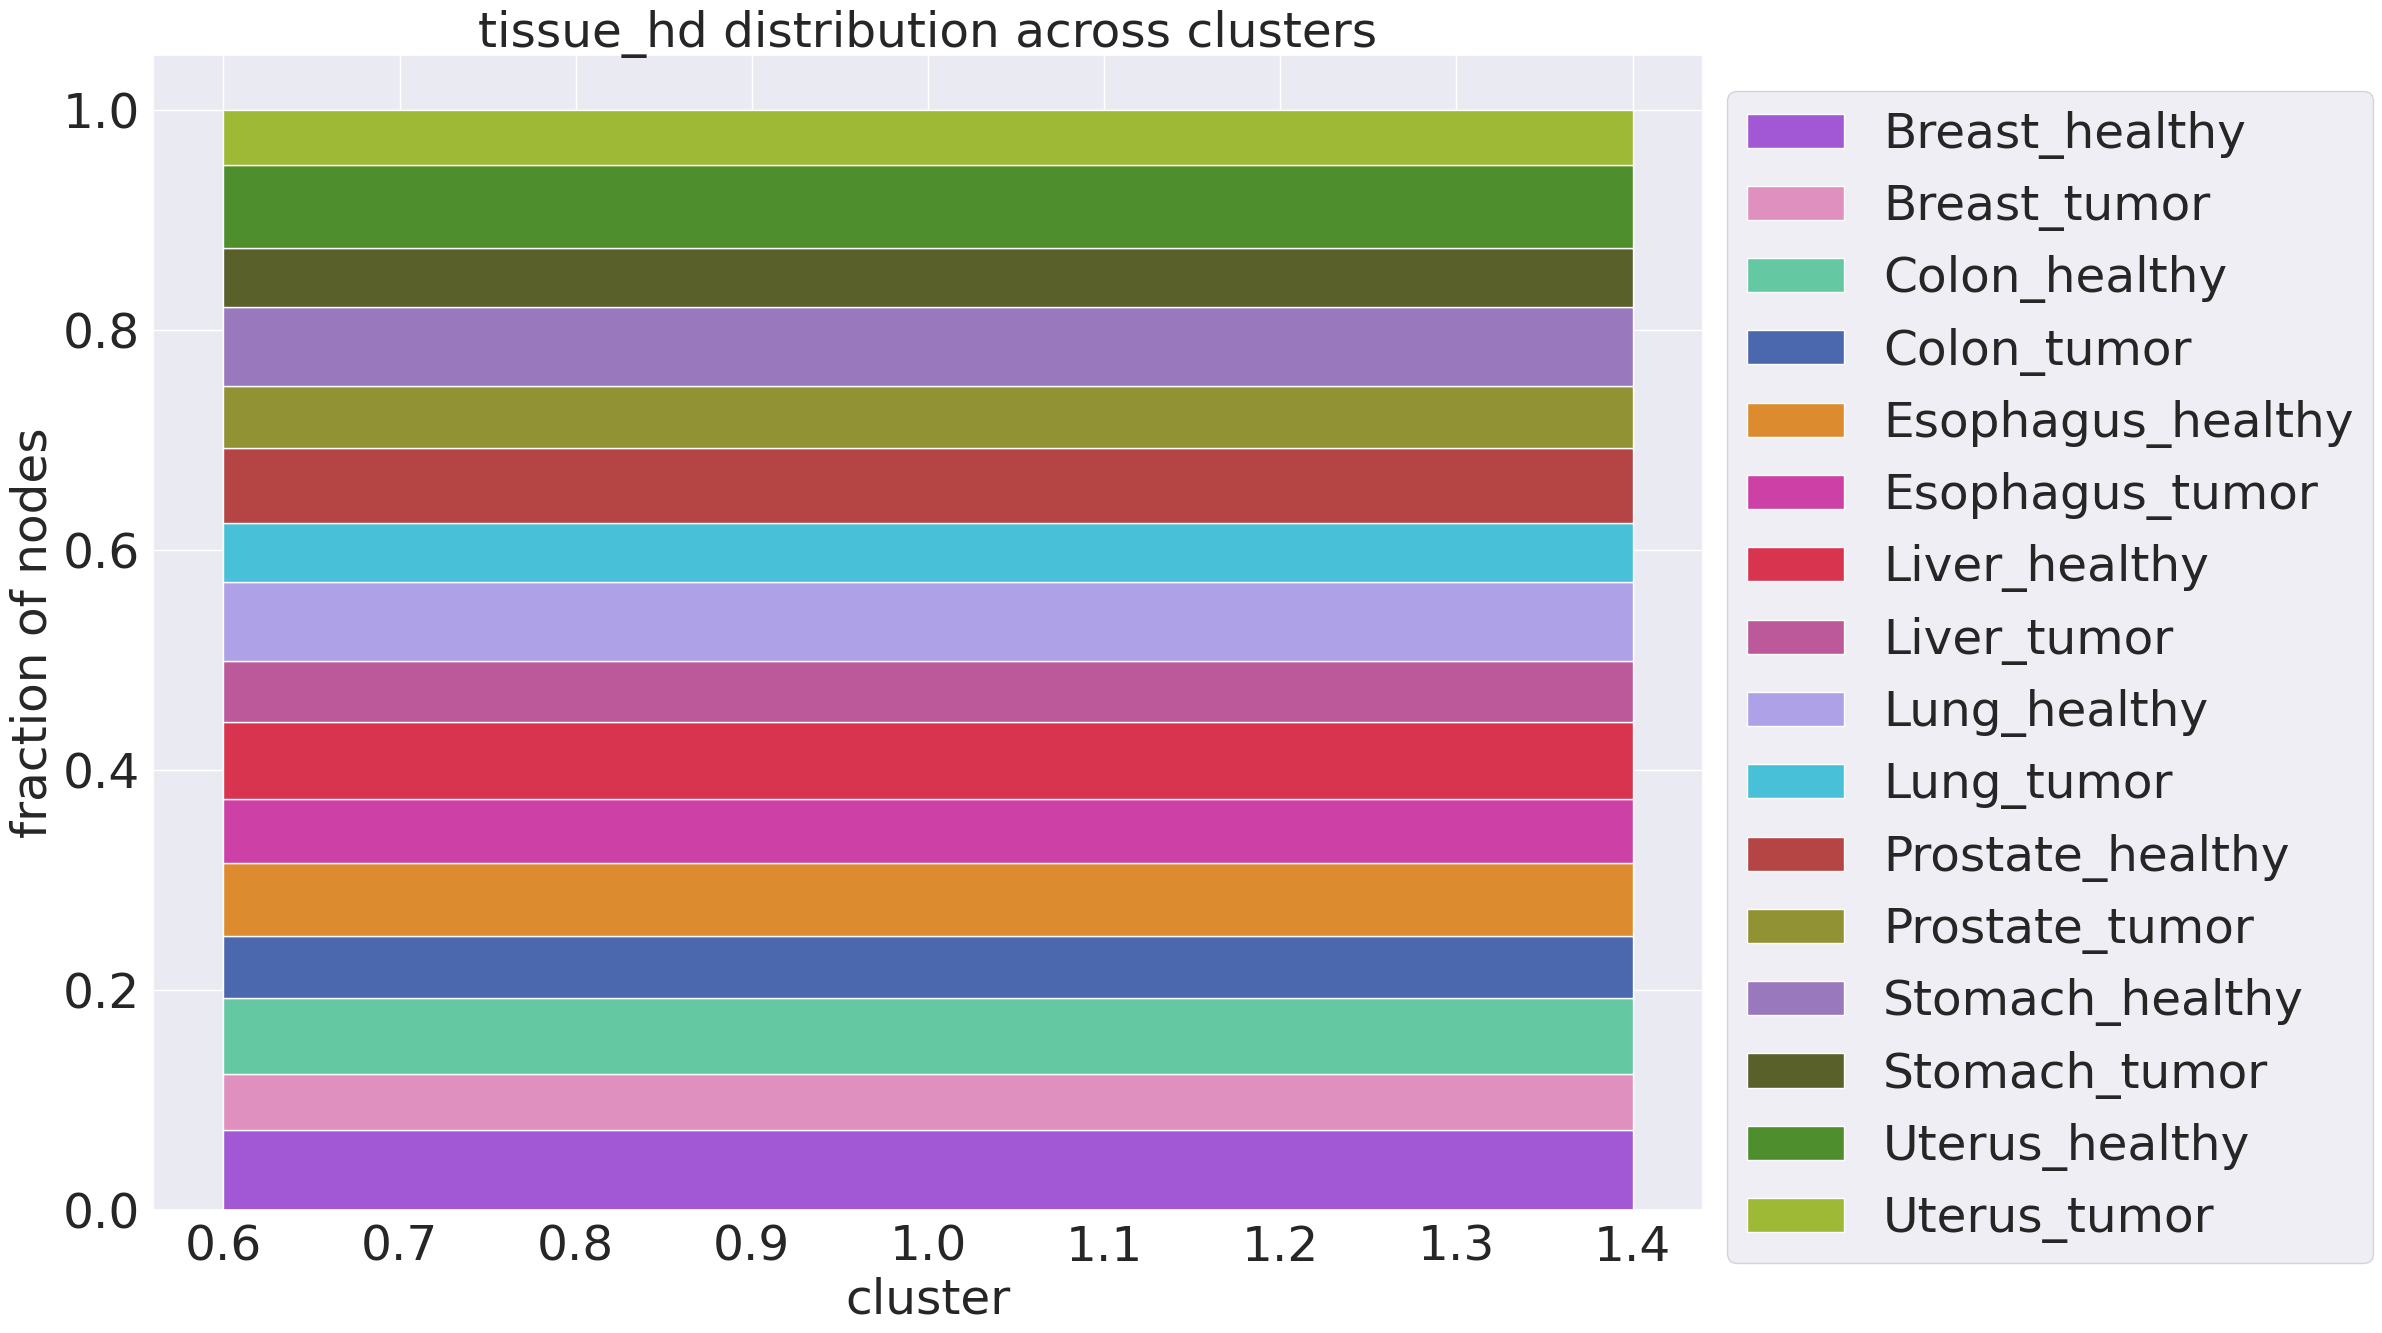

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


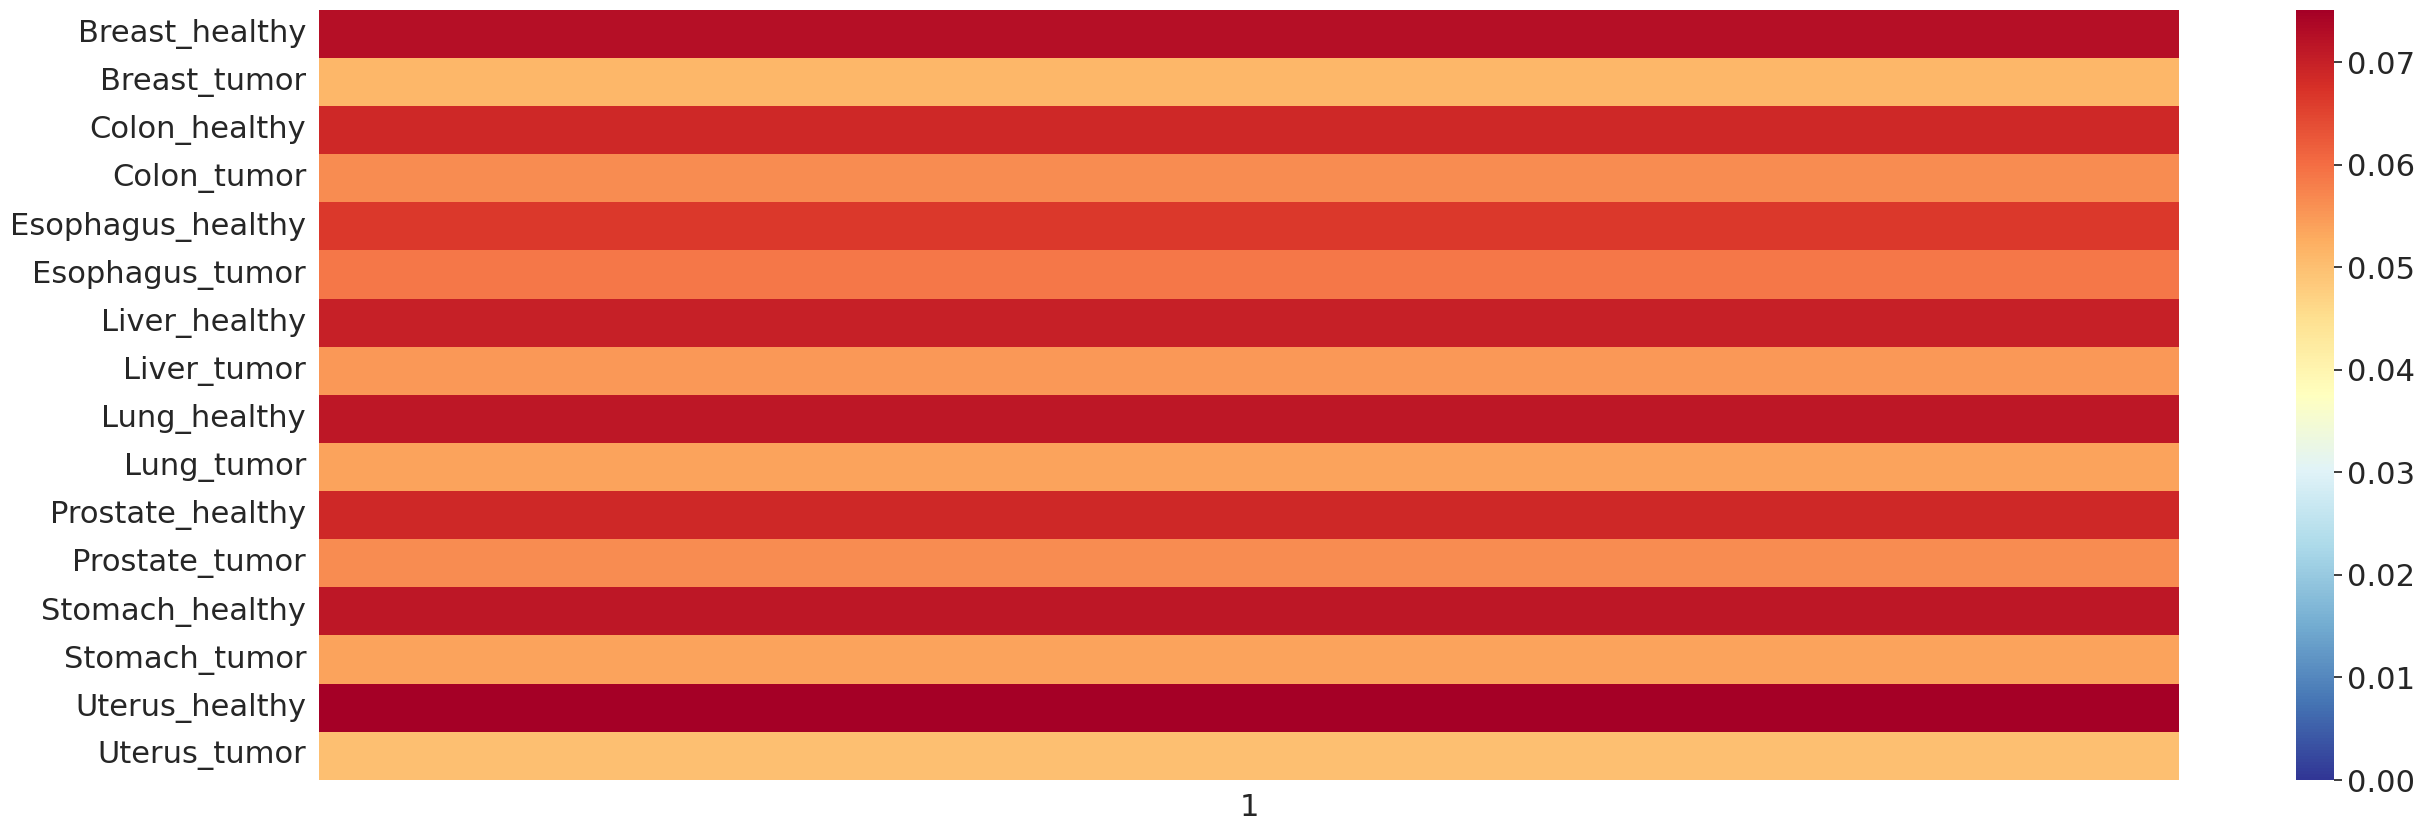

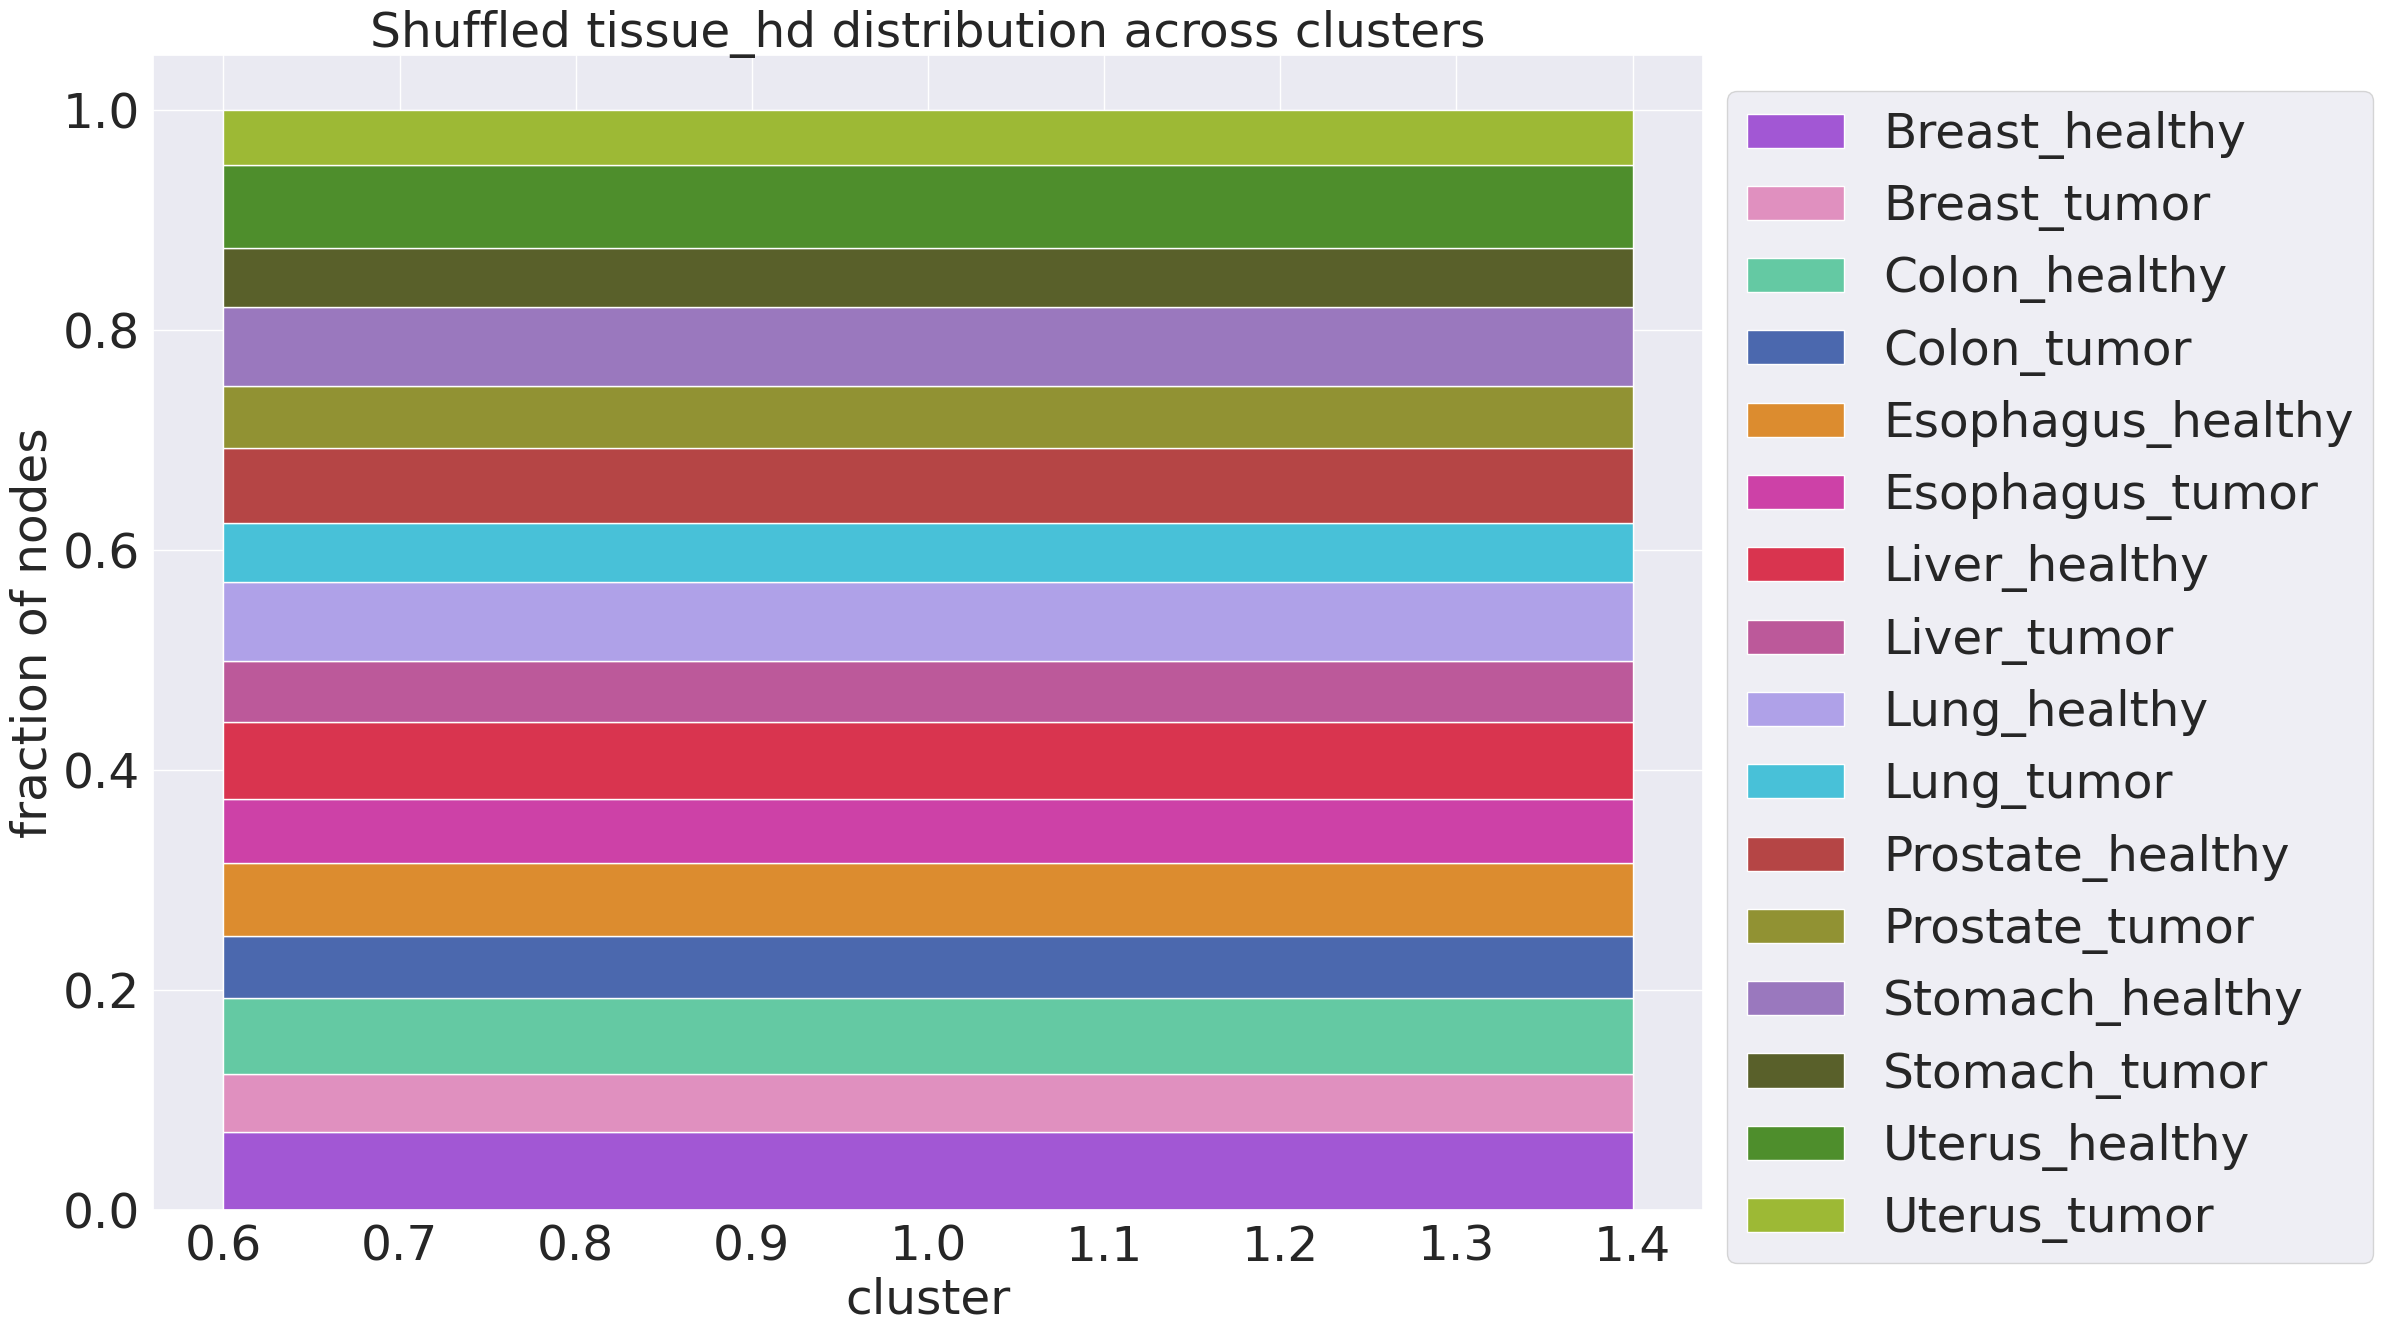

True tissue_hd 3


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


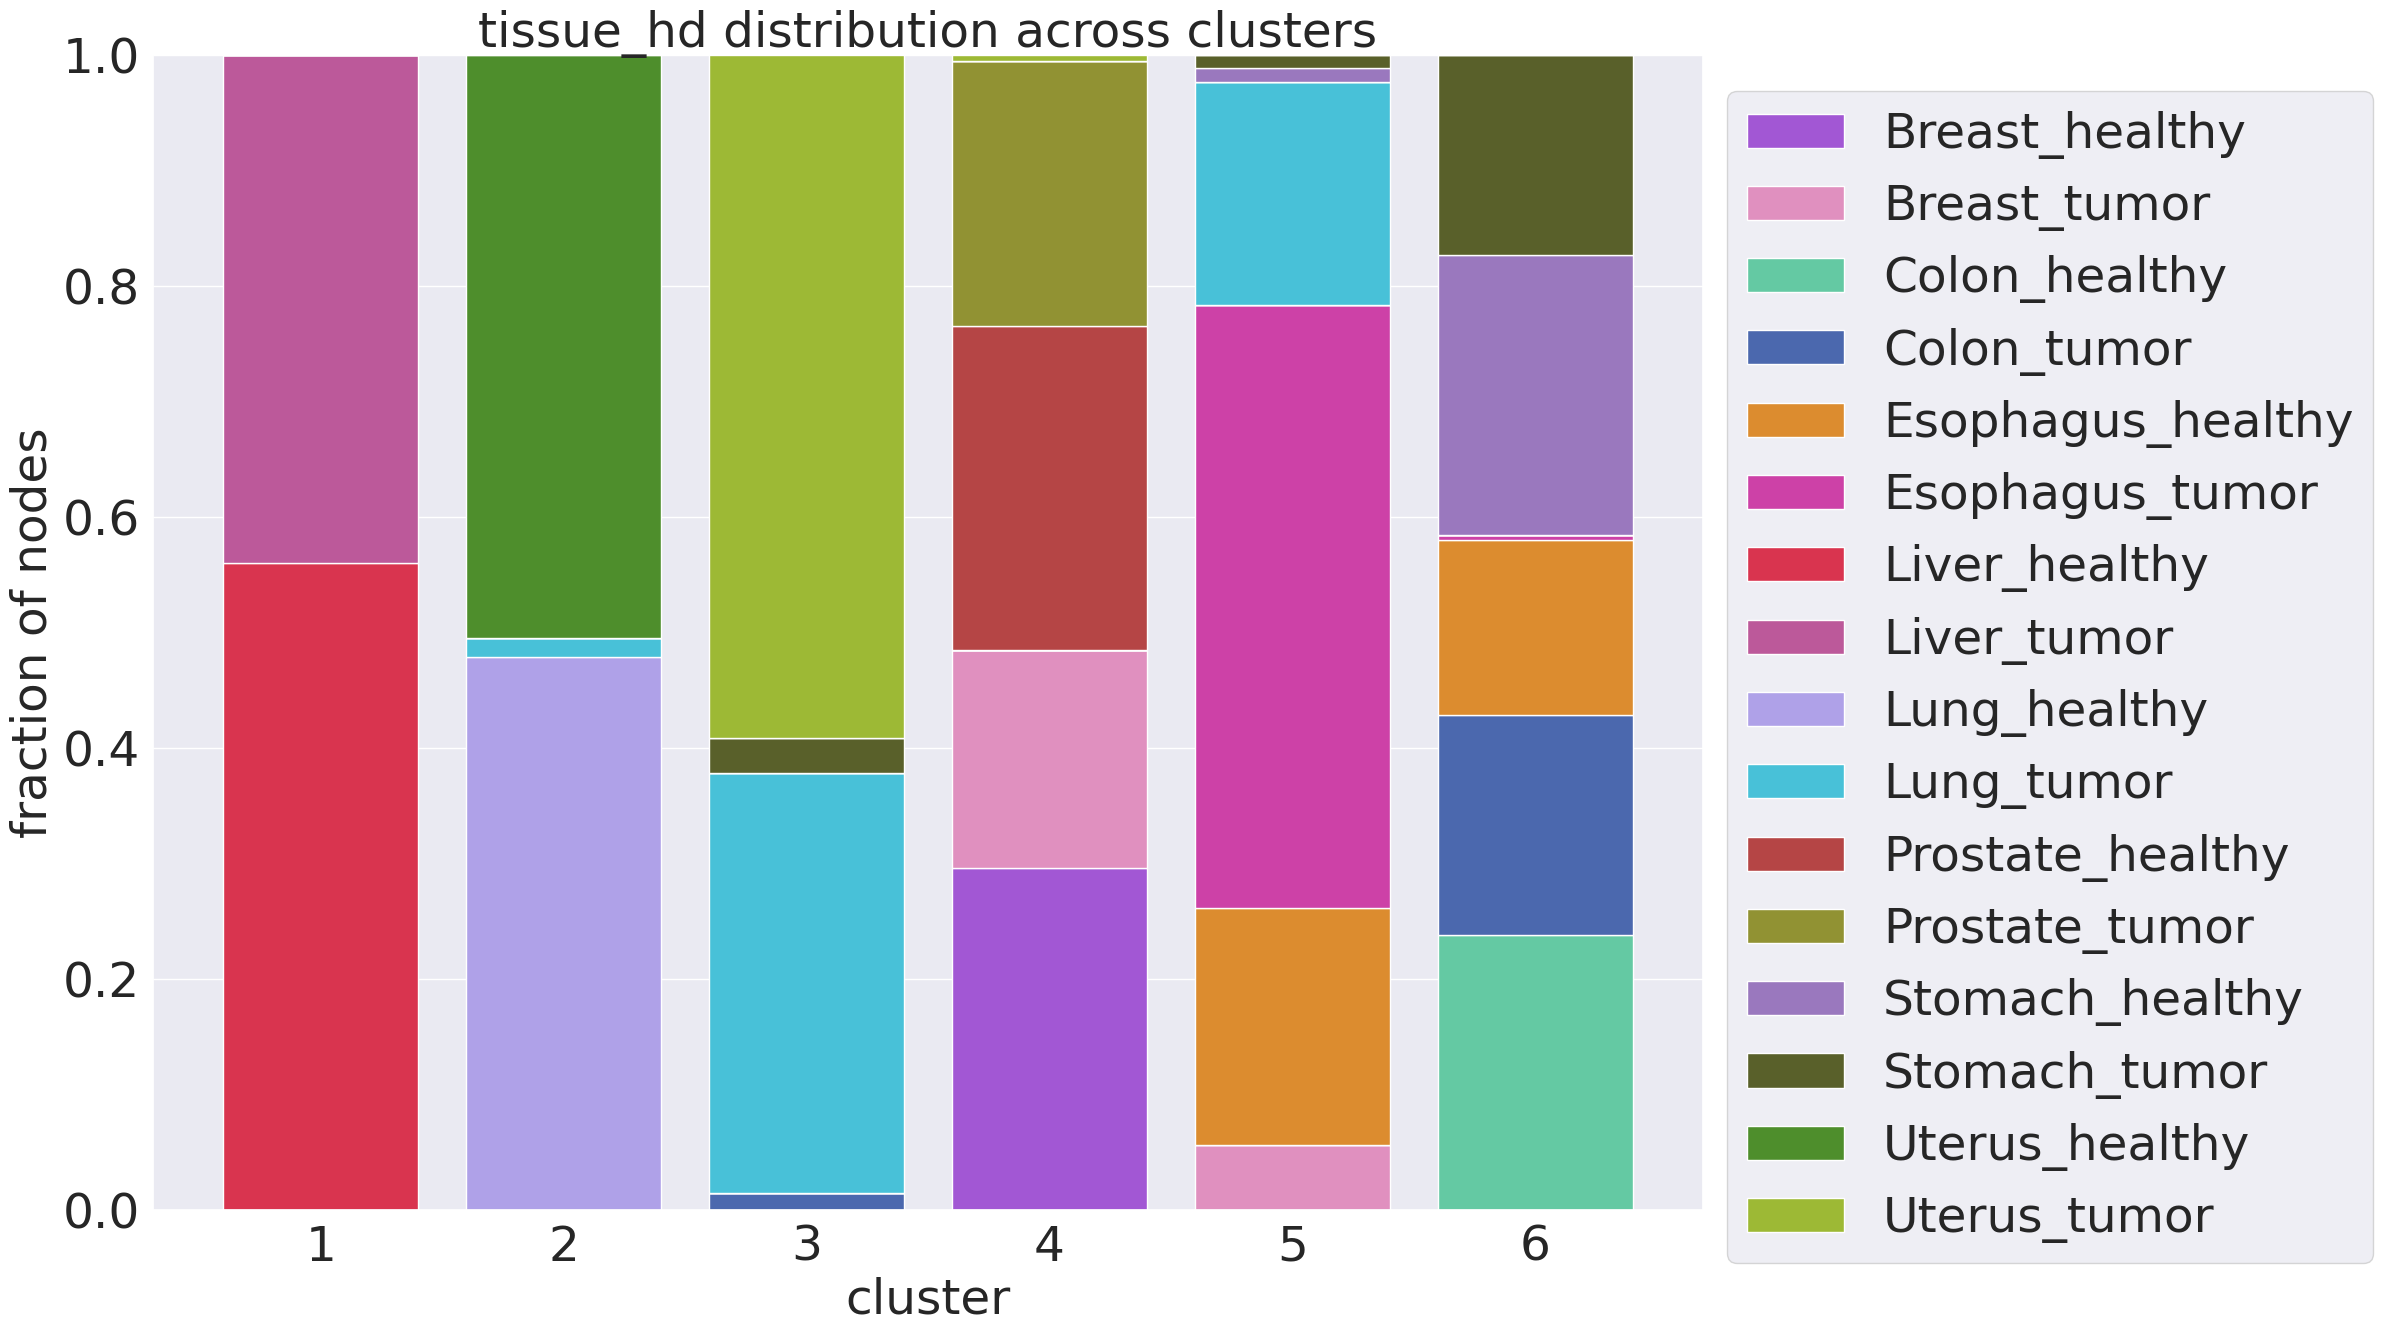

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


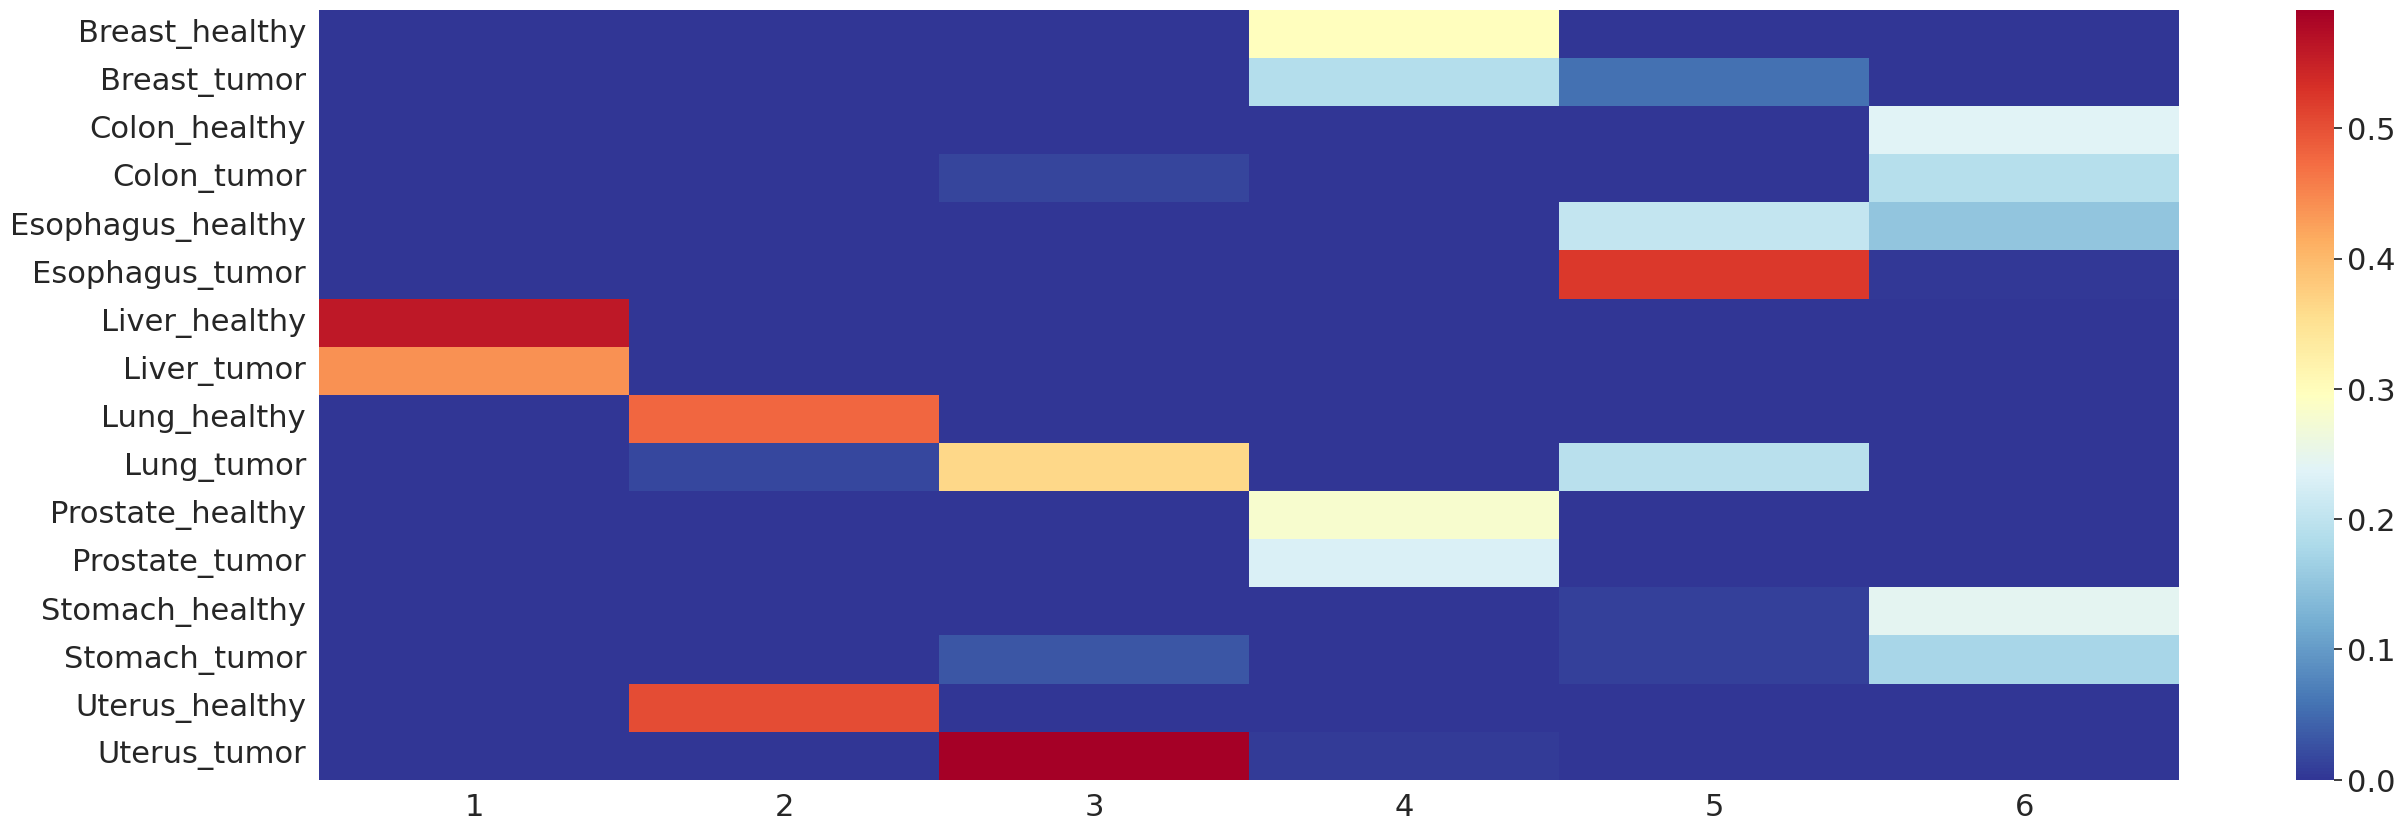

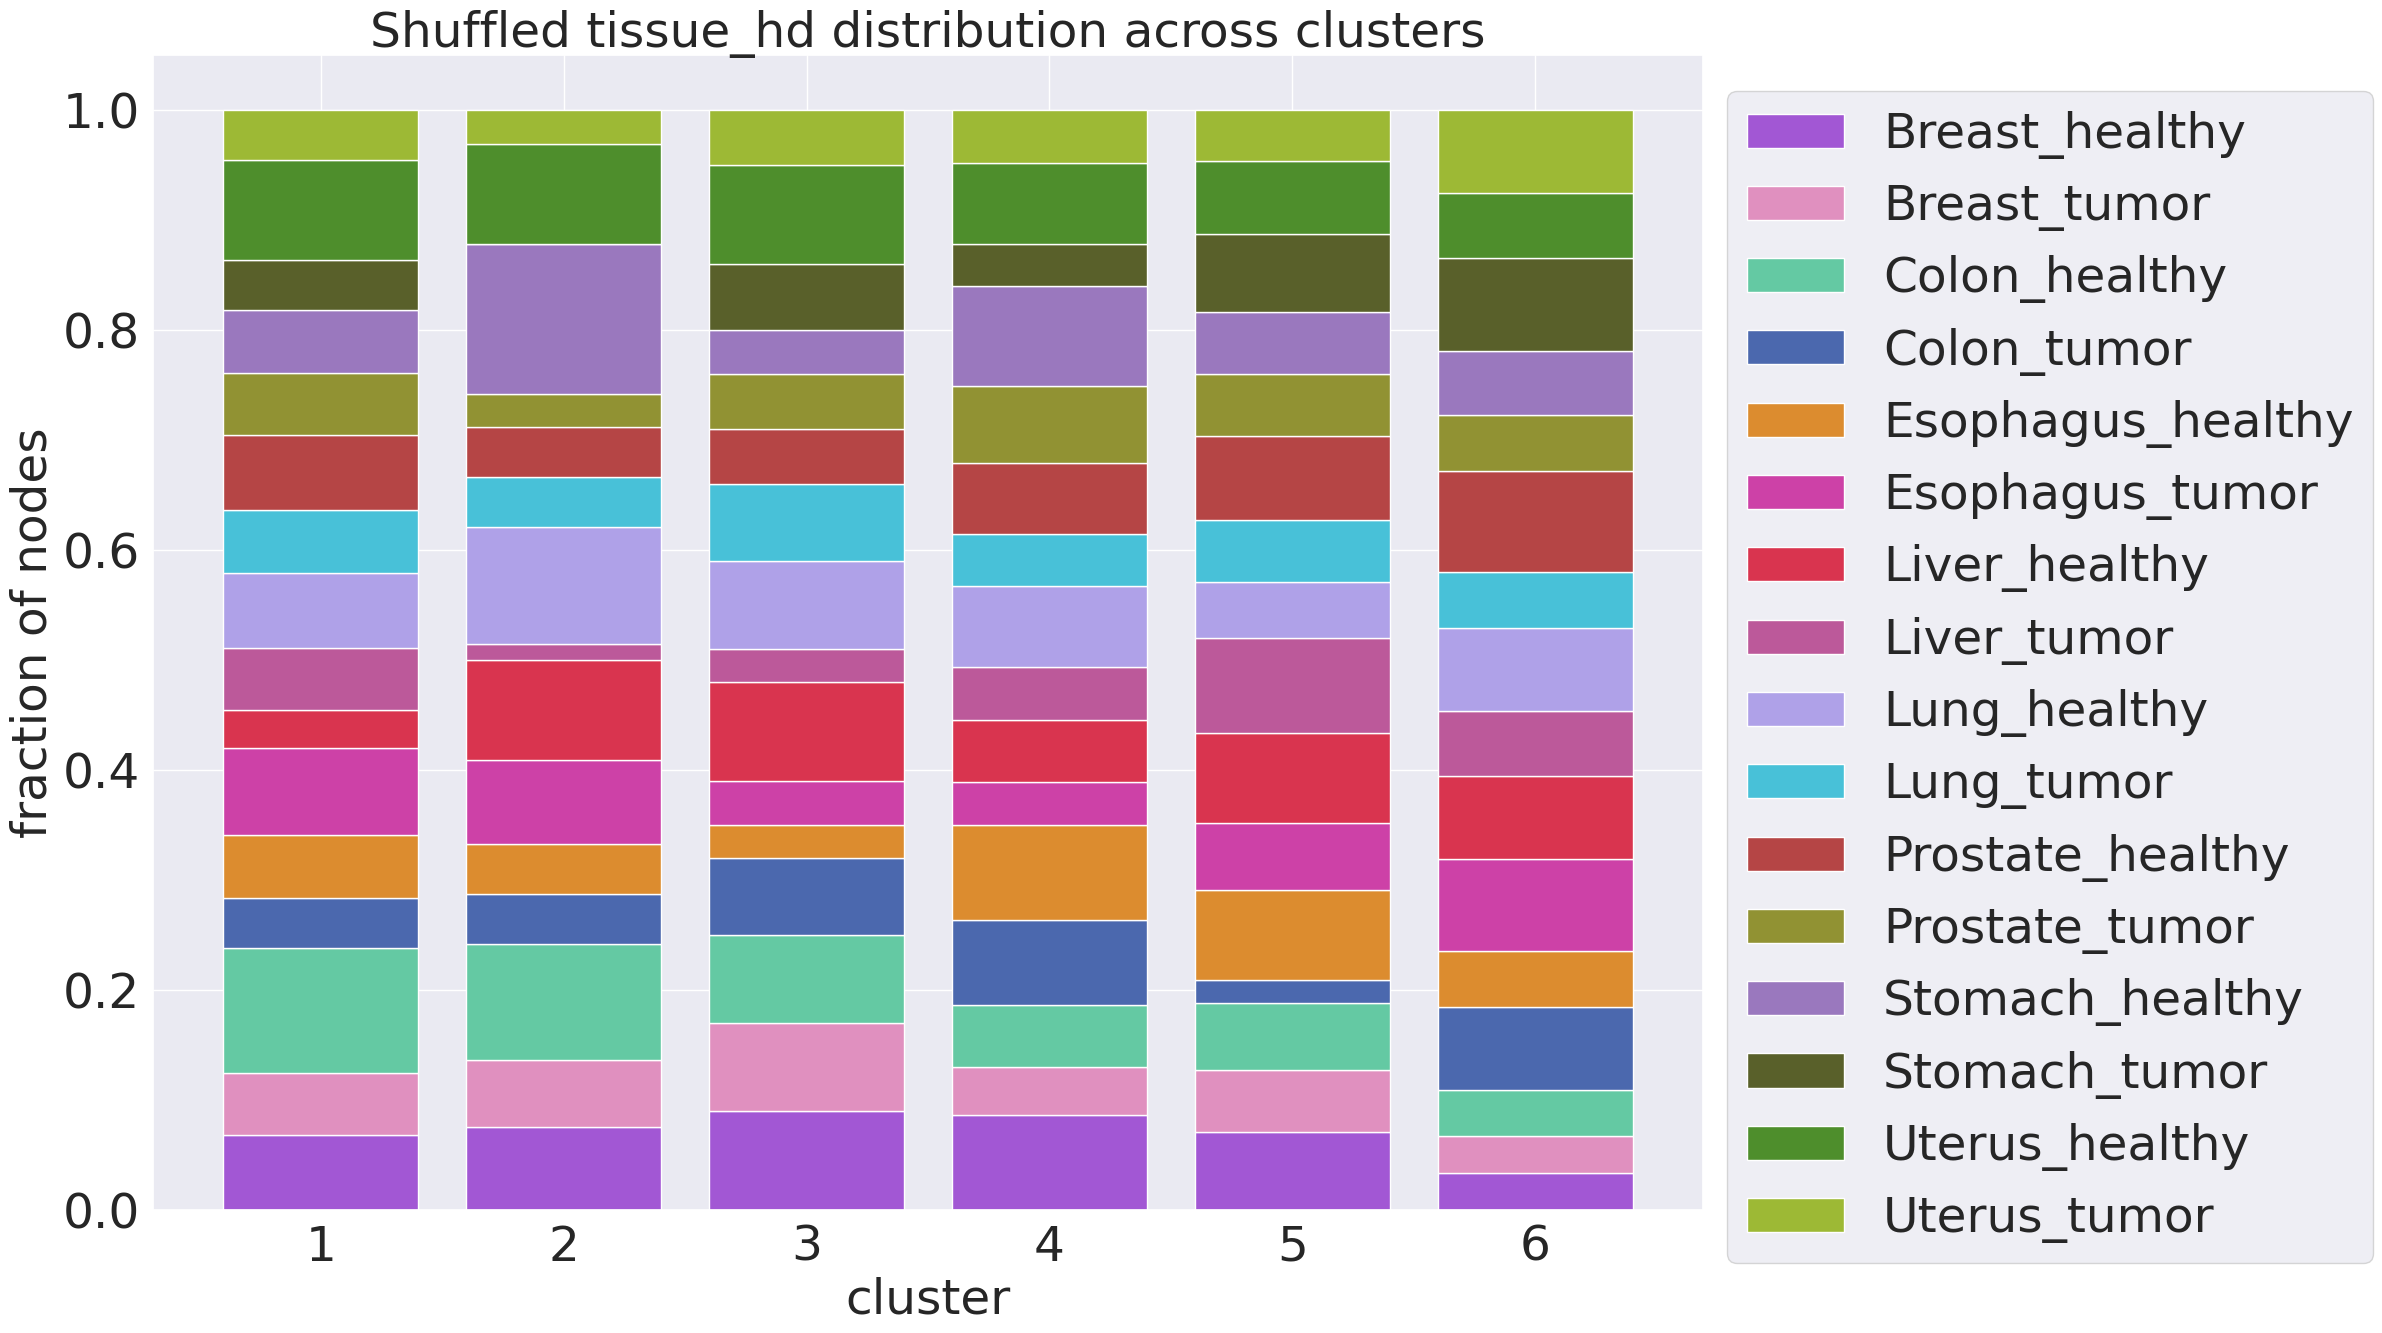

True tissue_hd 2


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


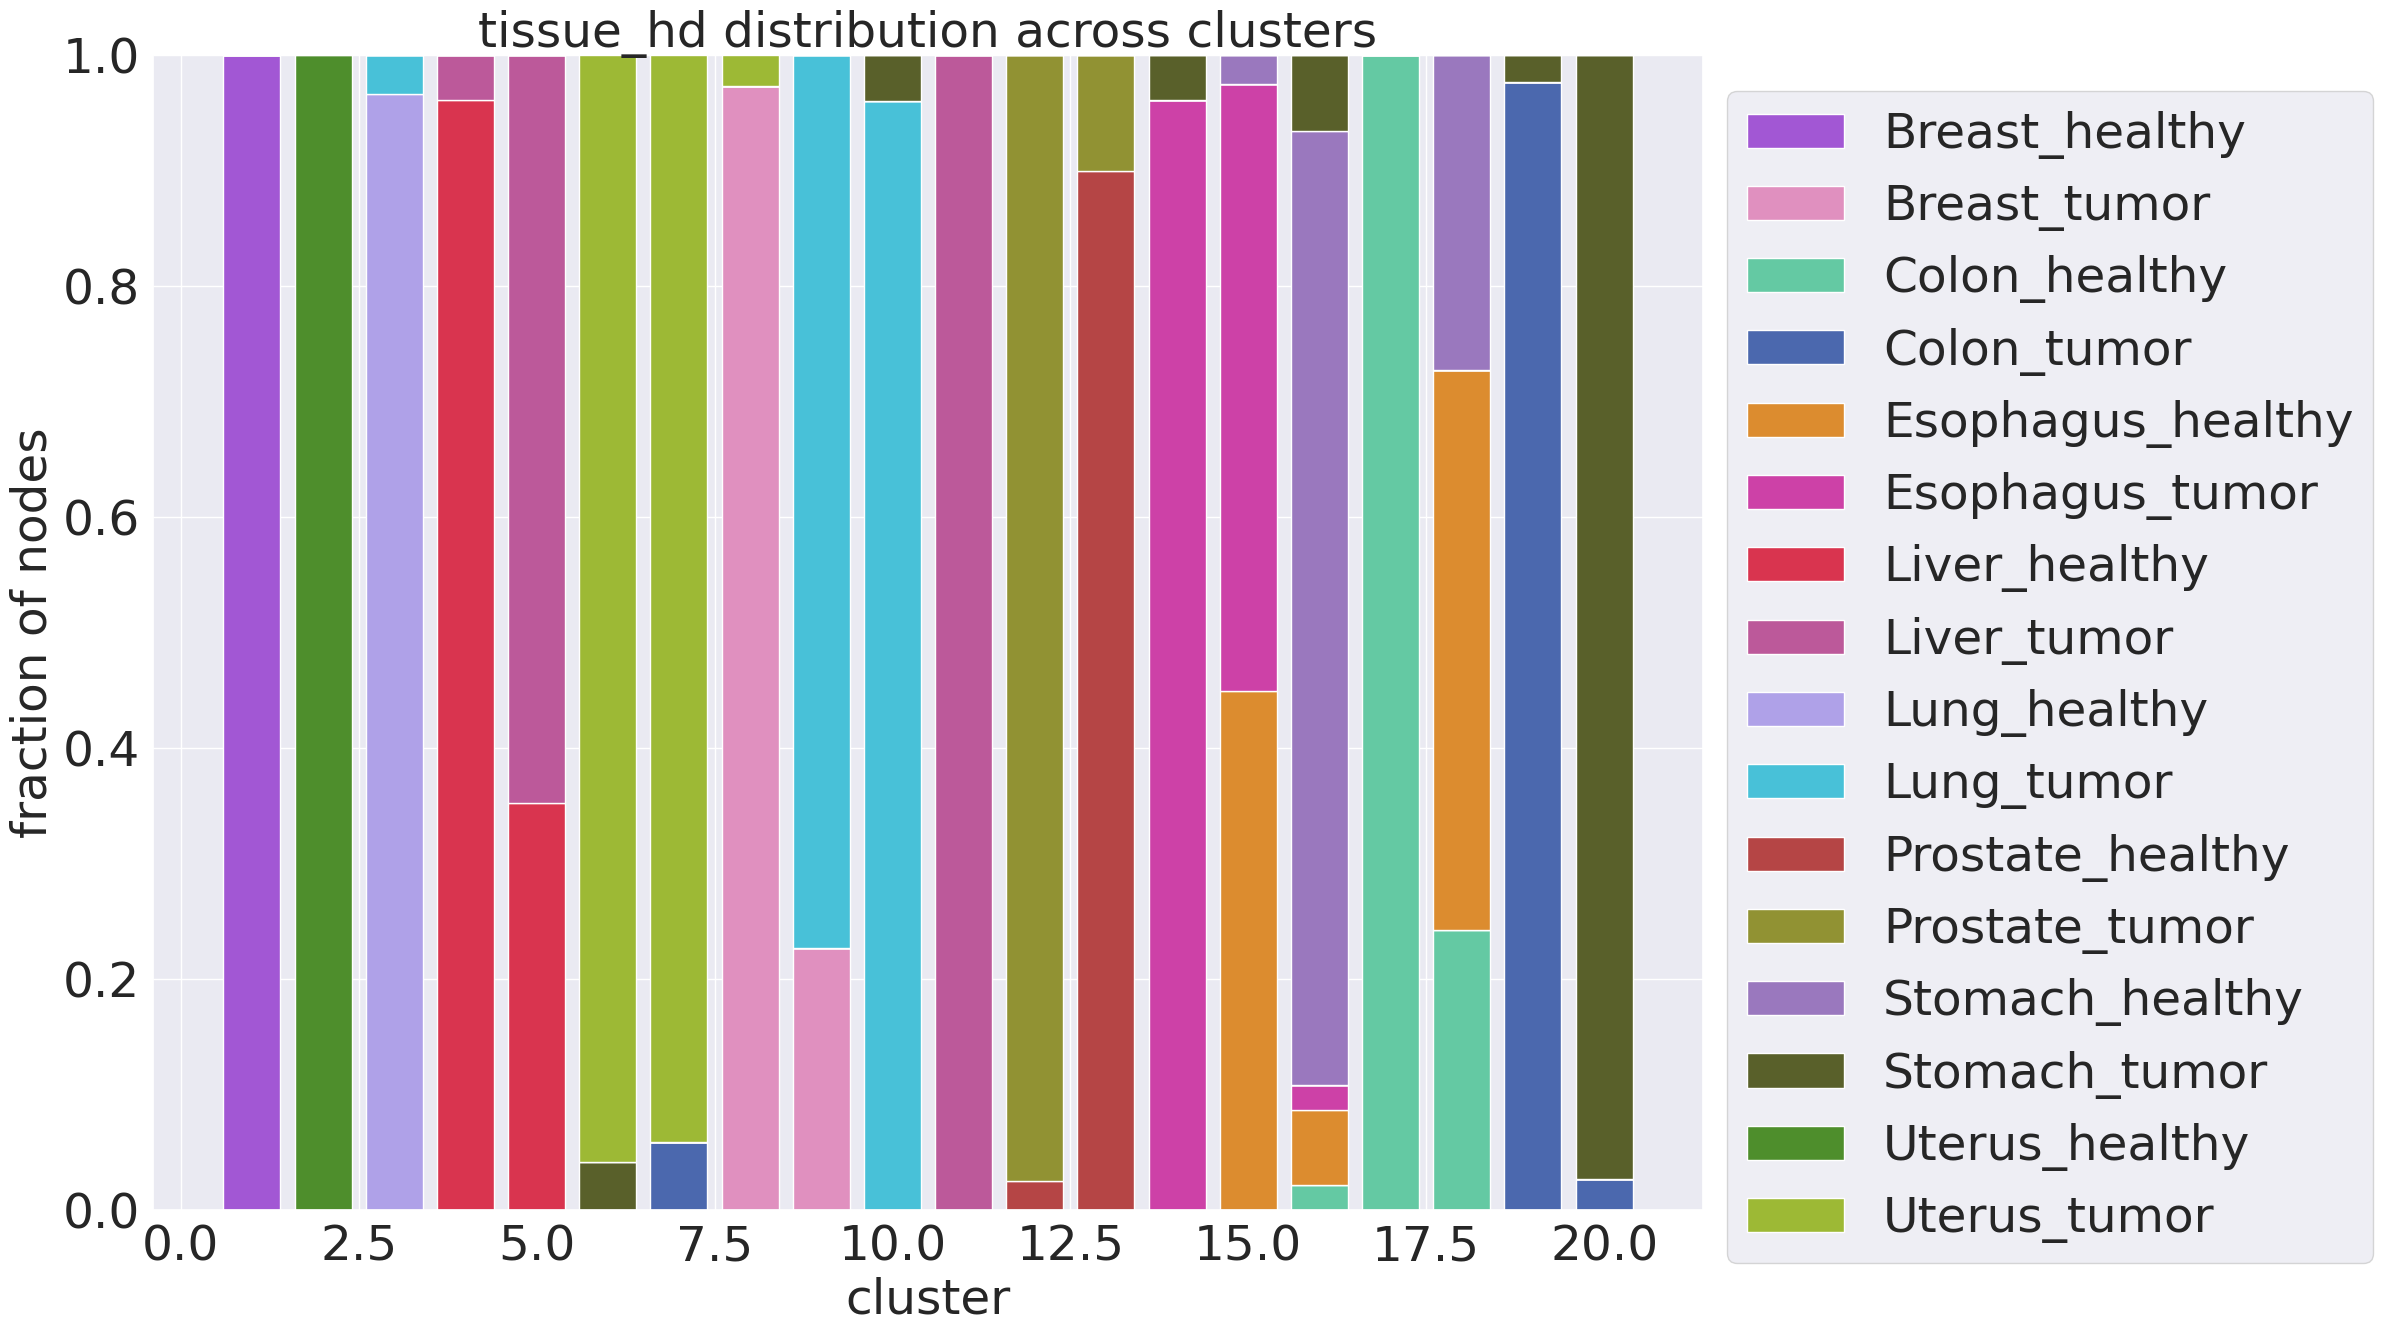

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


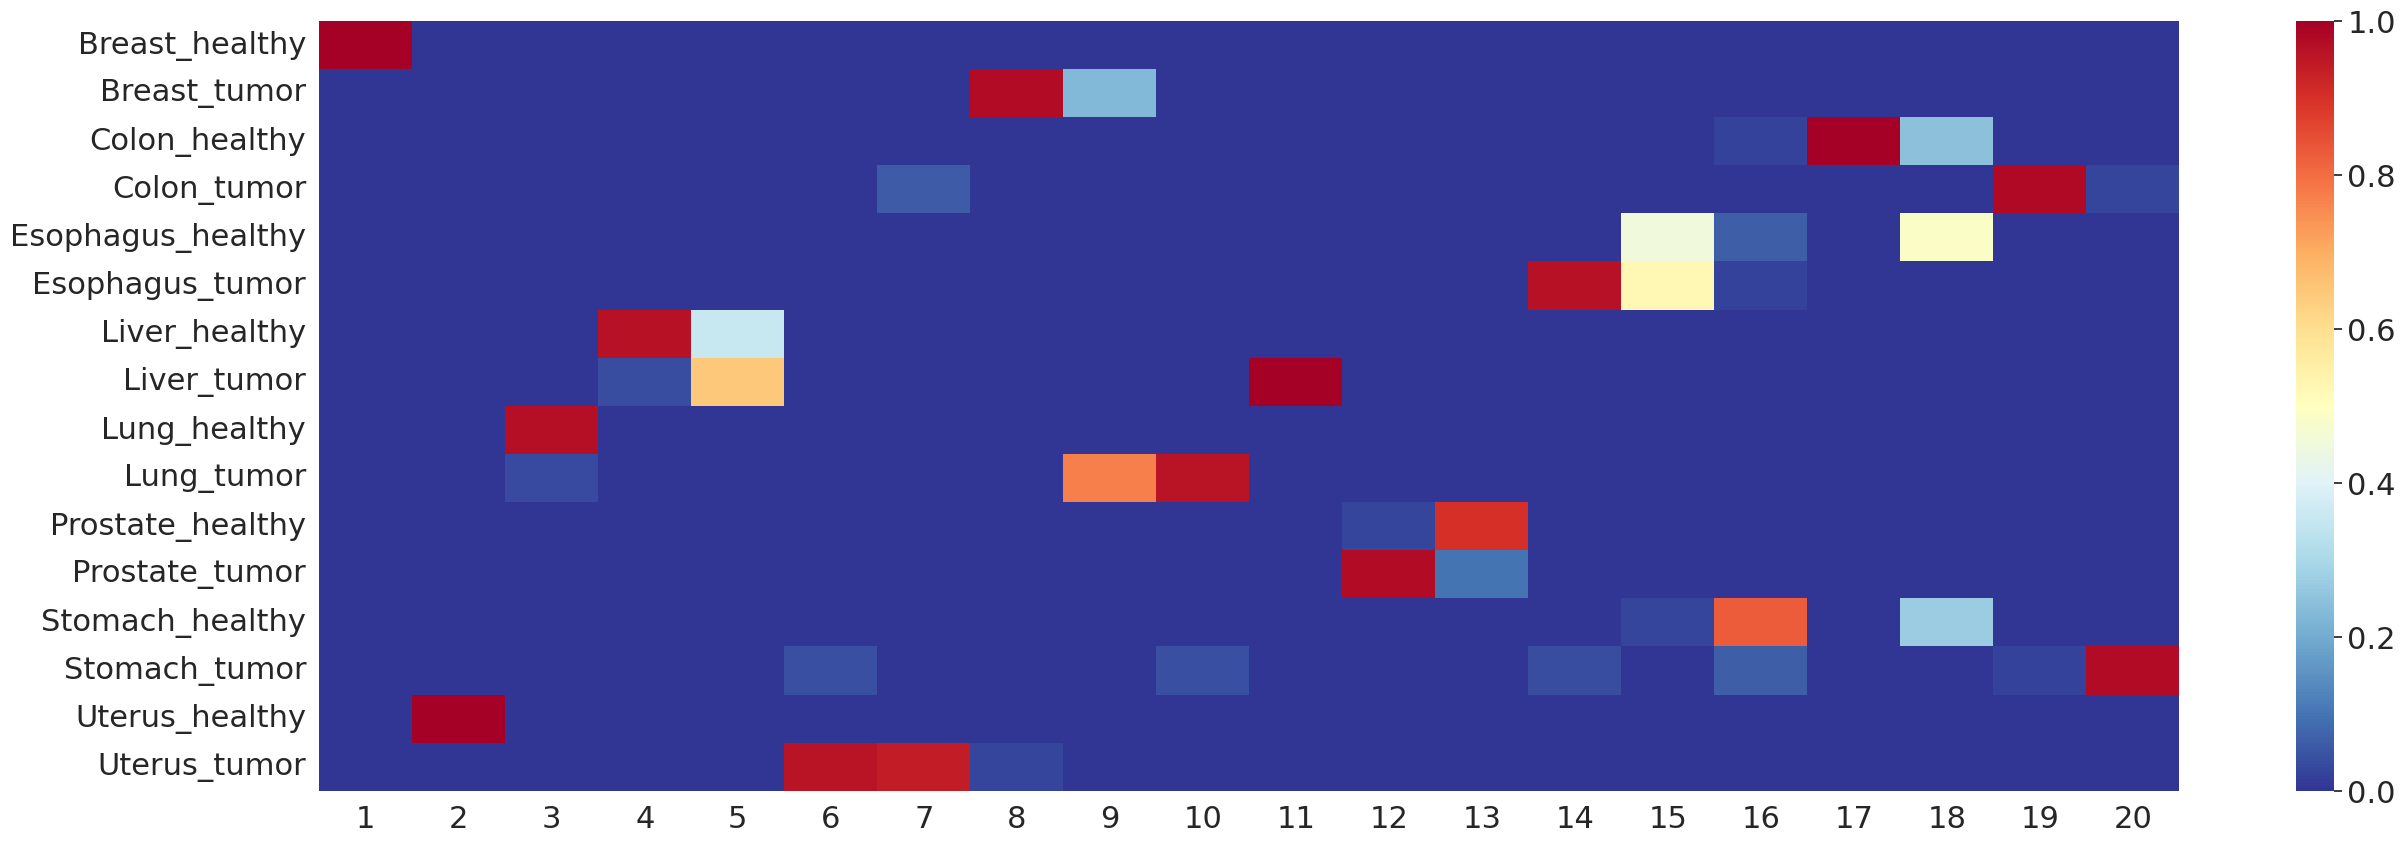

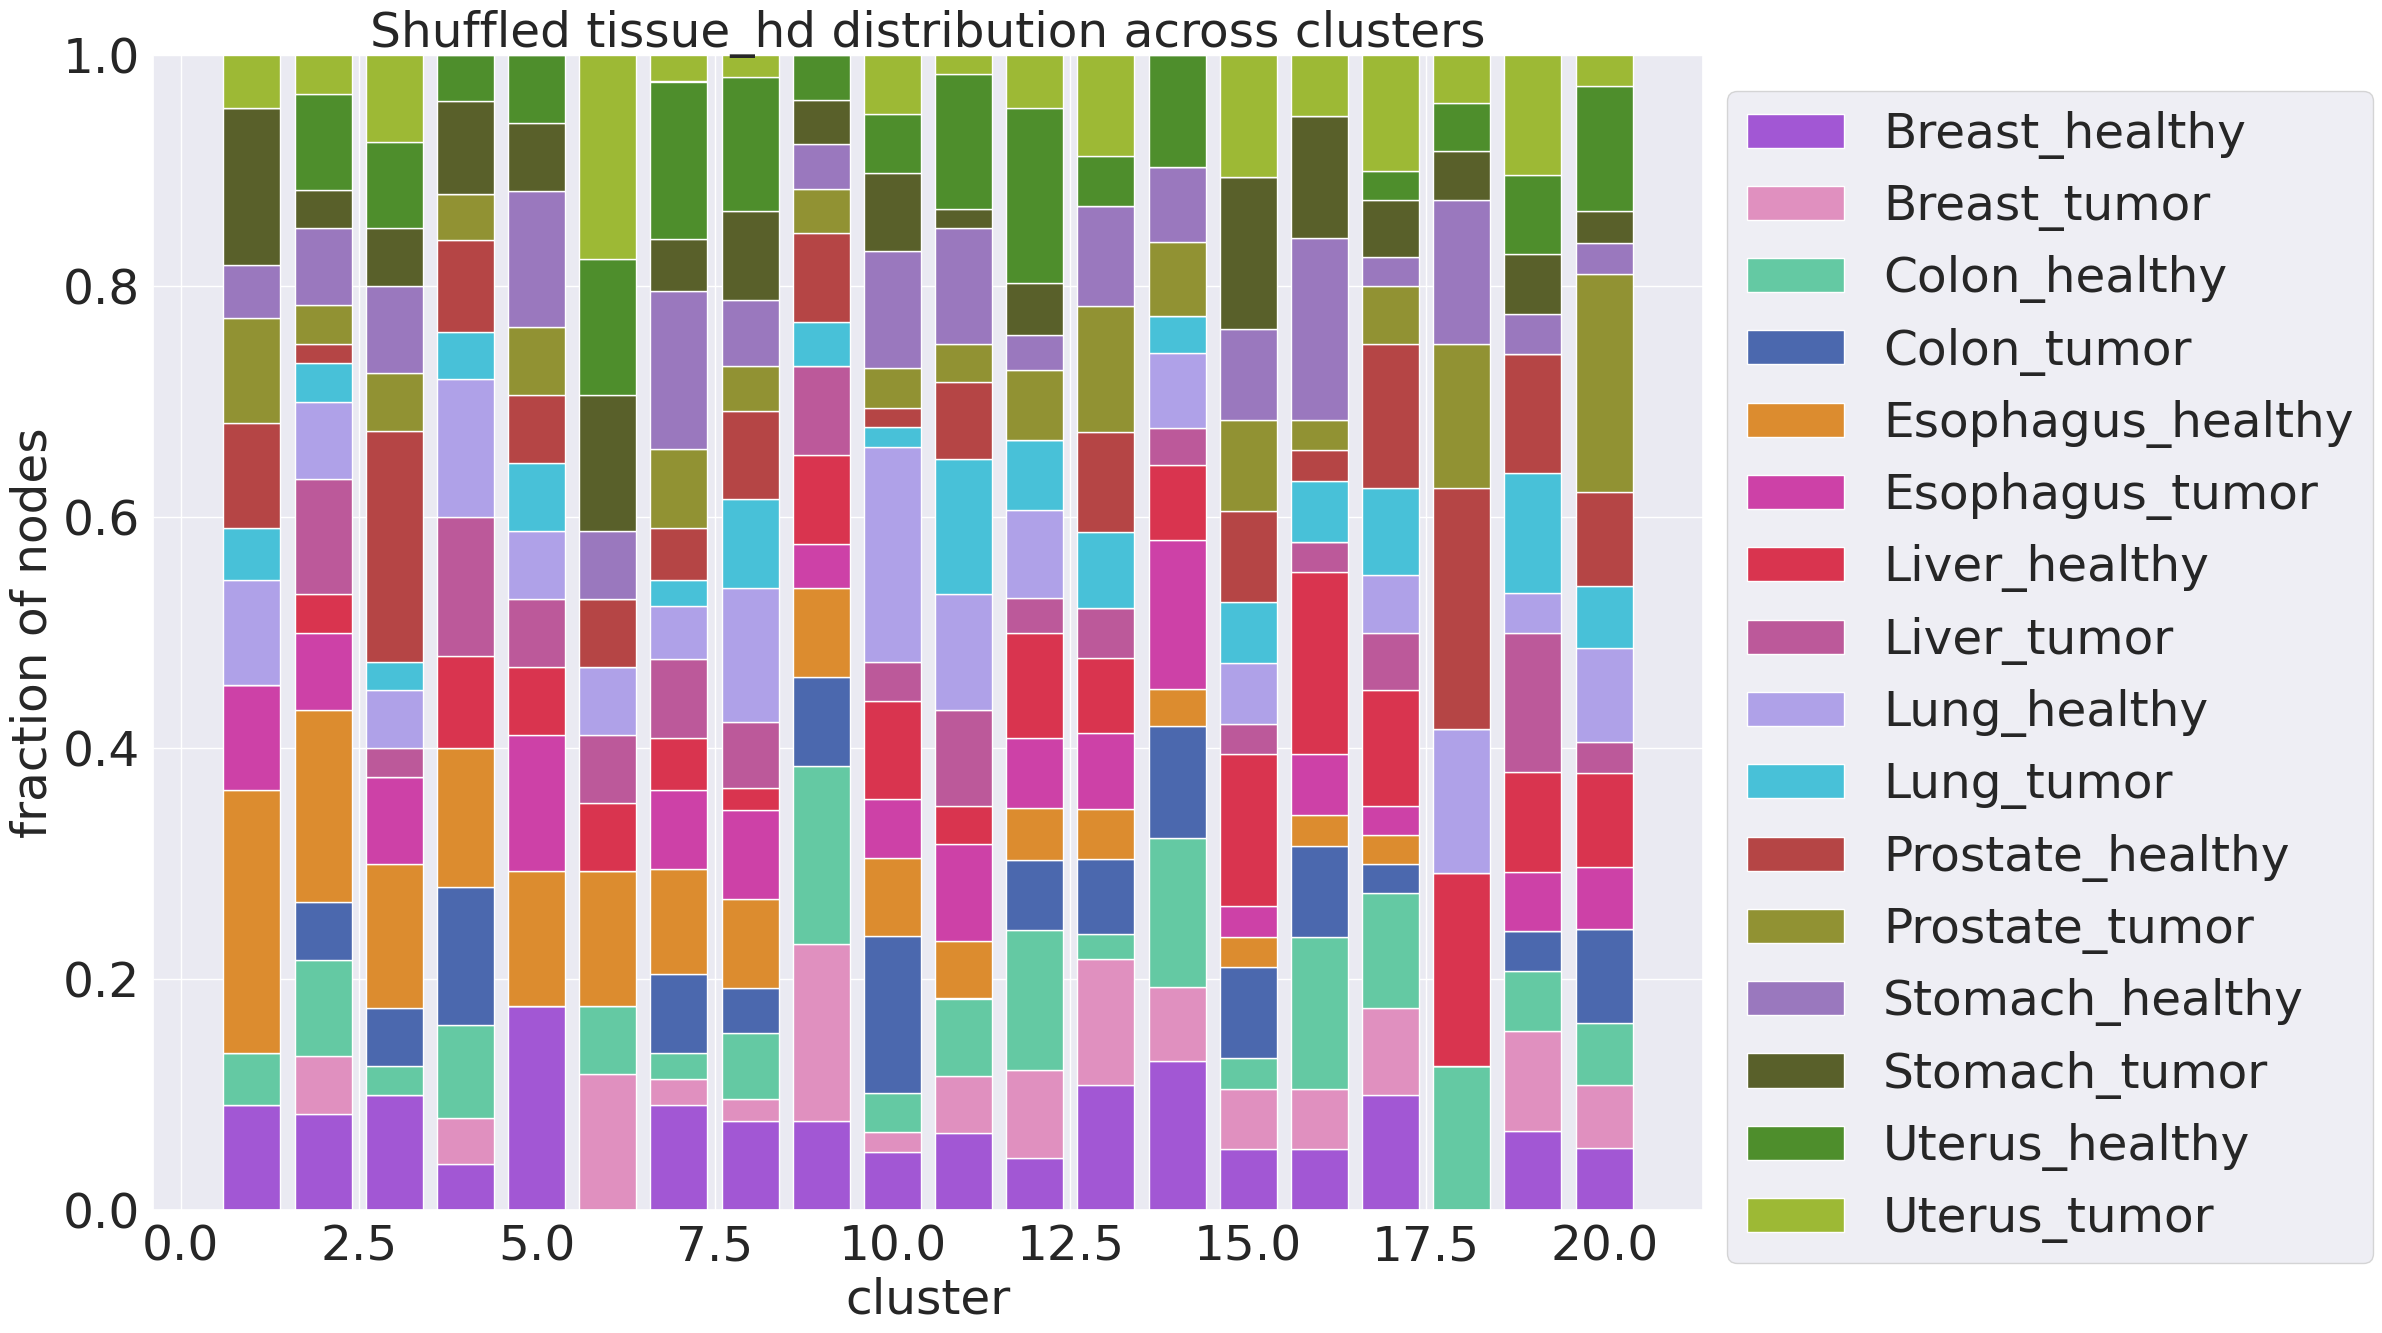

True tissue_hd 1


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


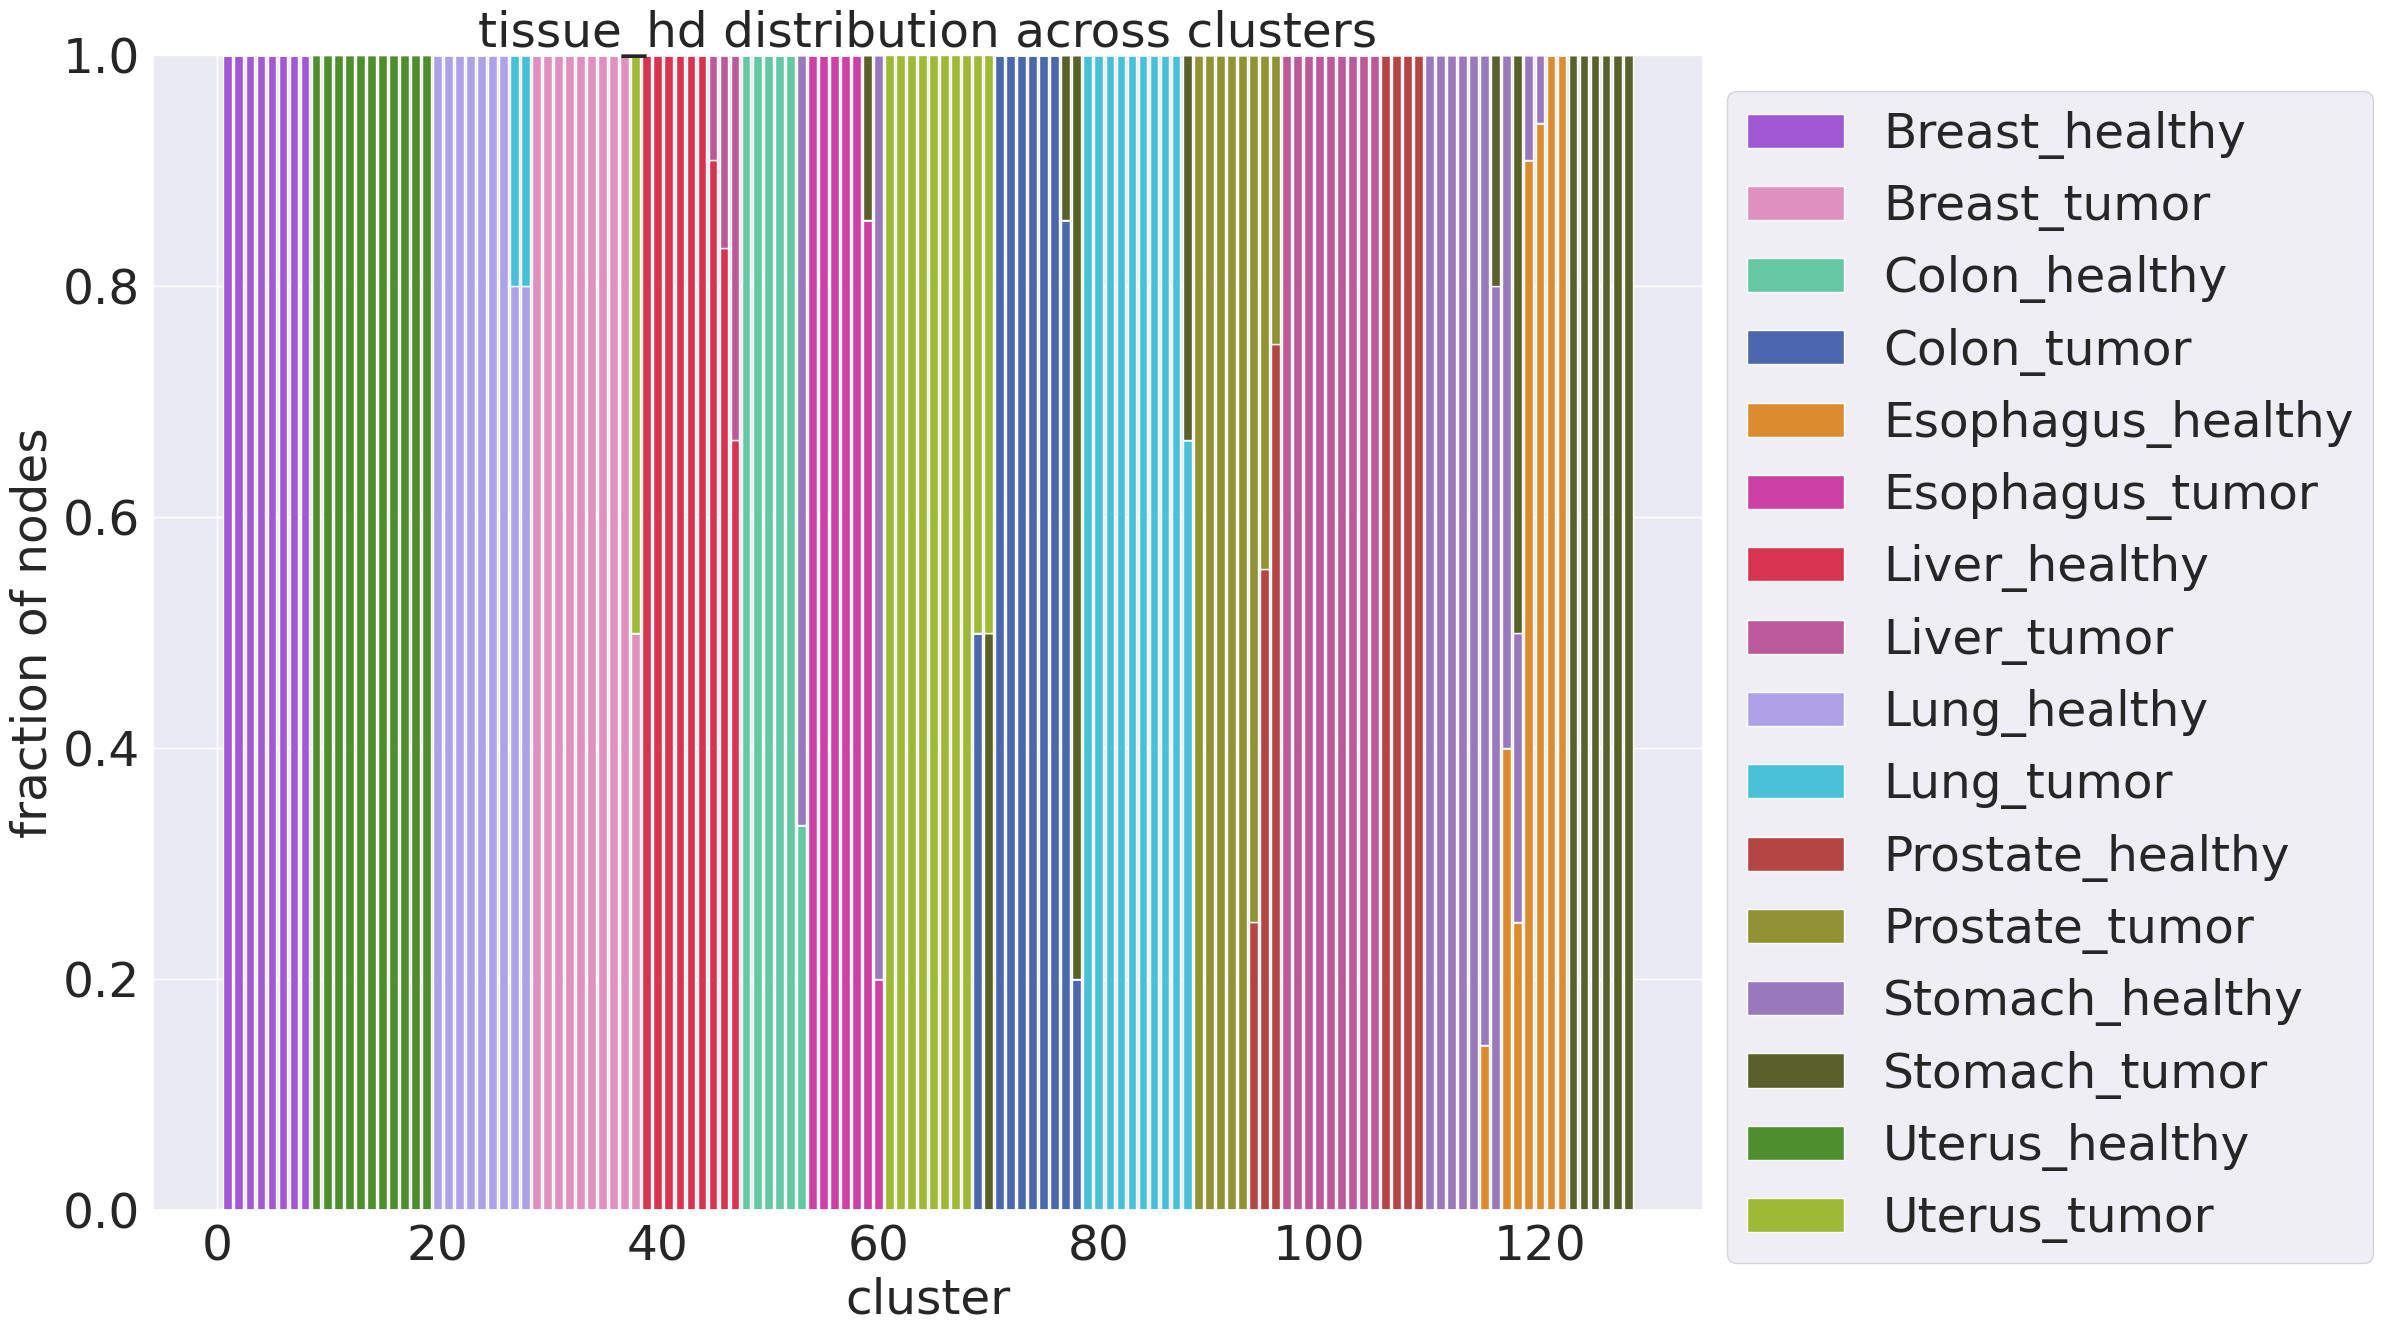

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


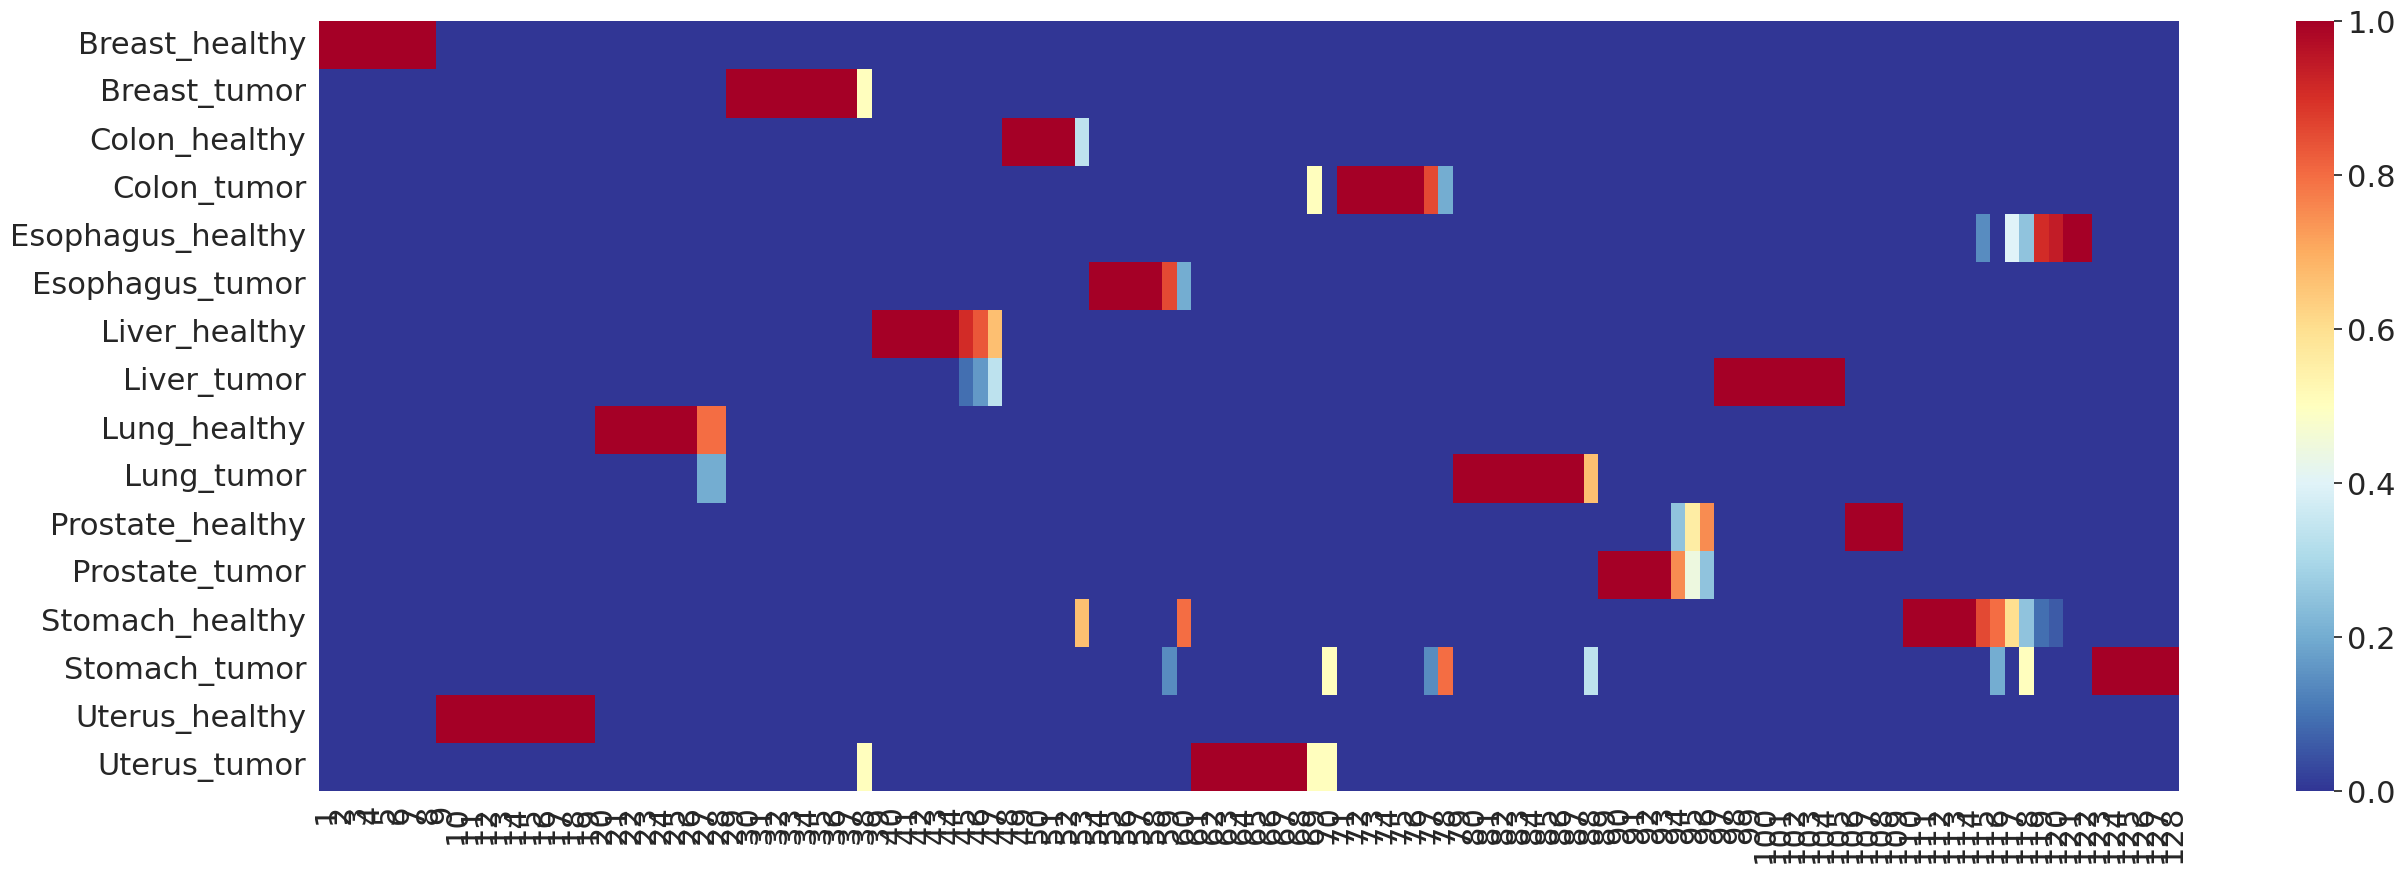

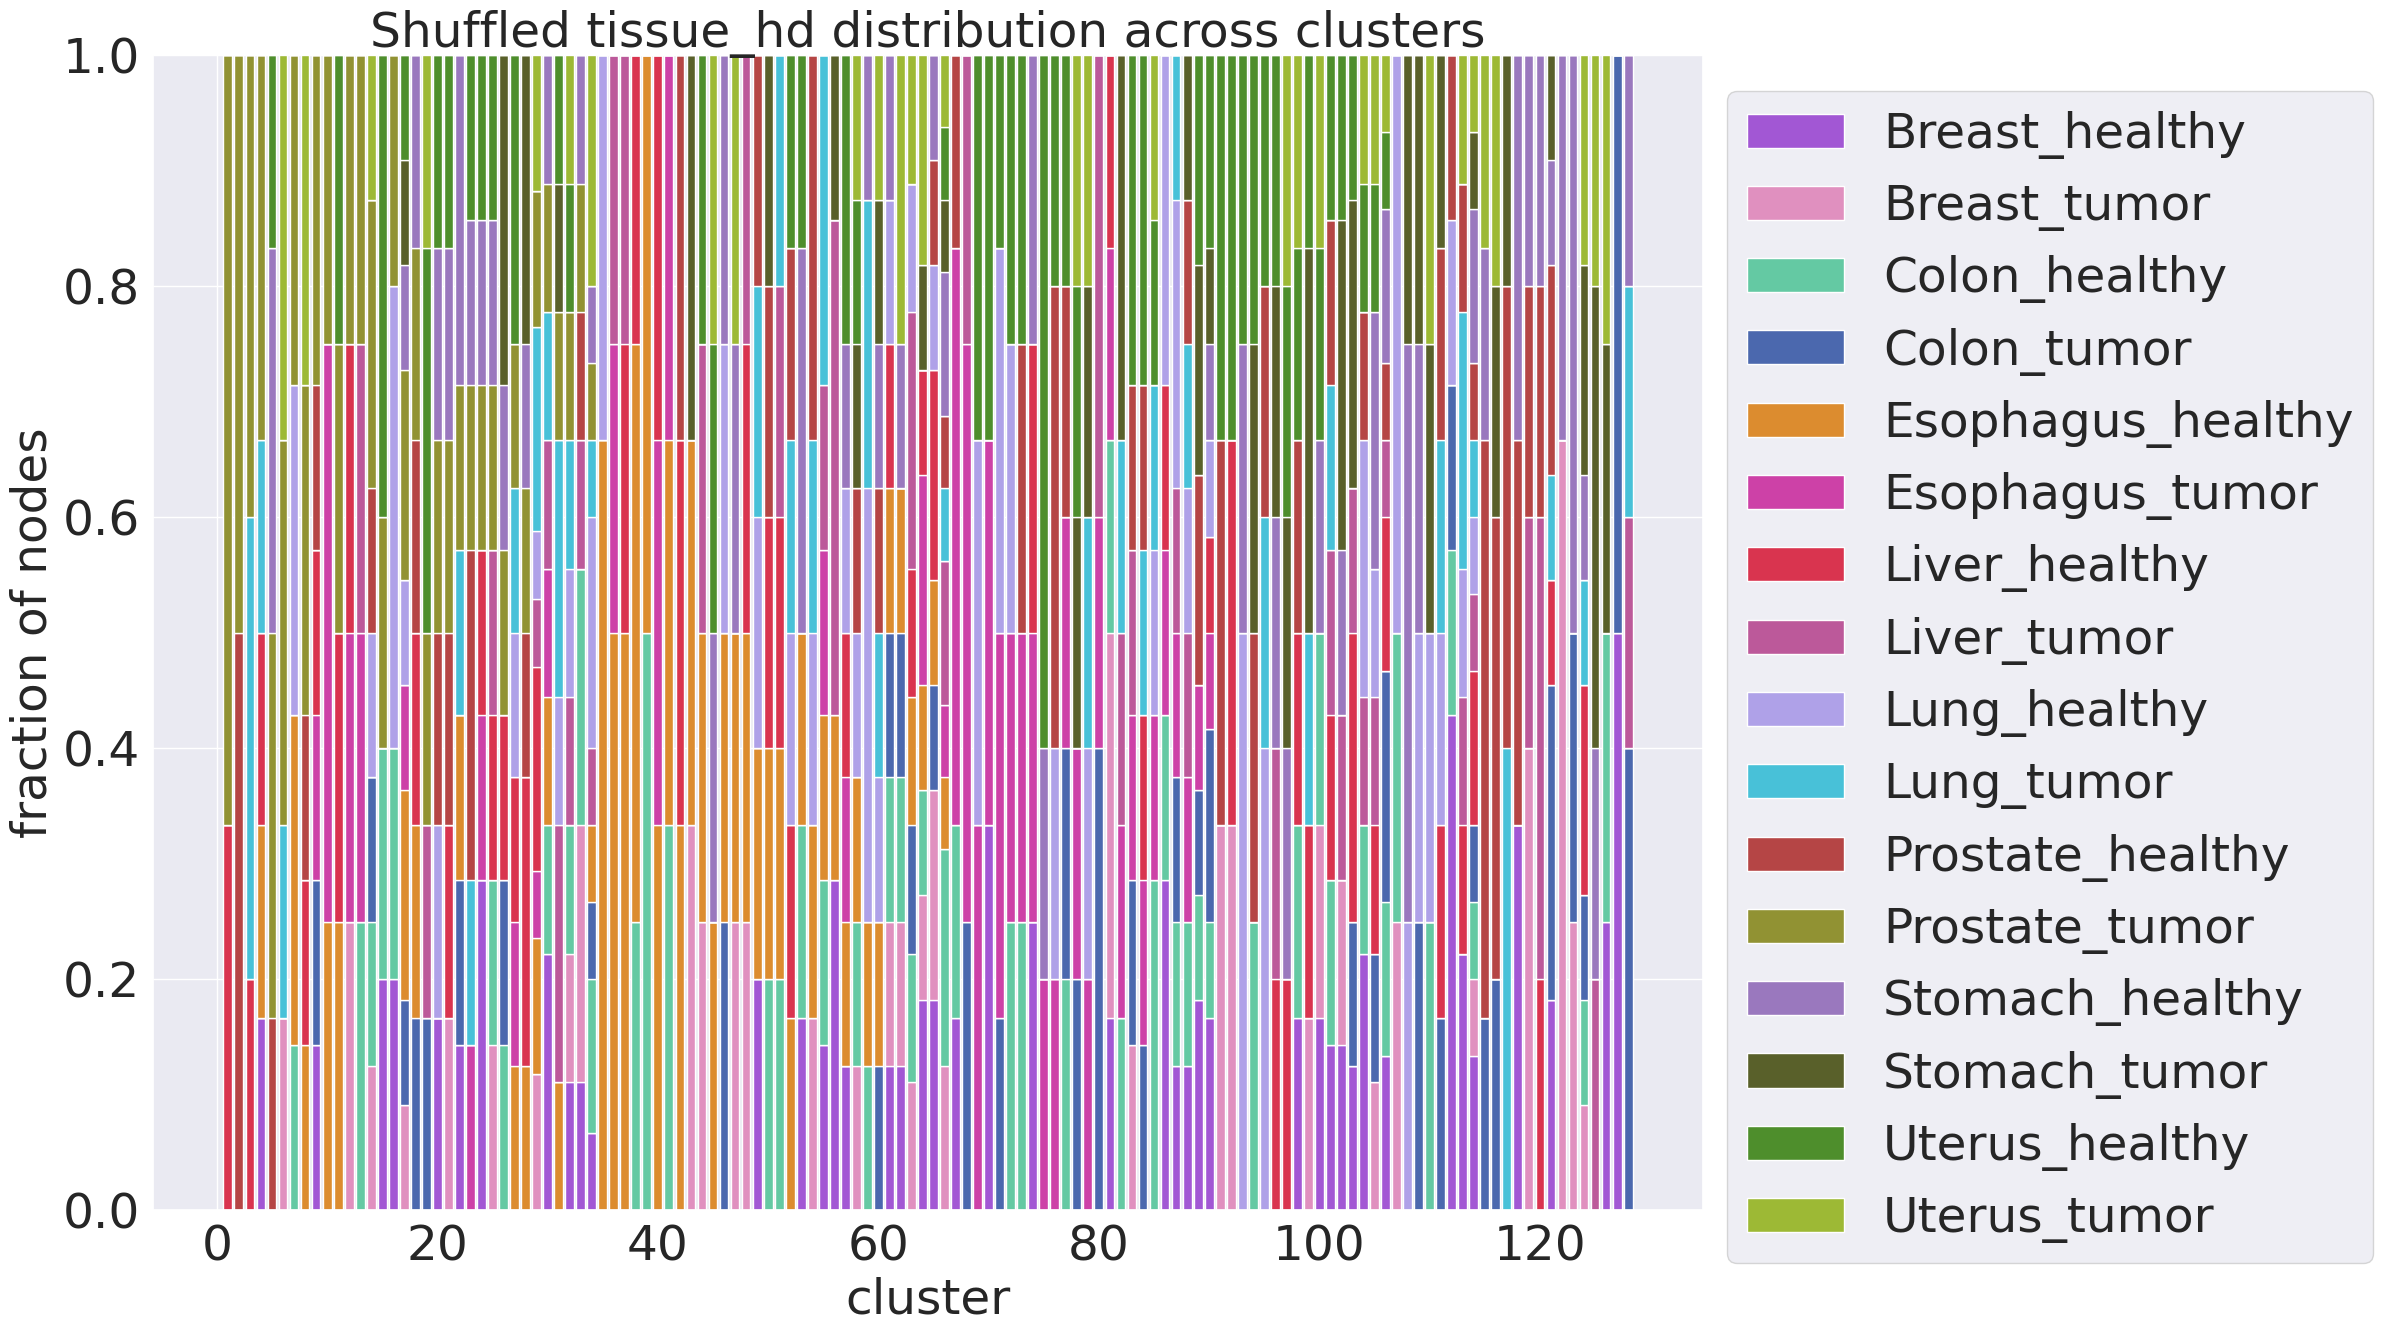

True tissue_hd 0


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


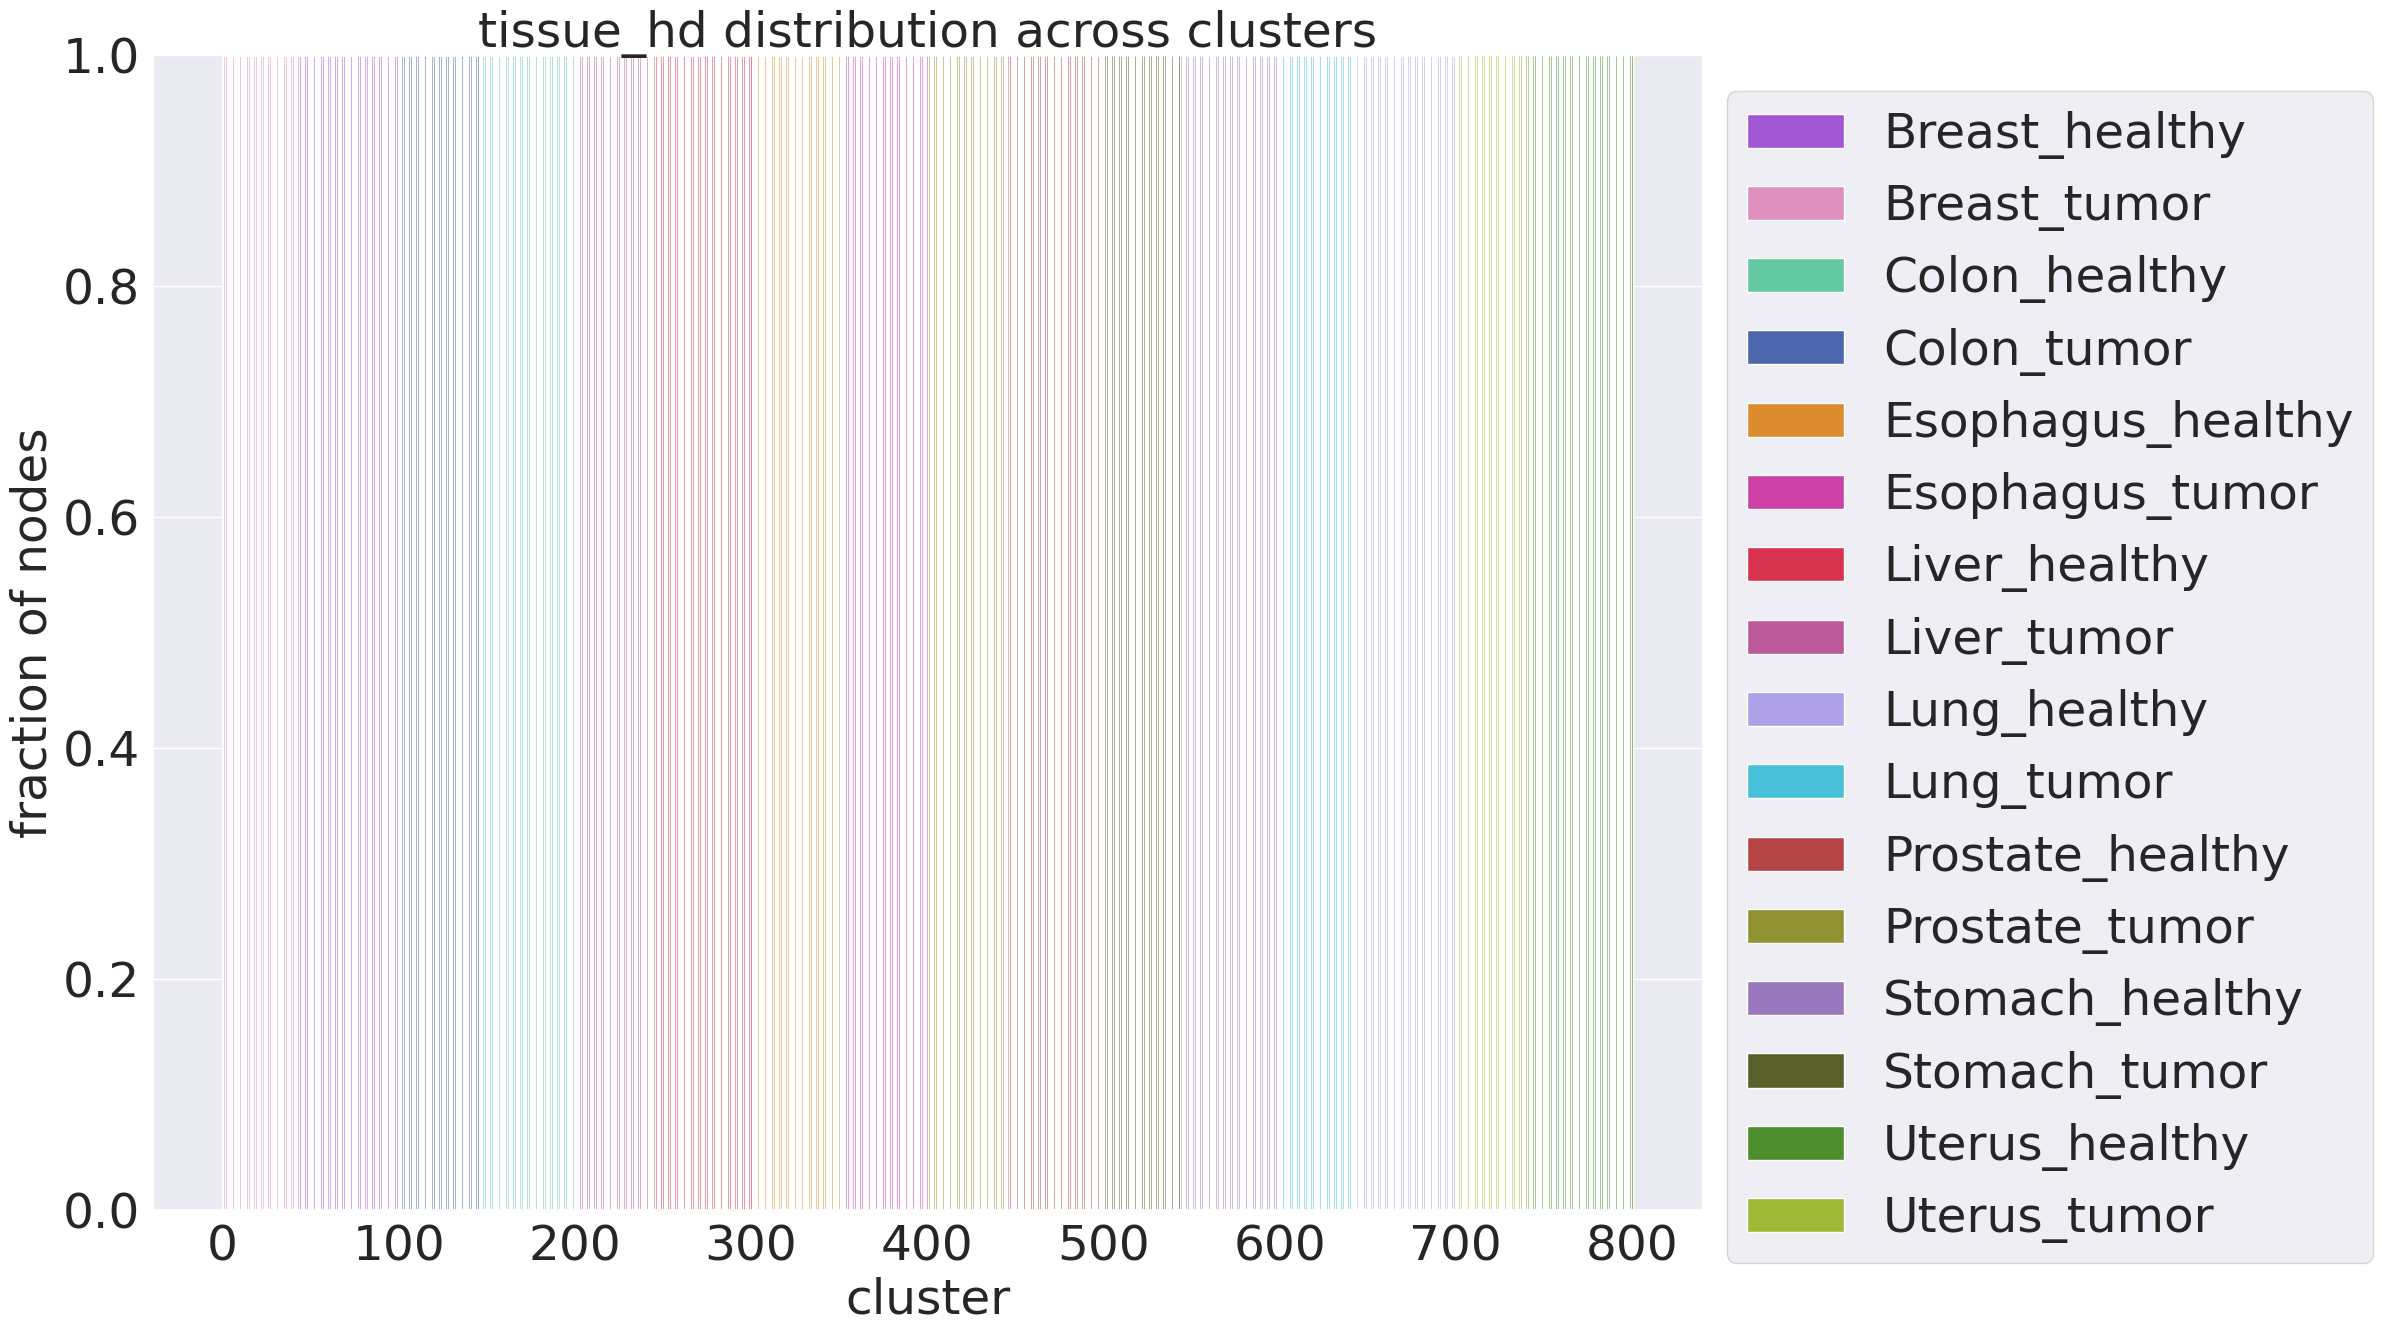

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


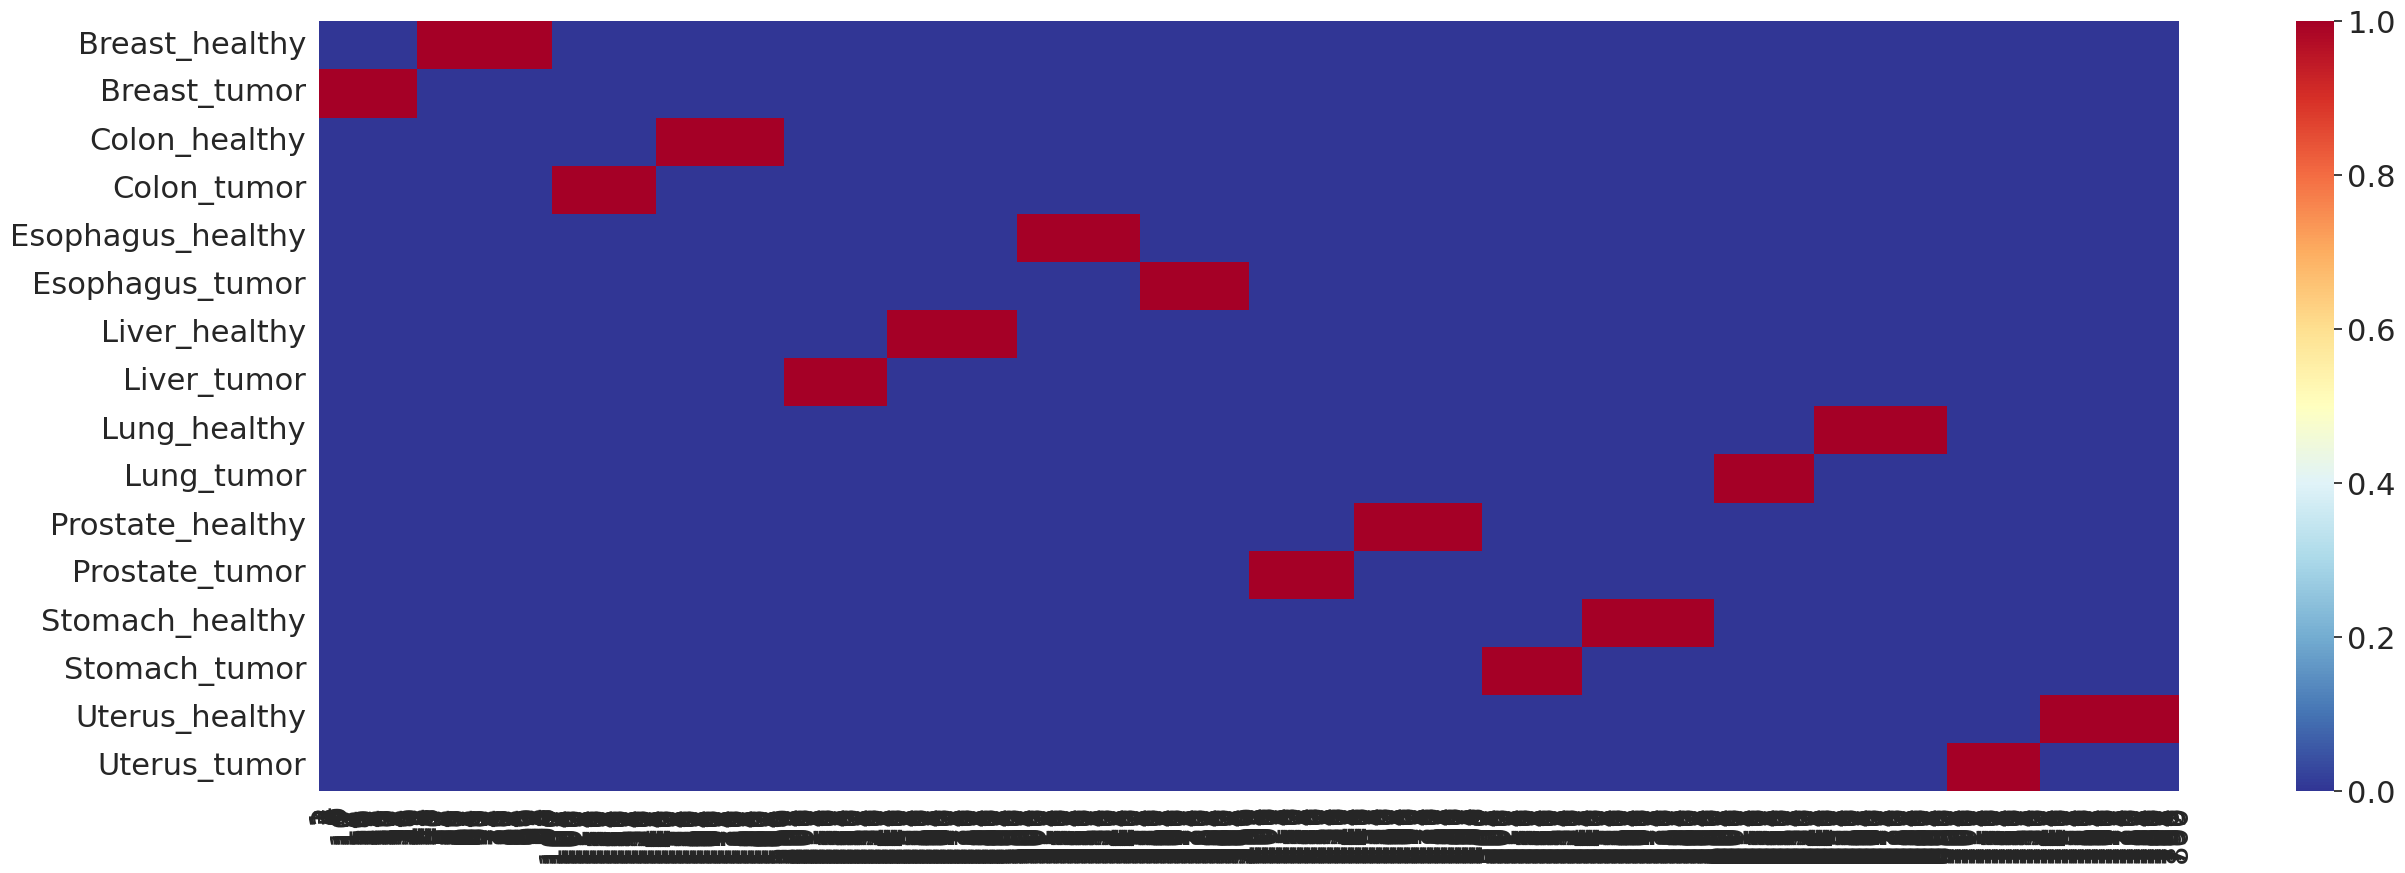

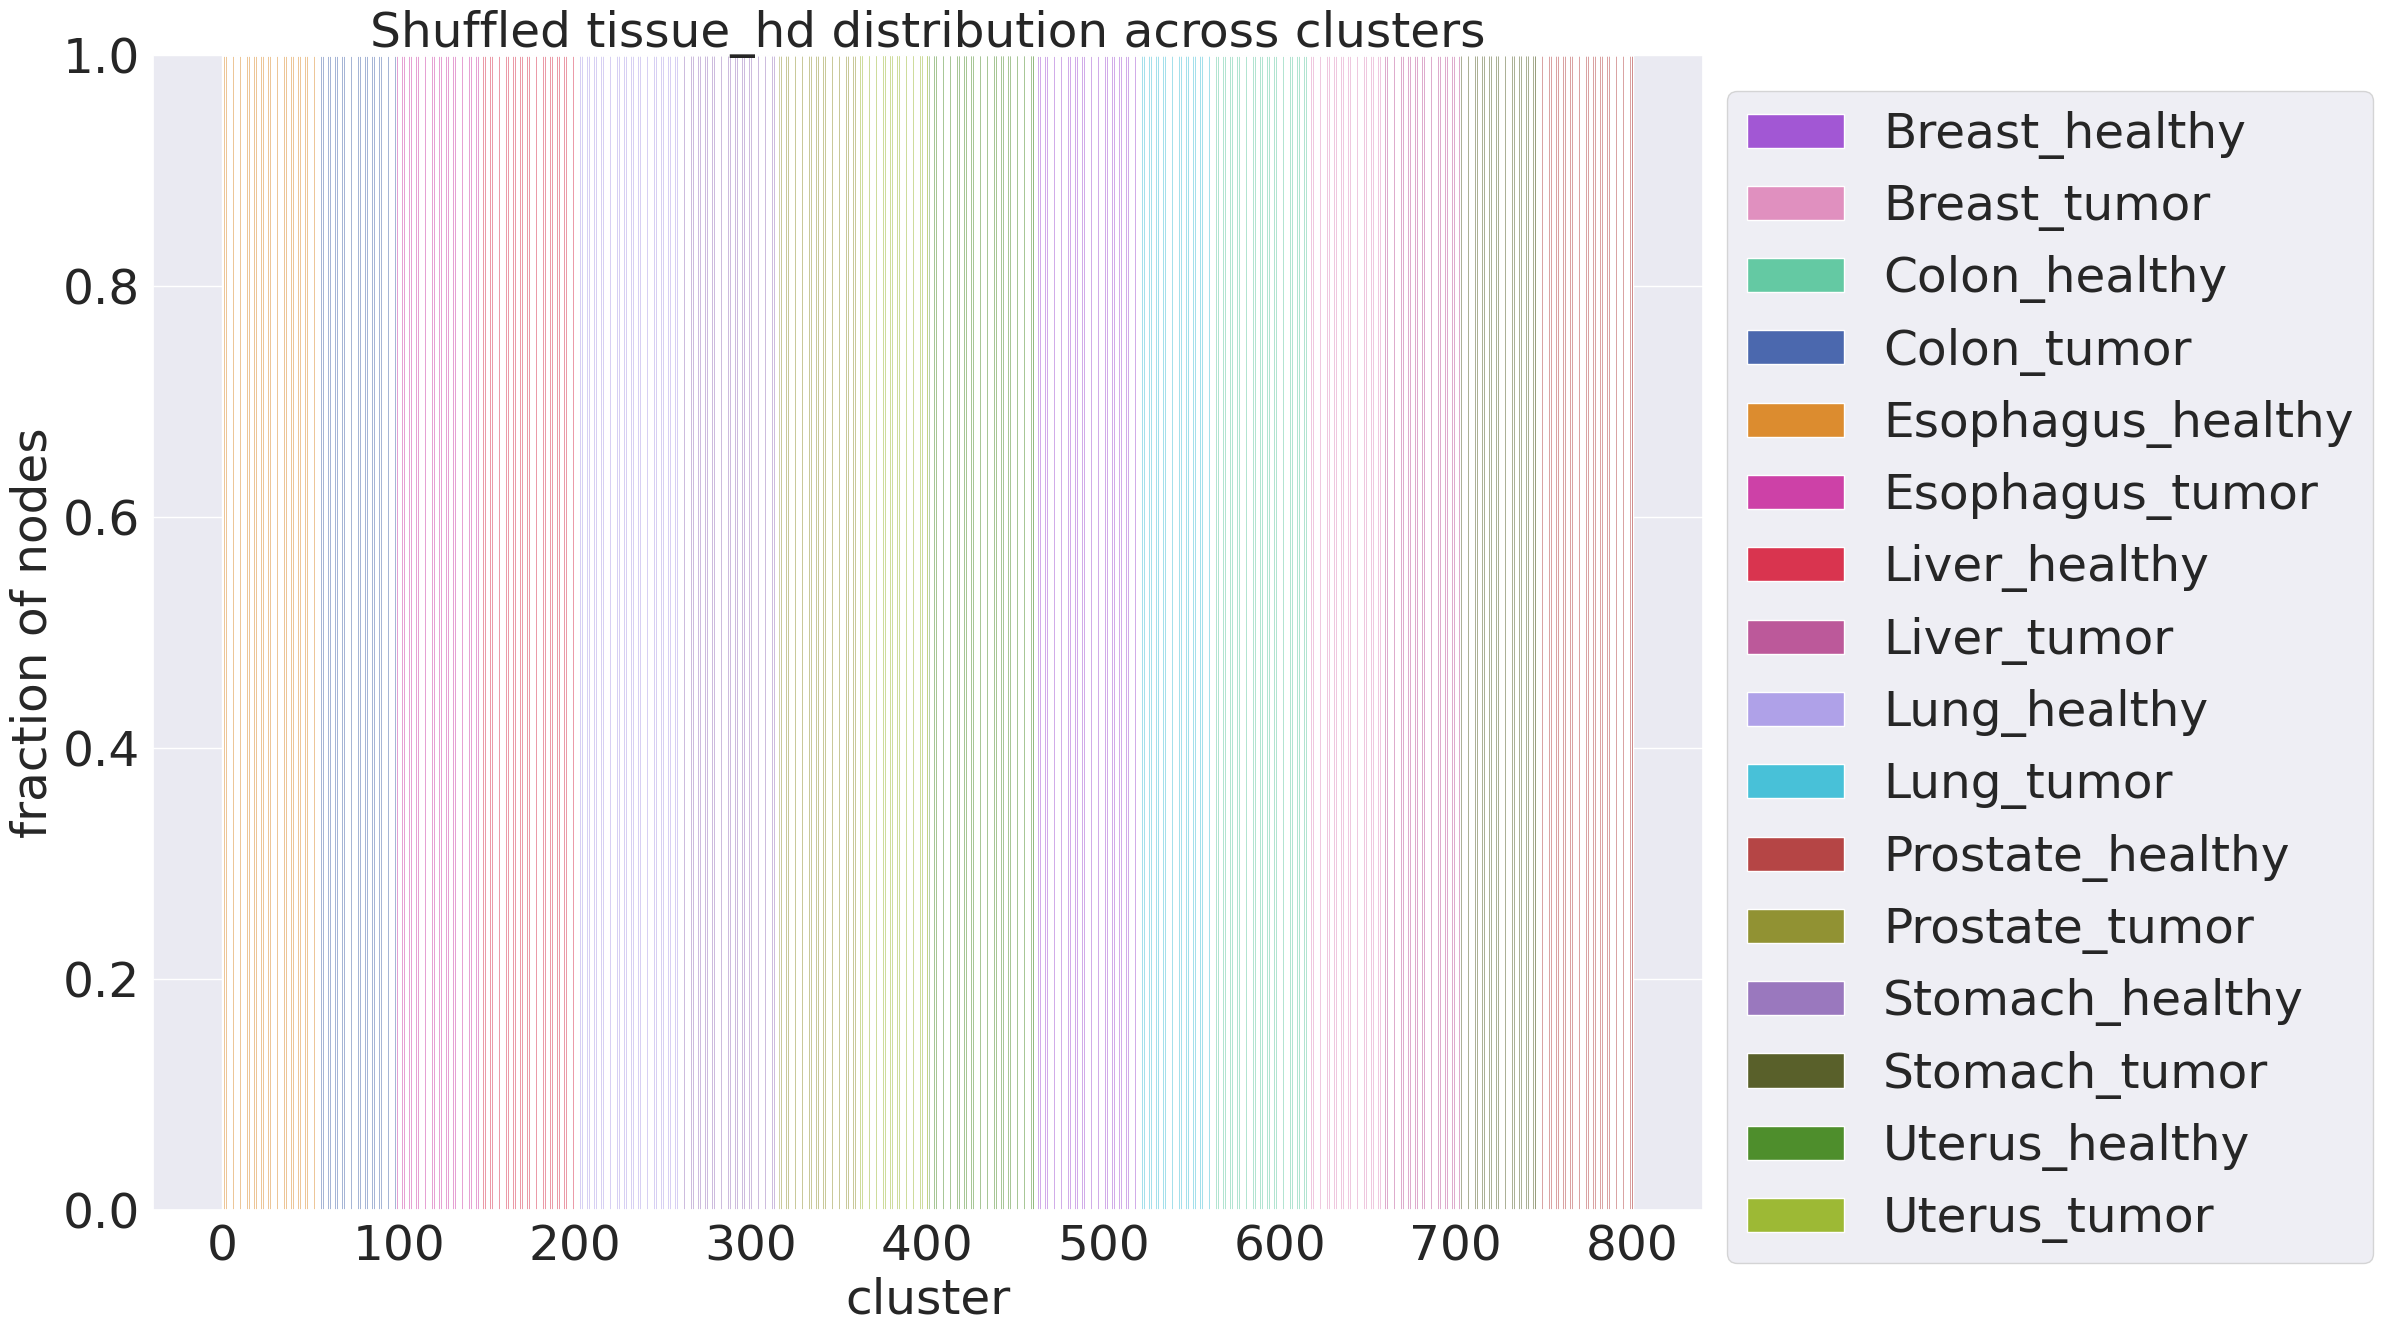

False tissue_hd 4


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


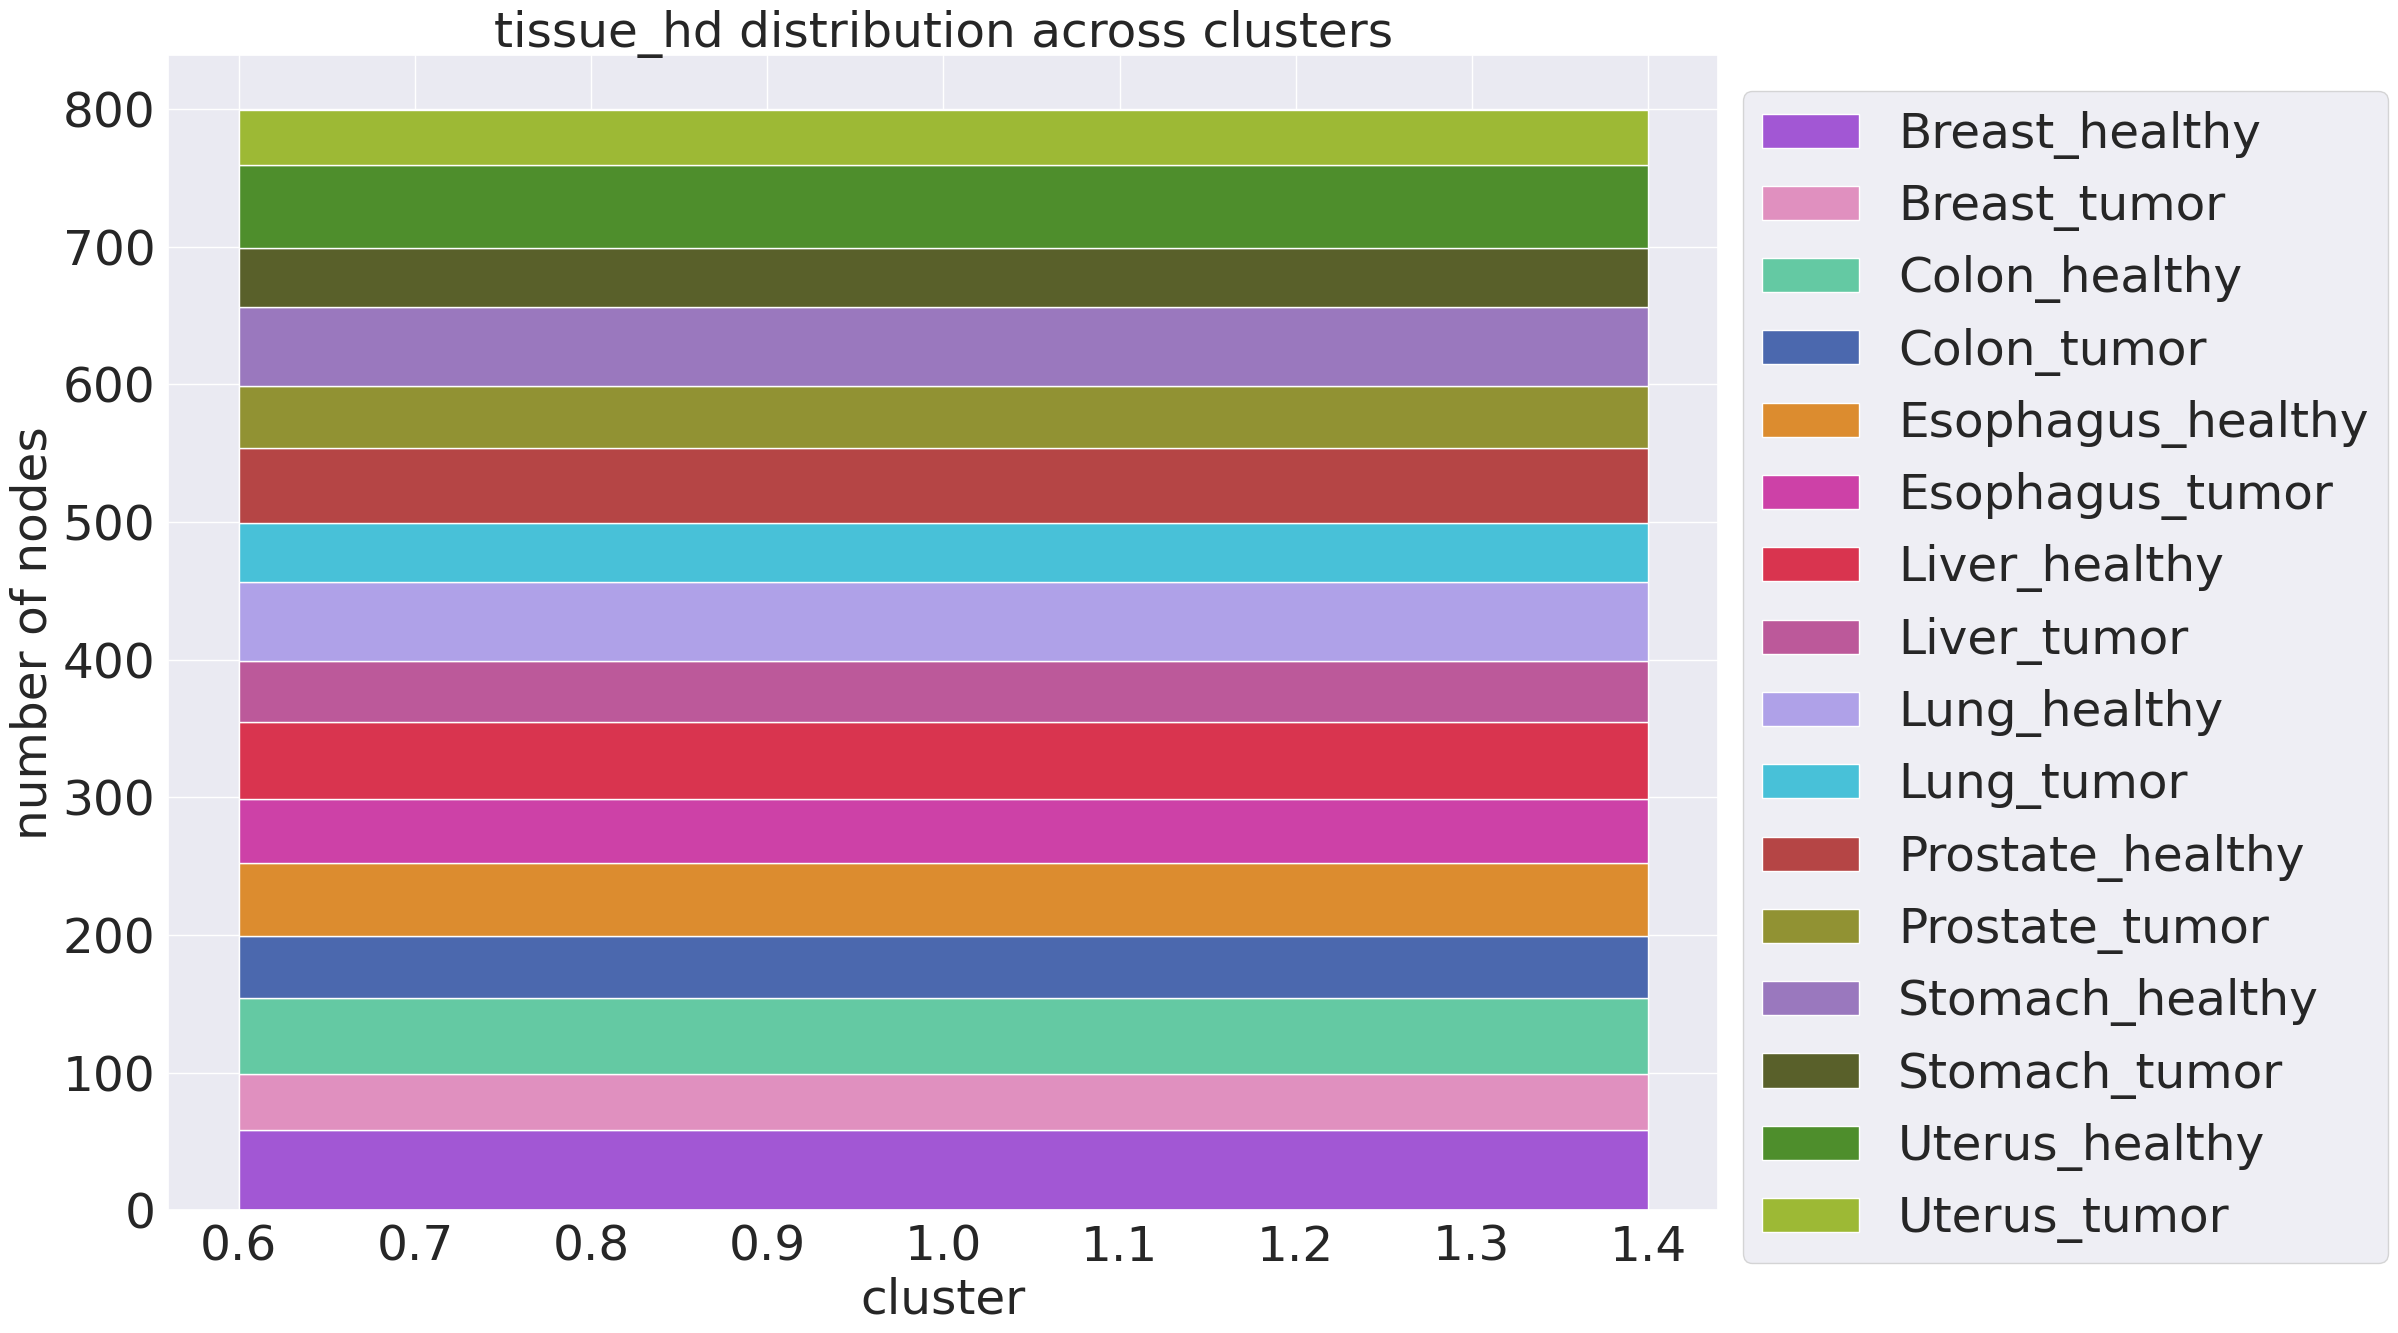

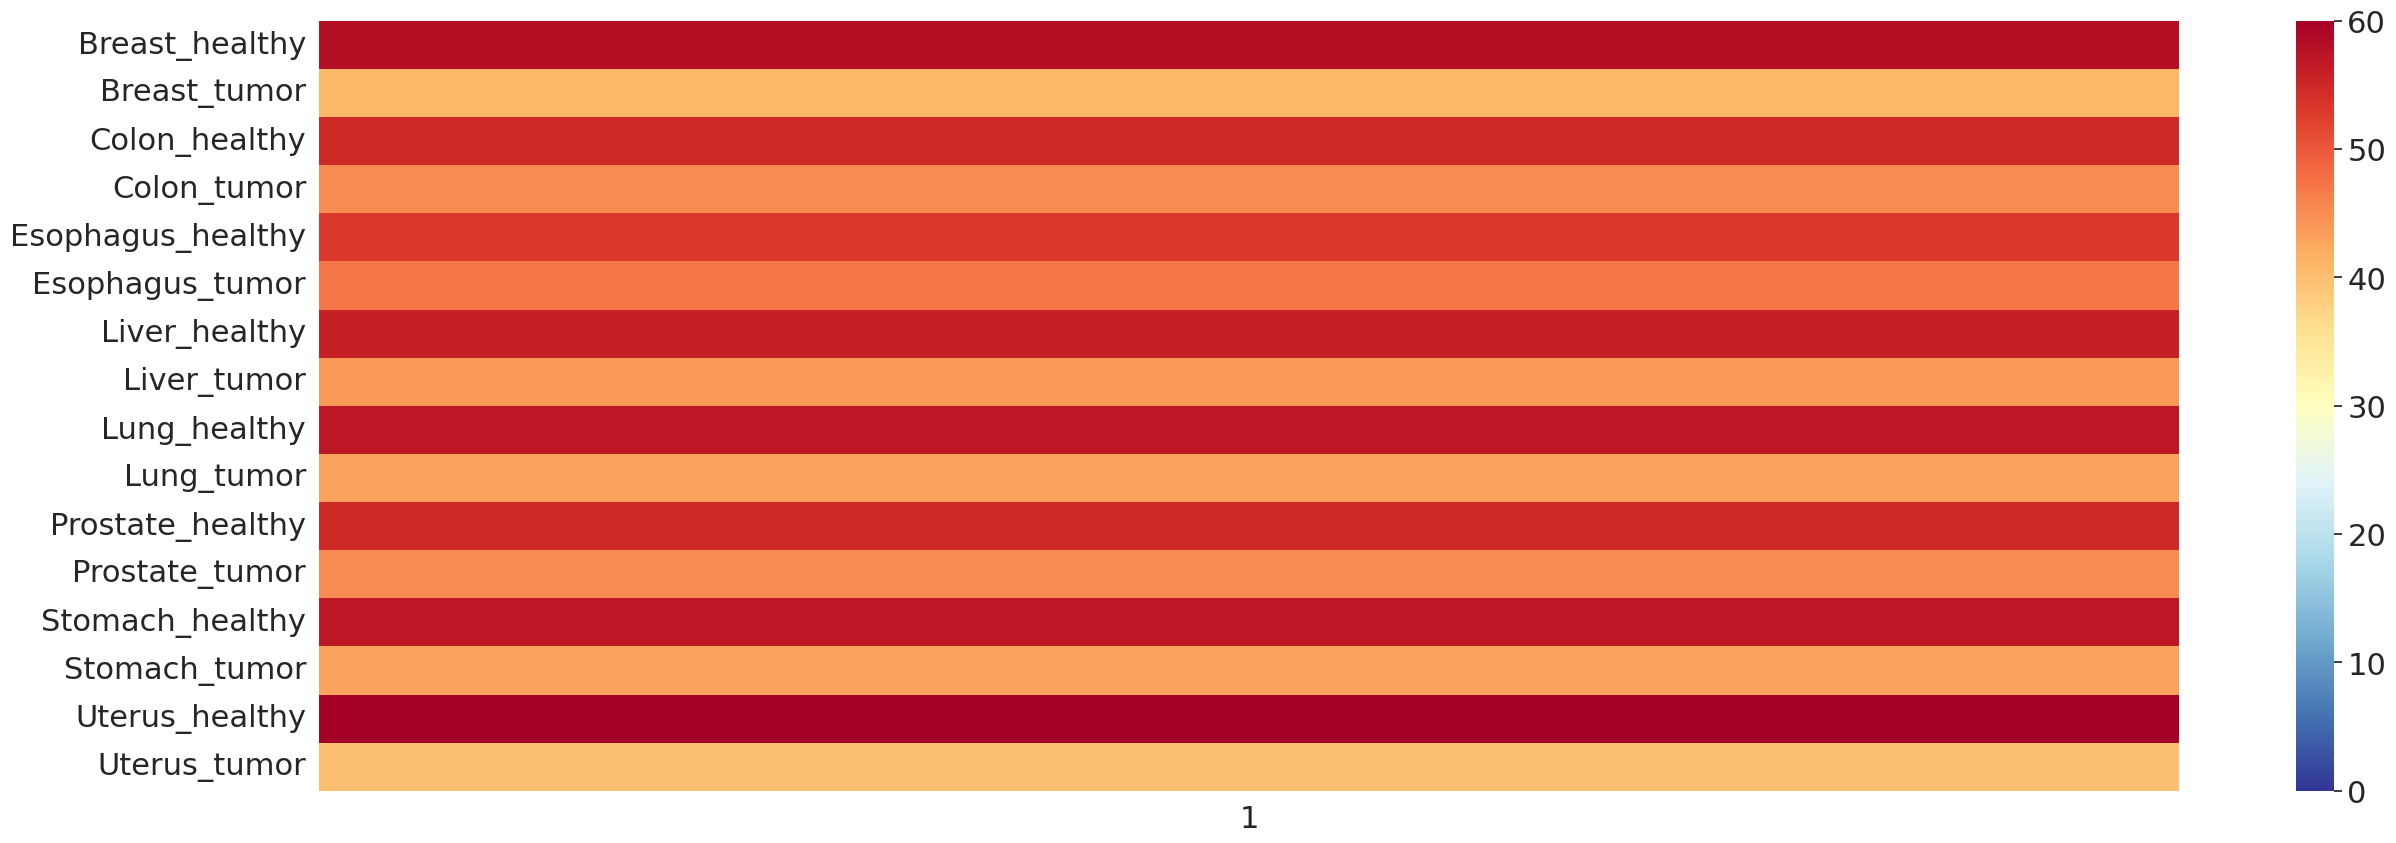

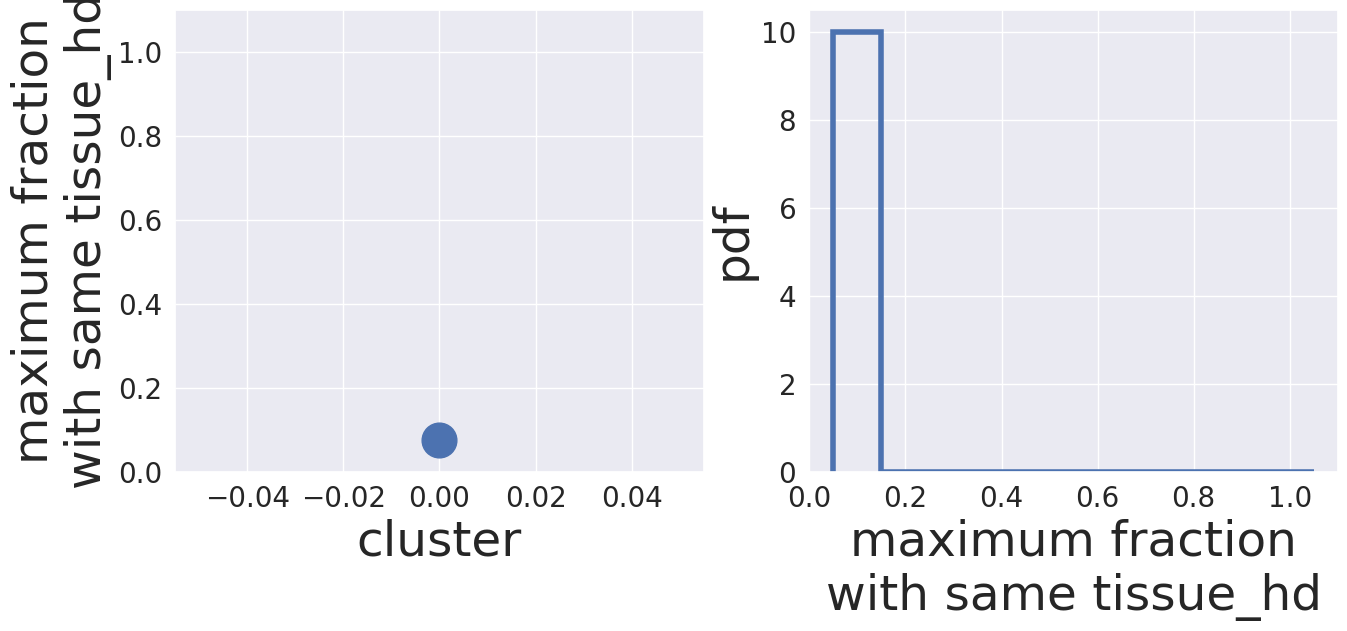

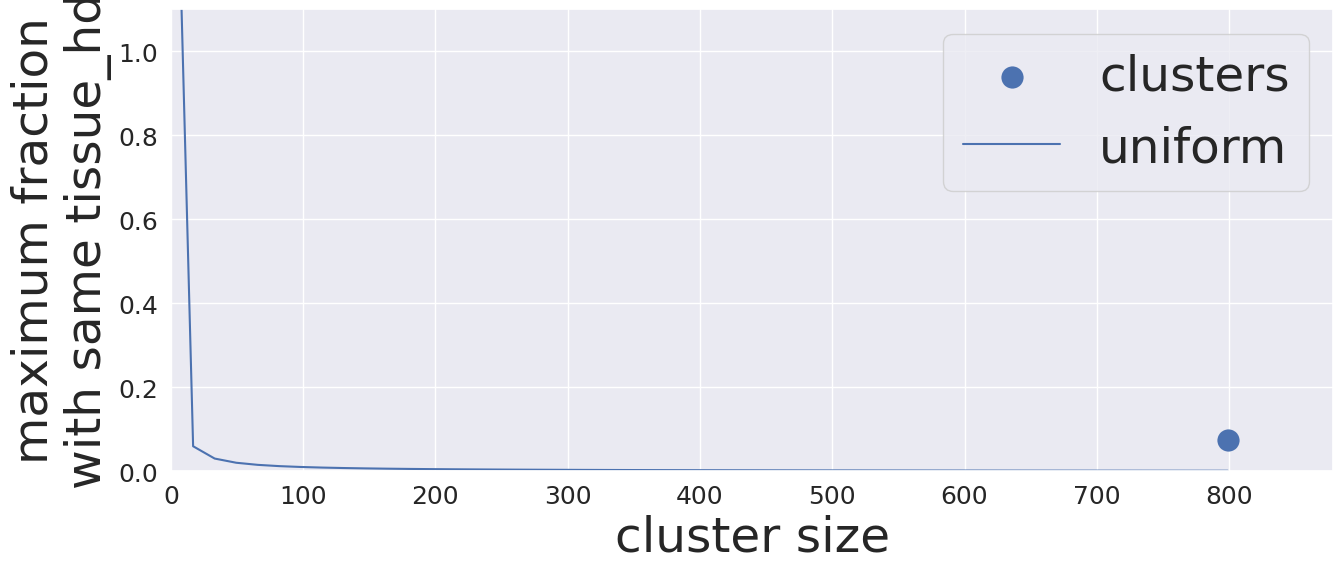

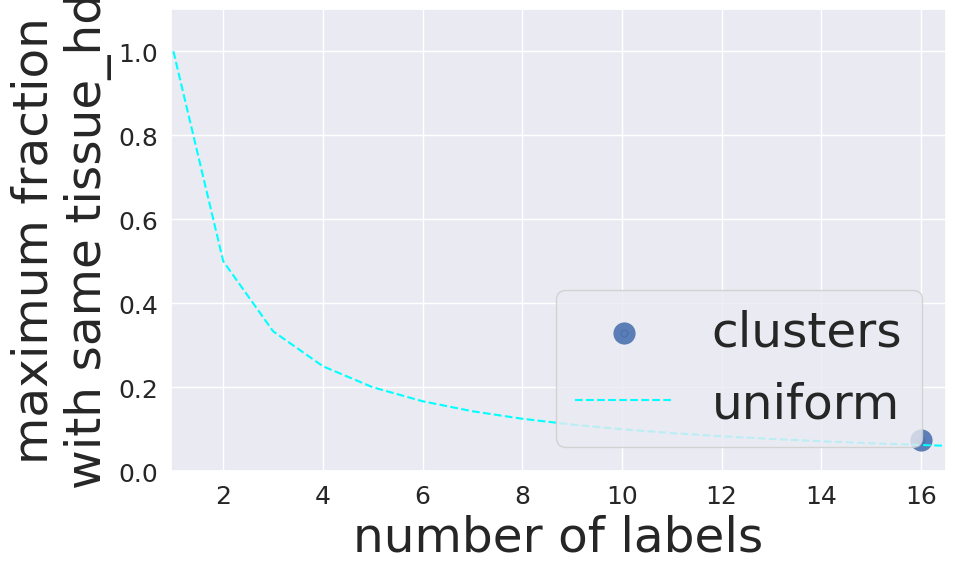

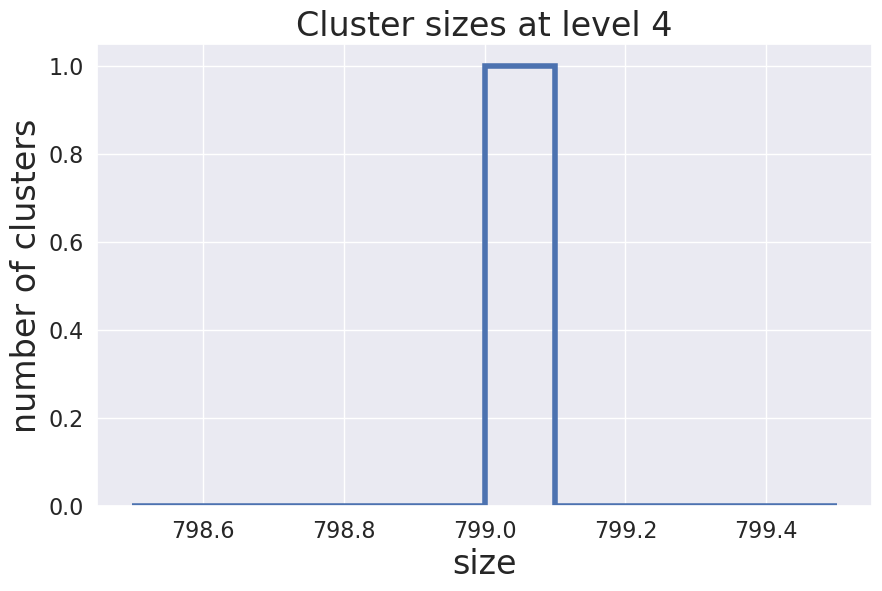

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


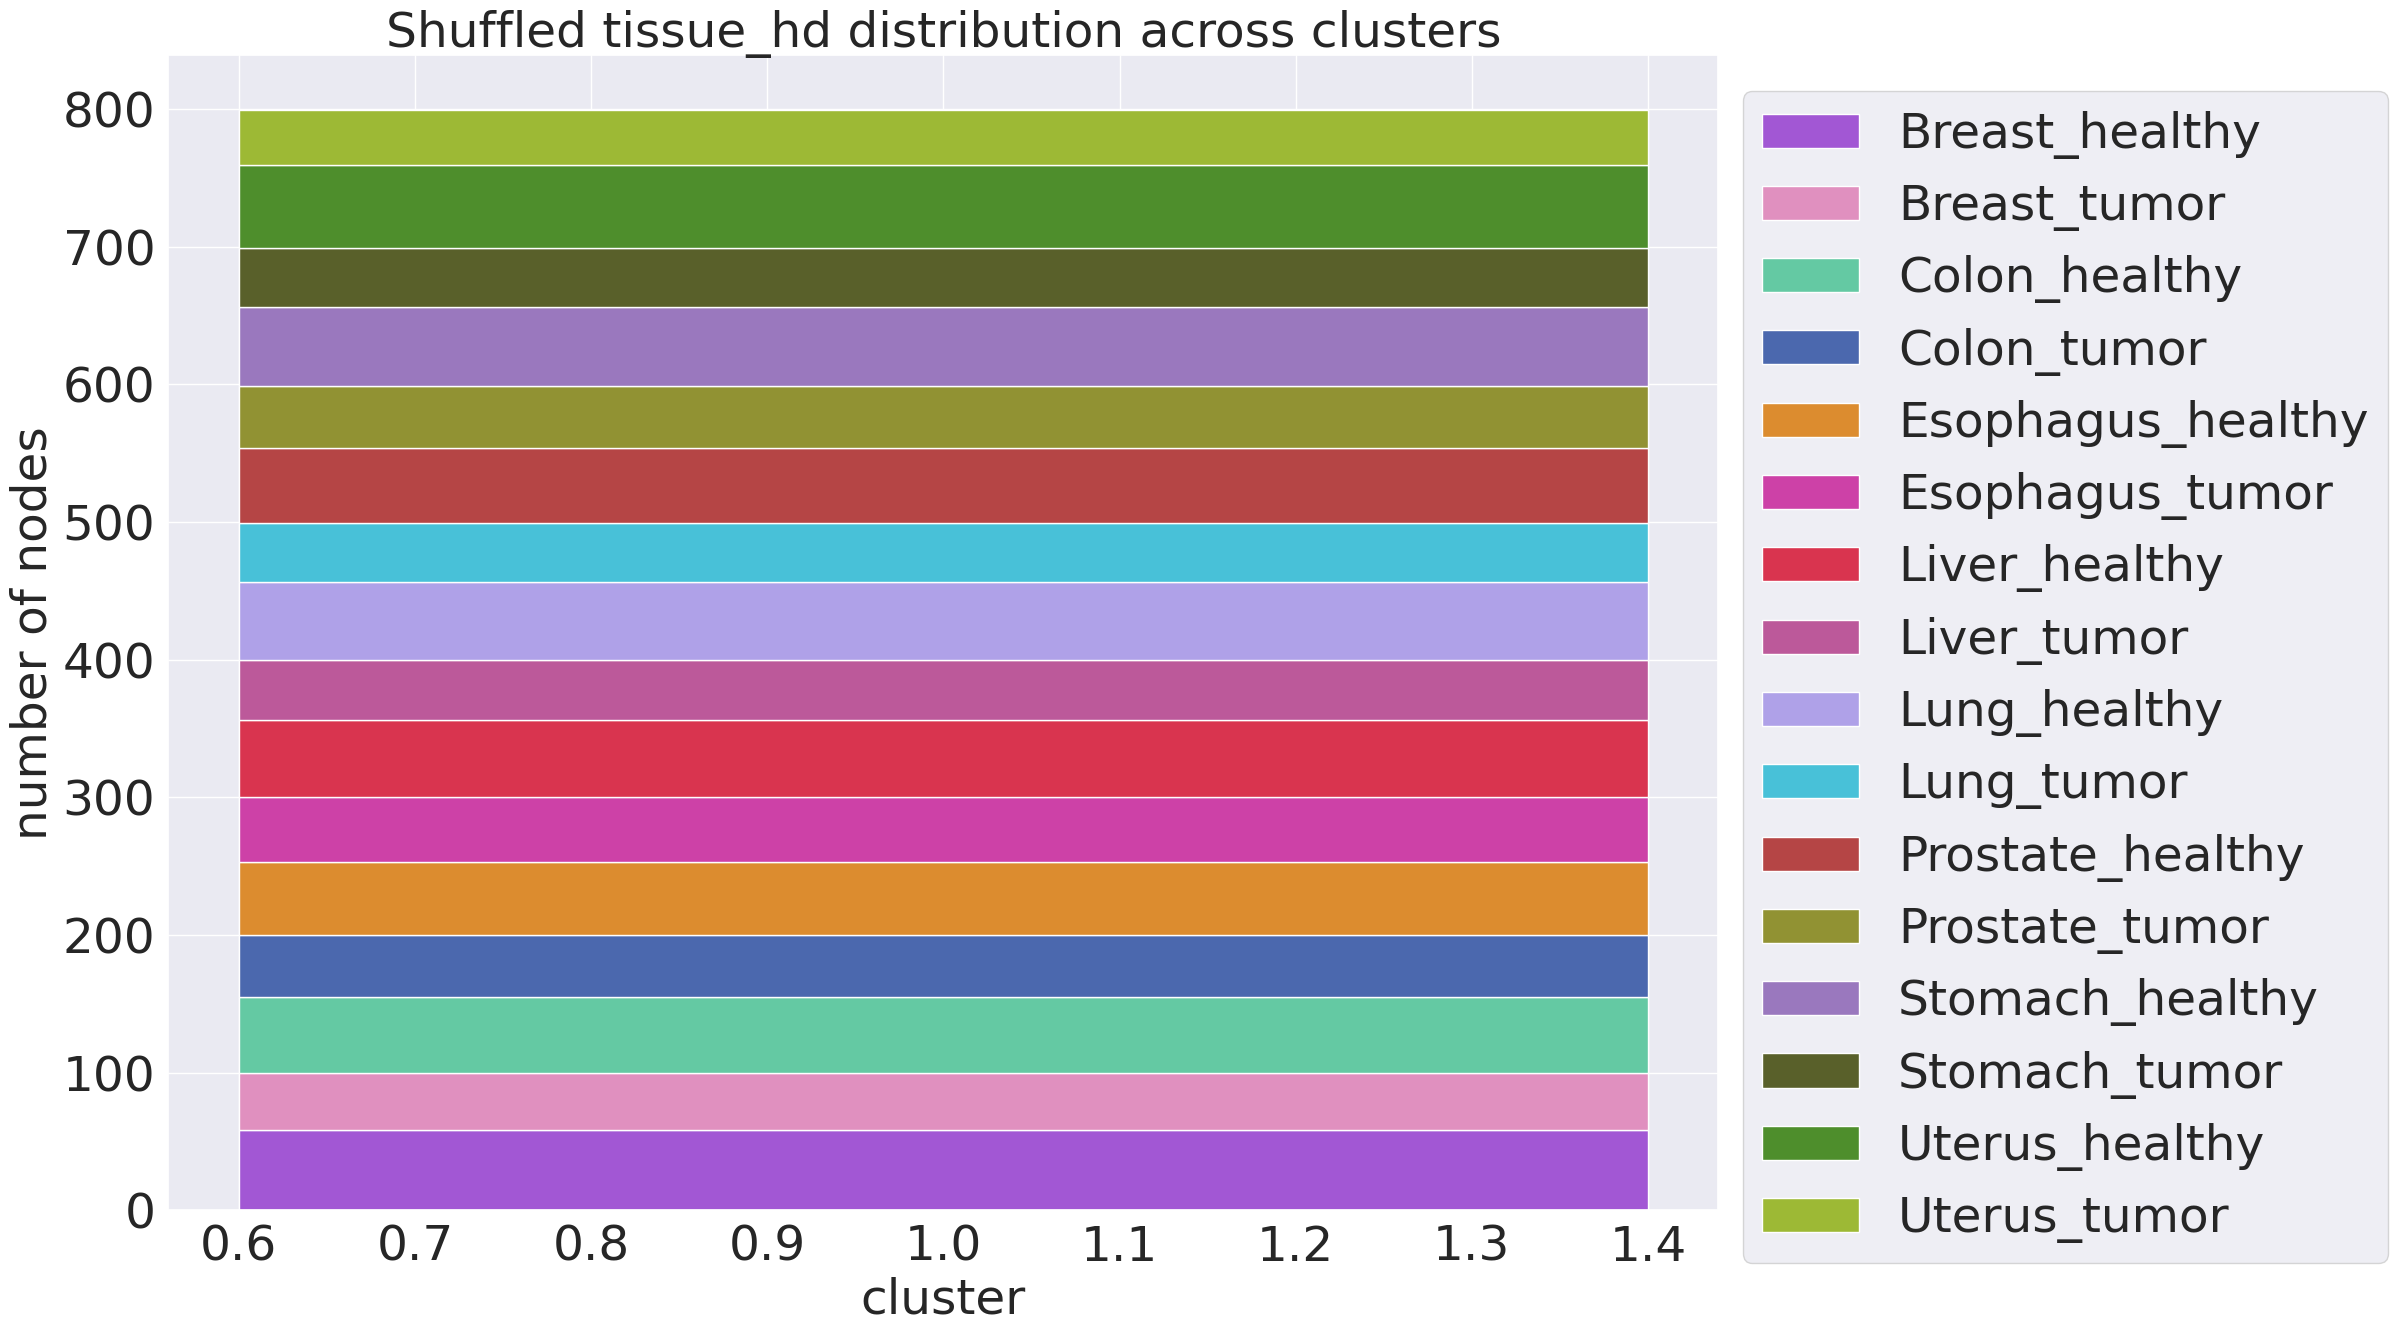

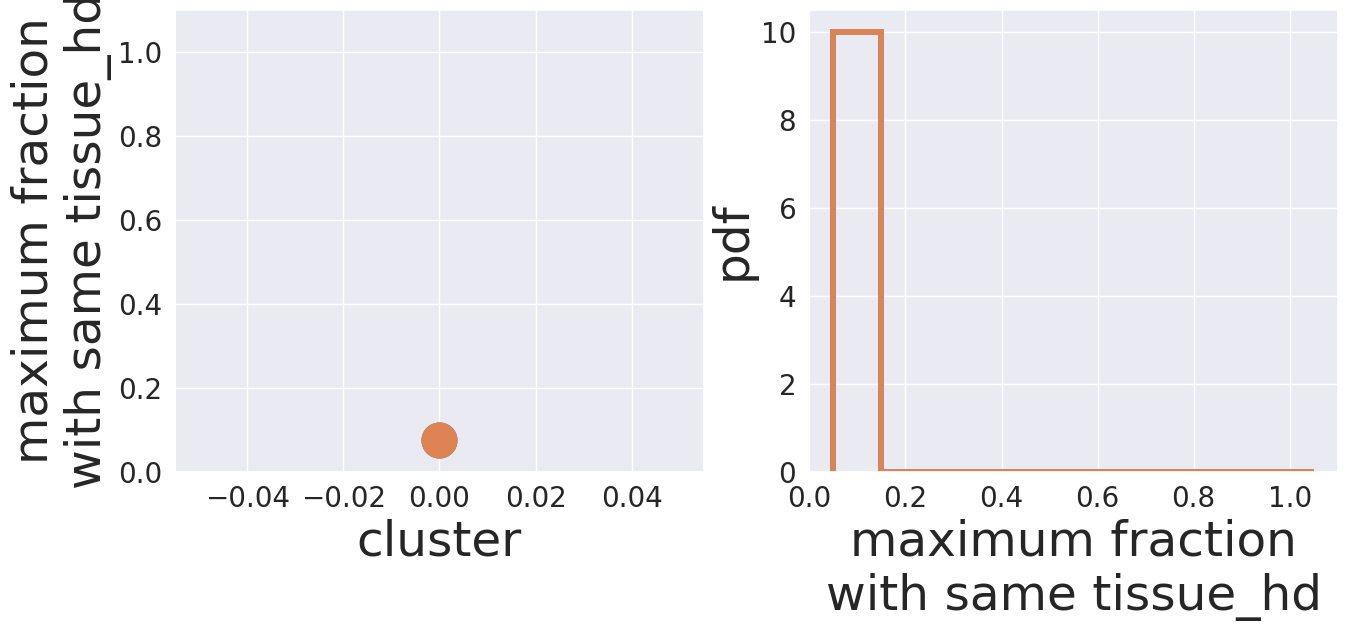

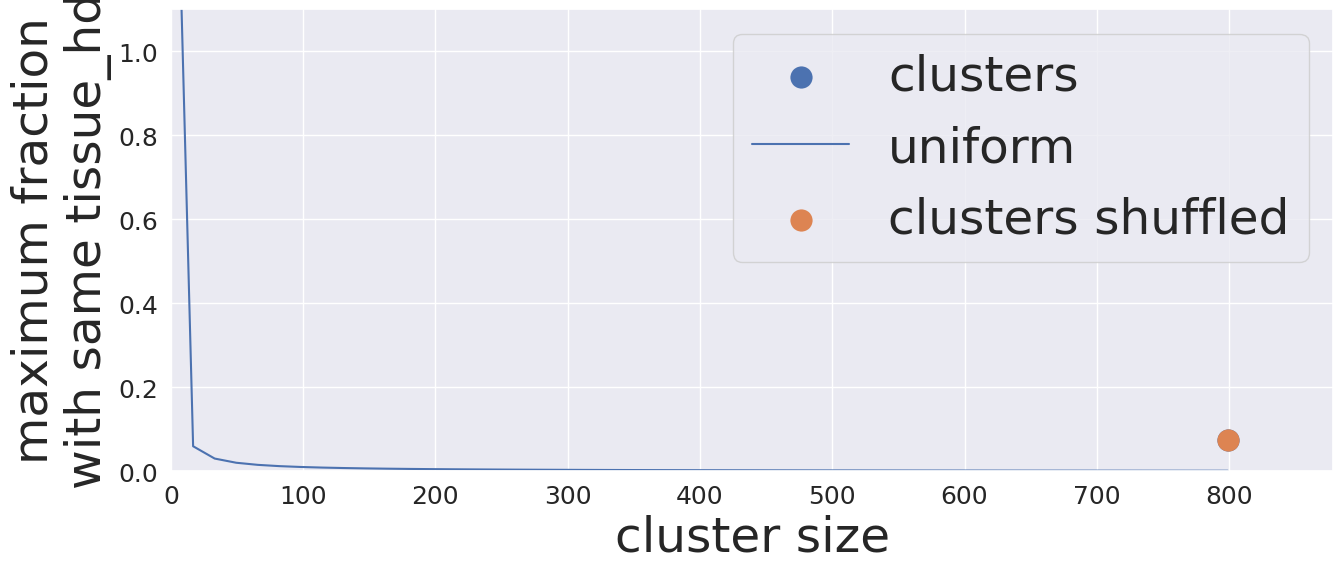

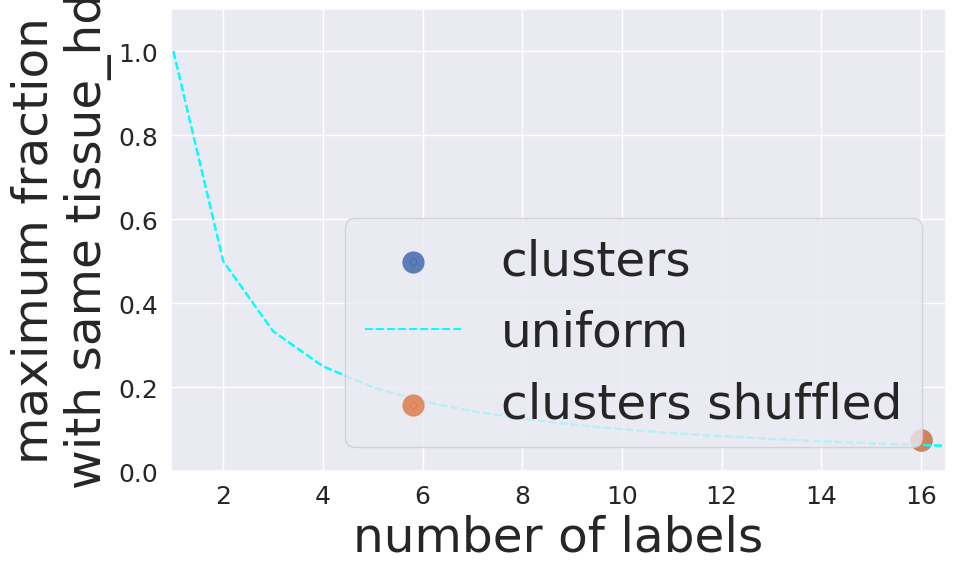

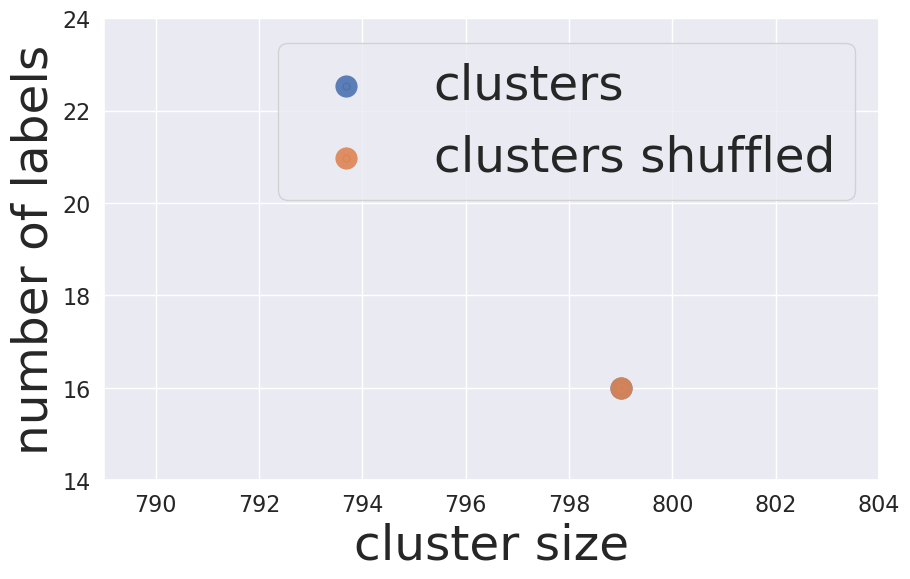

False tissue_hd 3


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


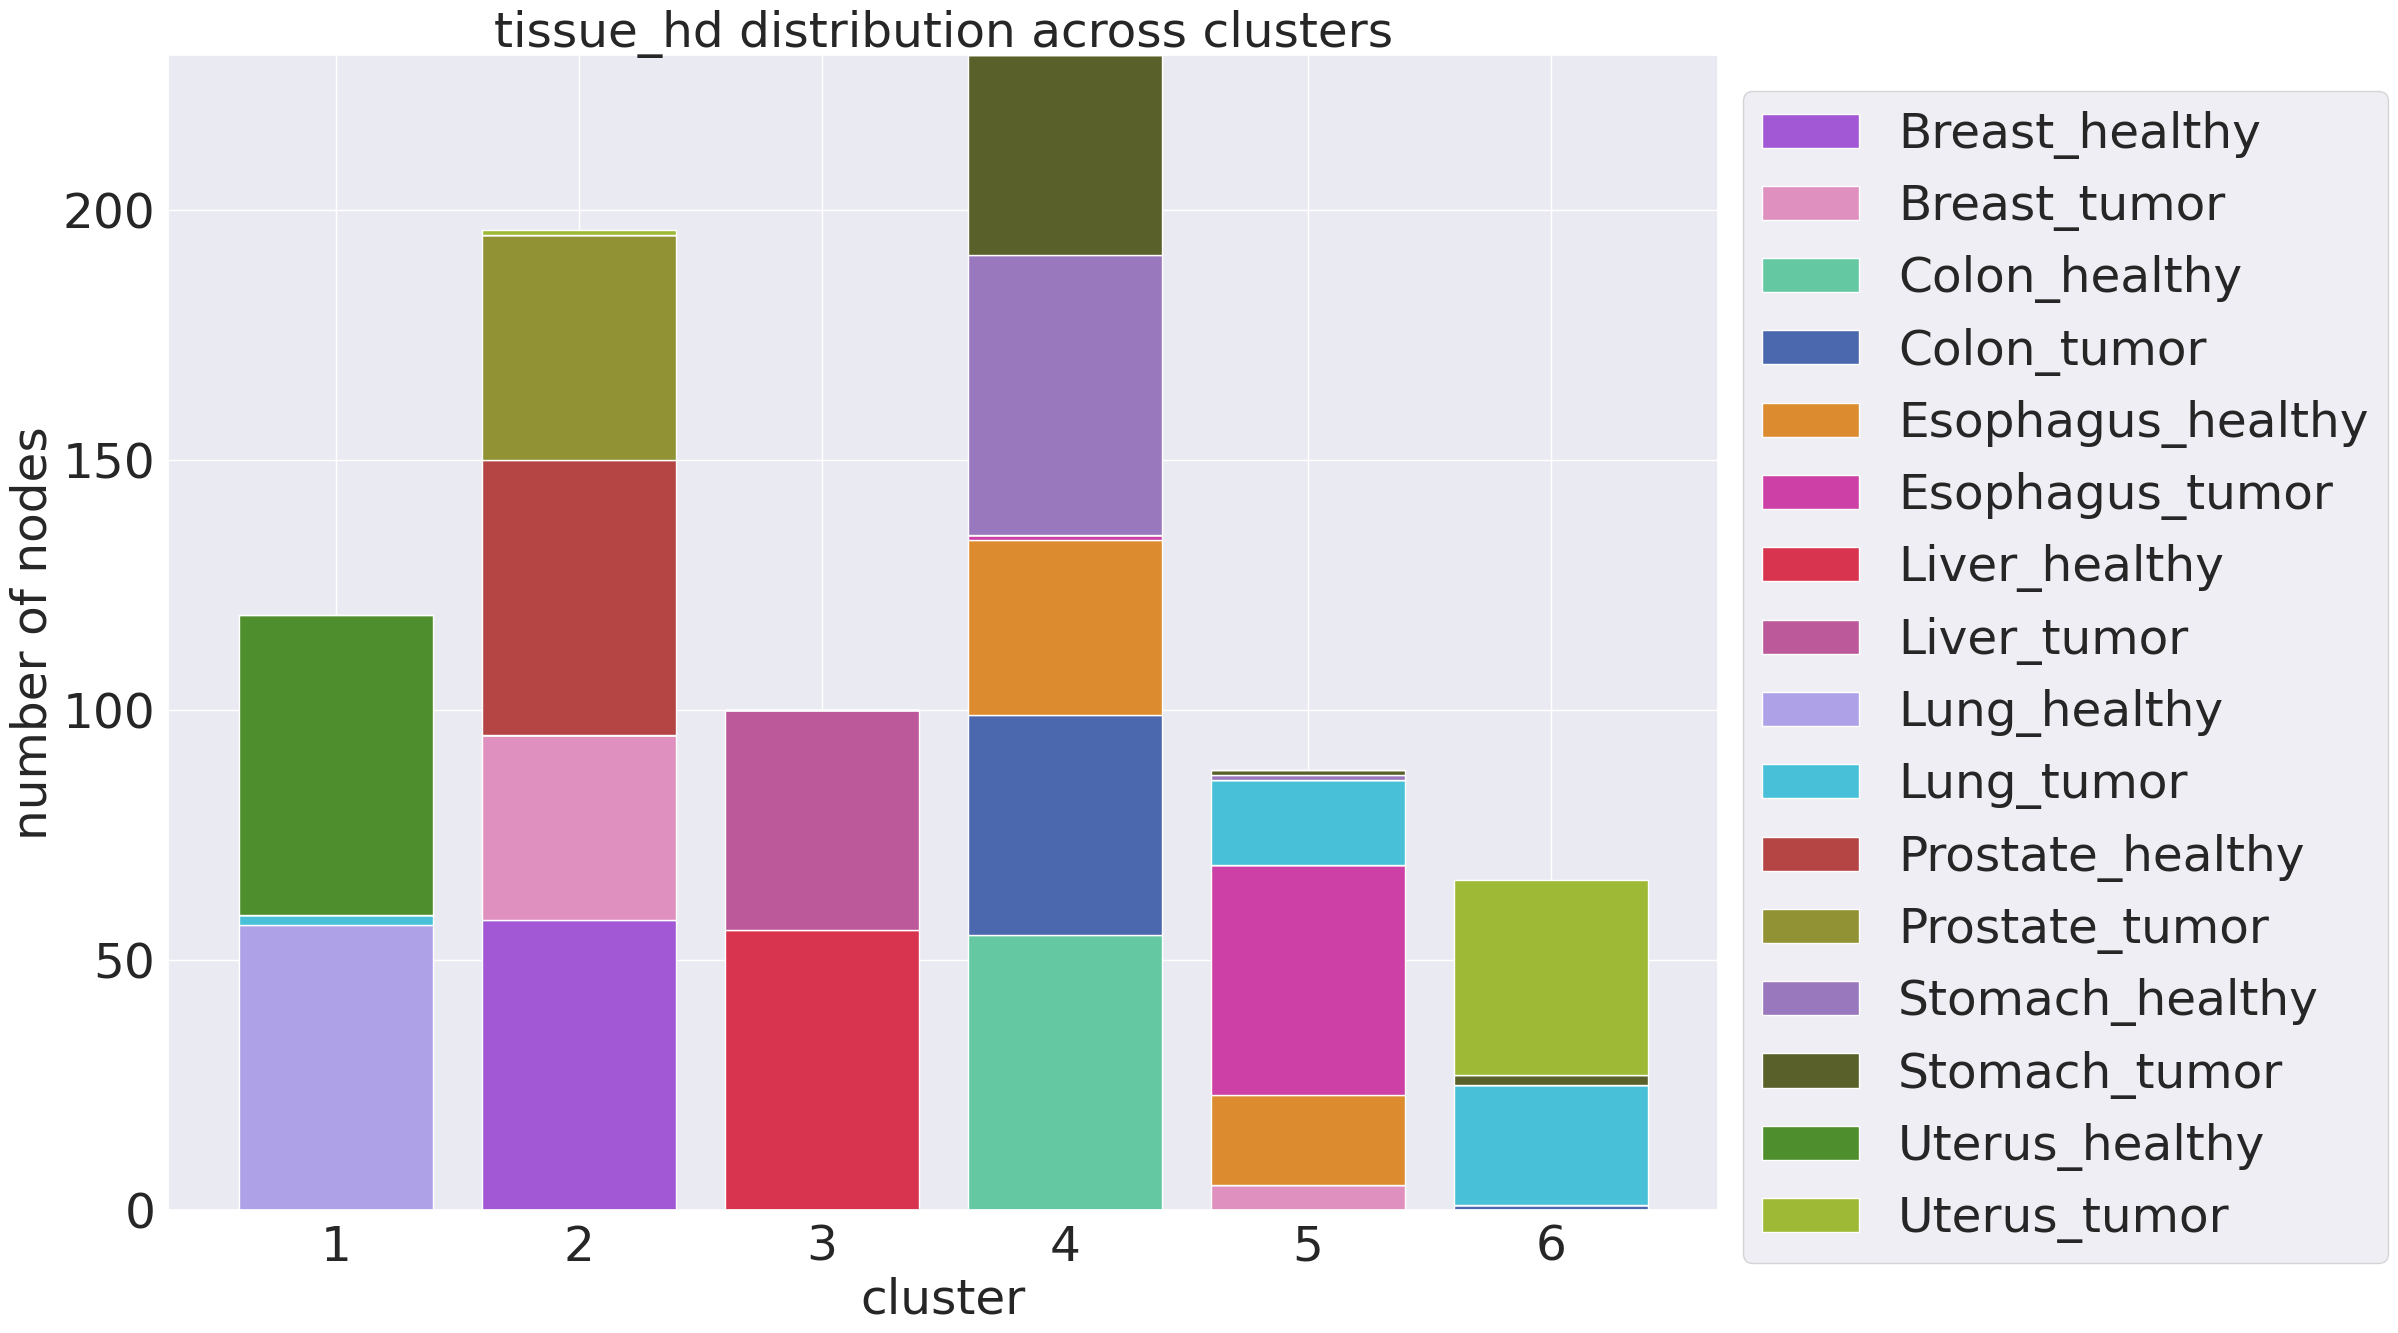

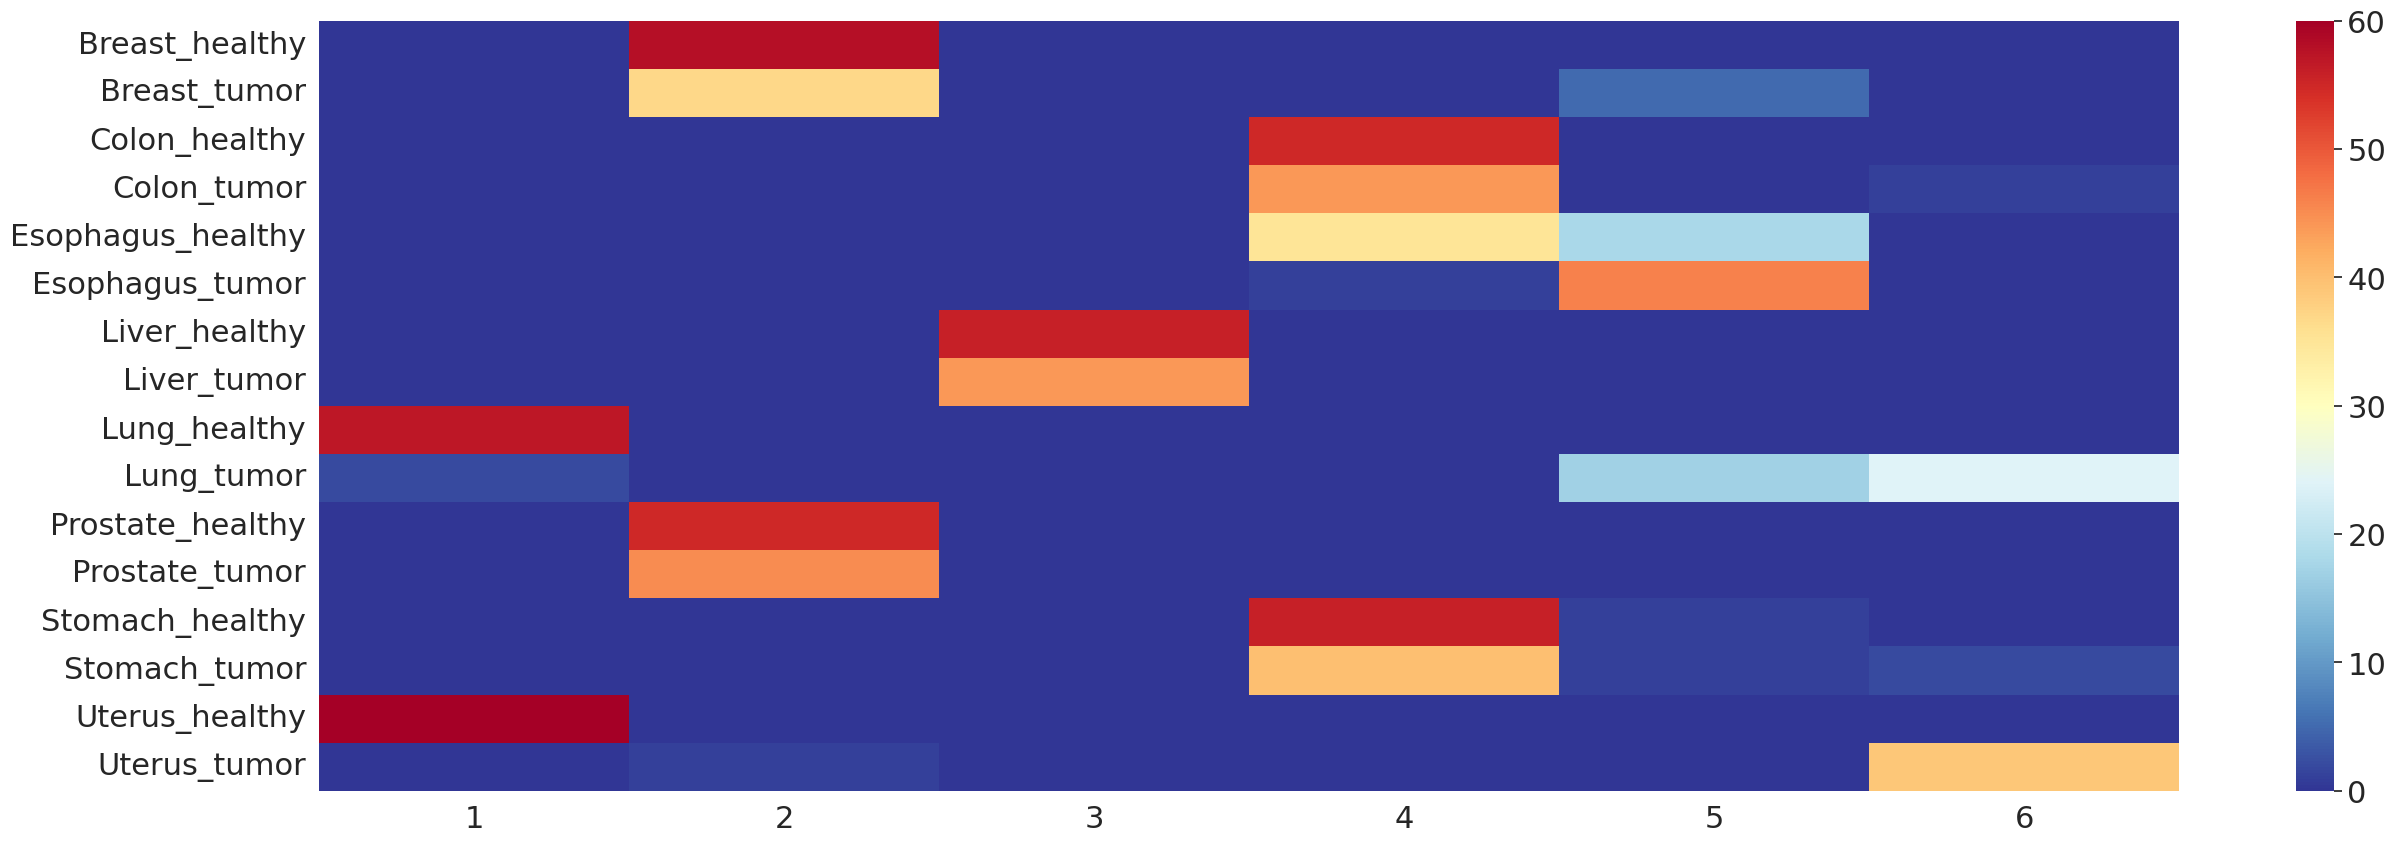

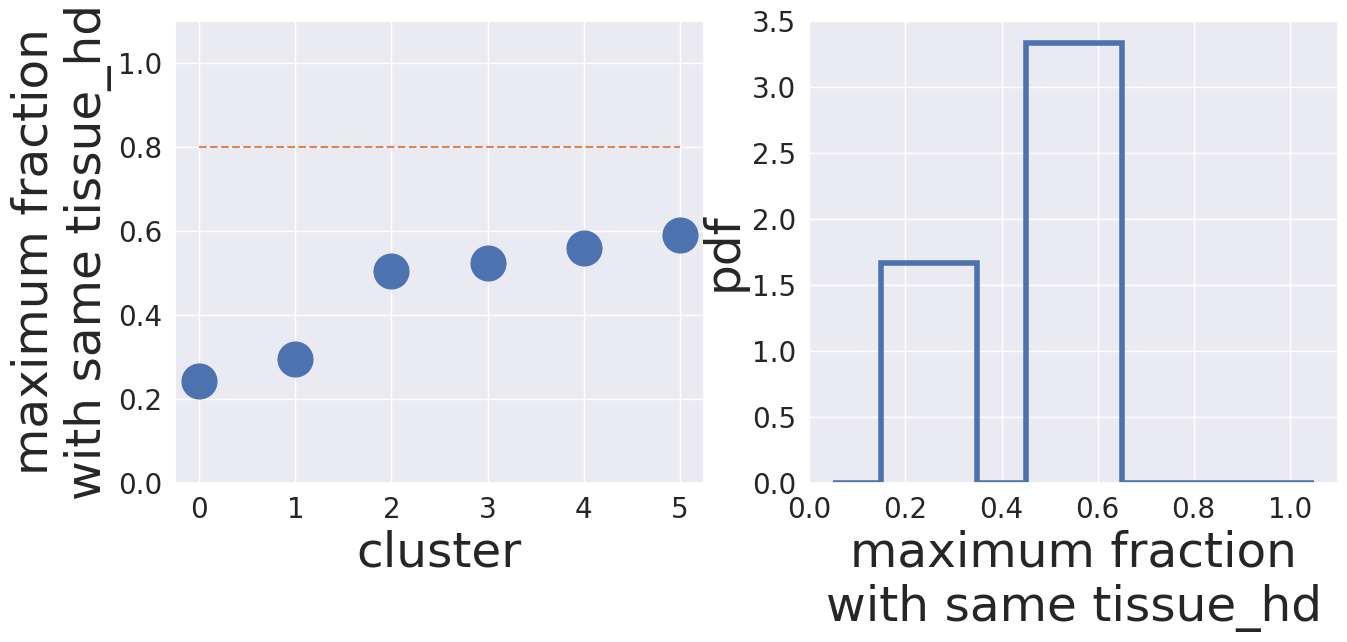

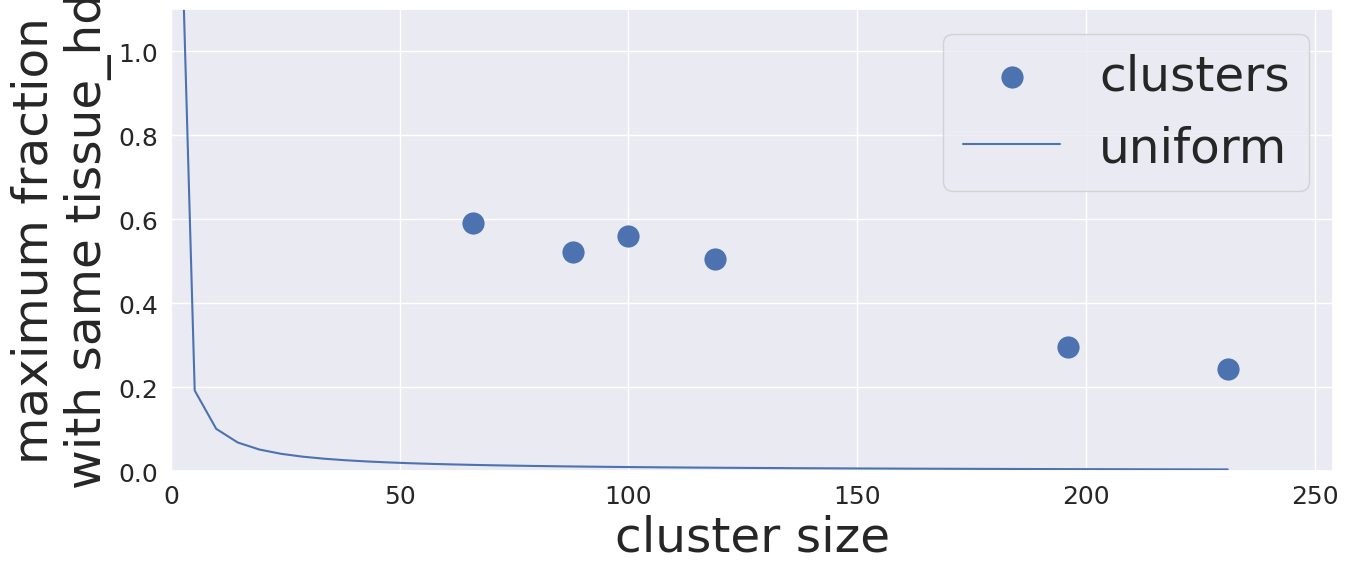

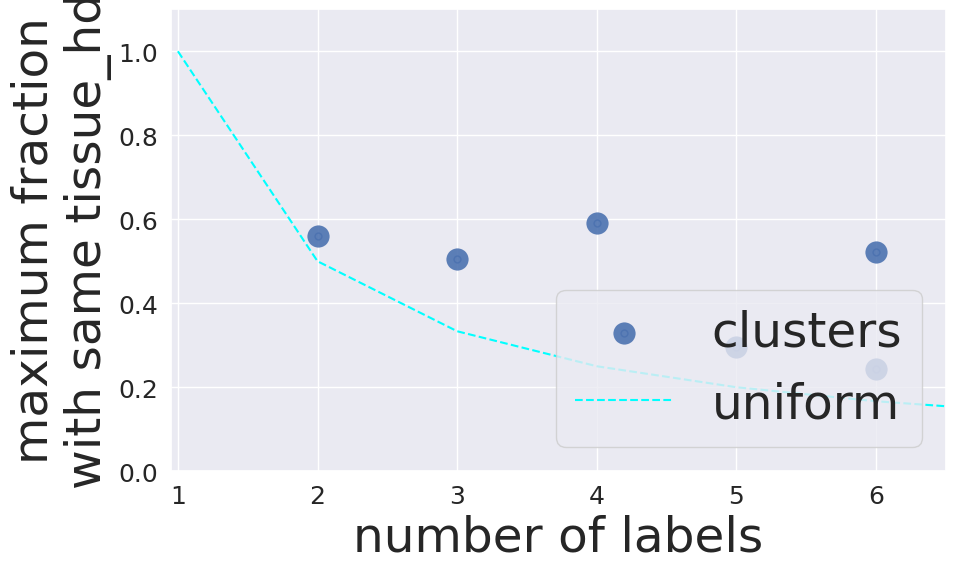

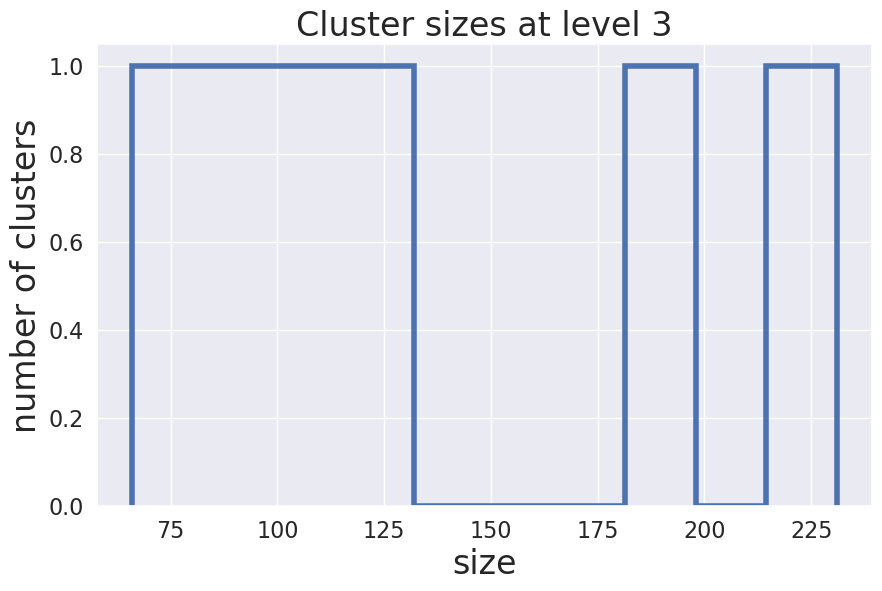

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


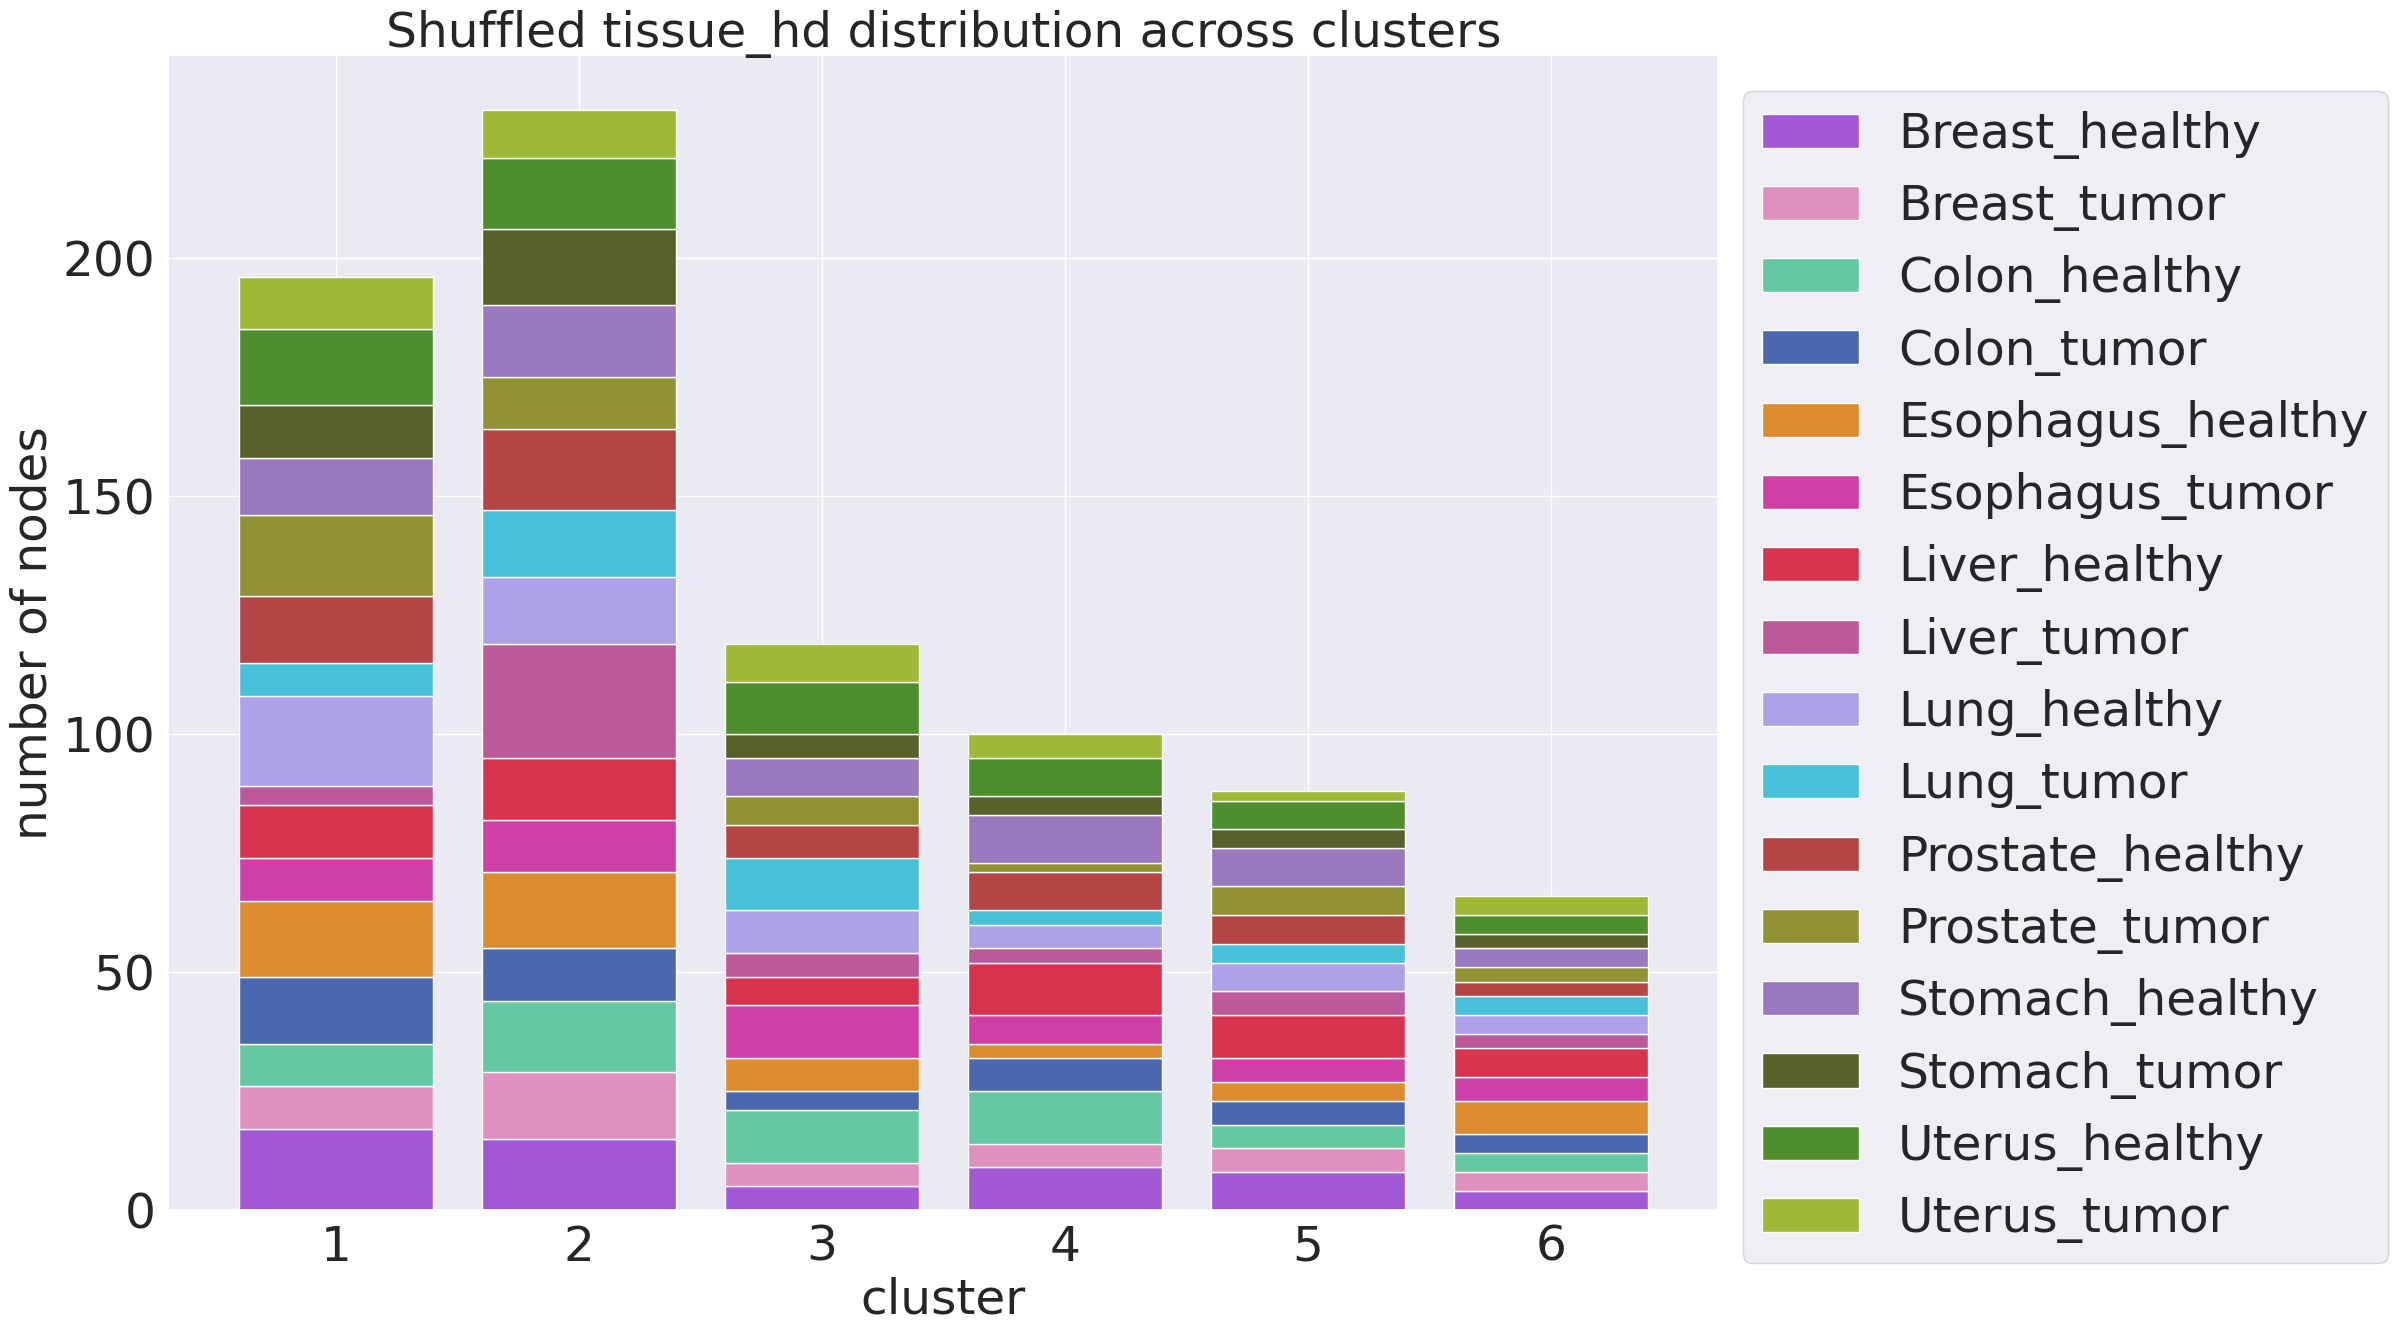

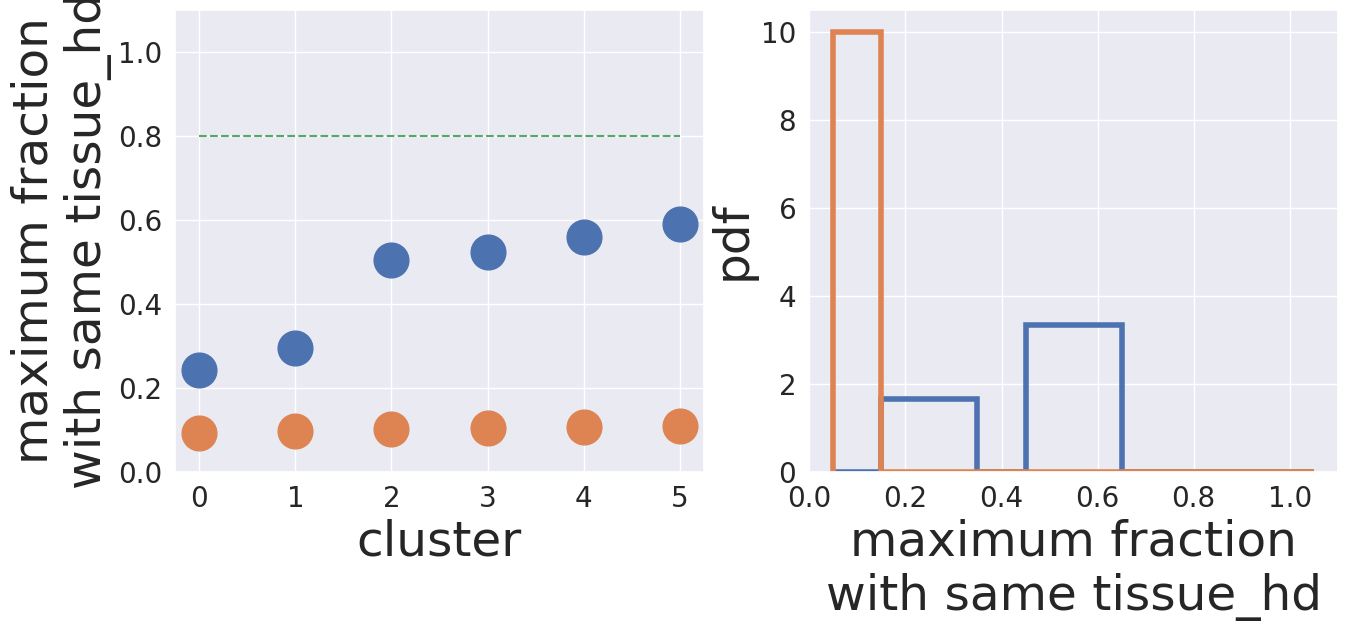

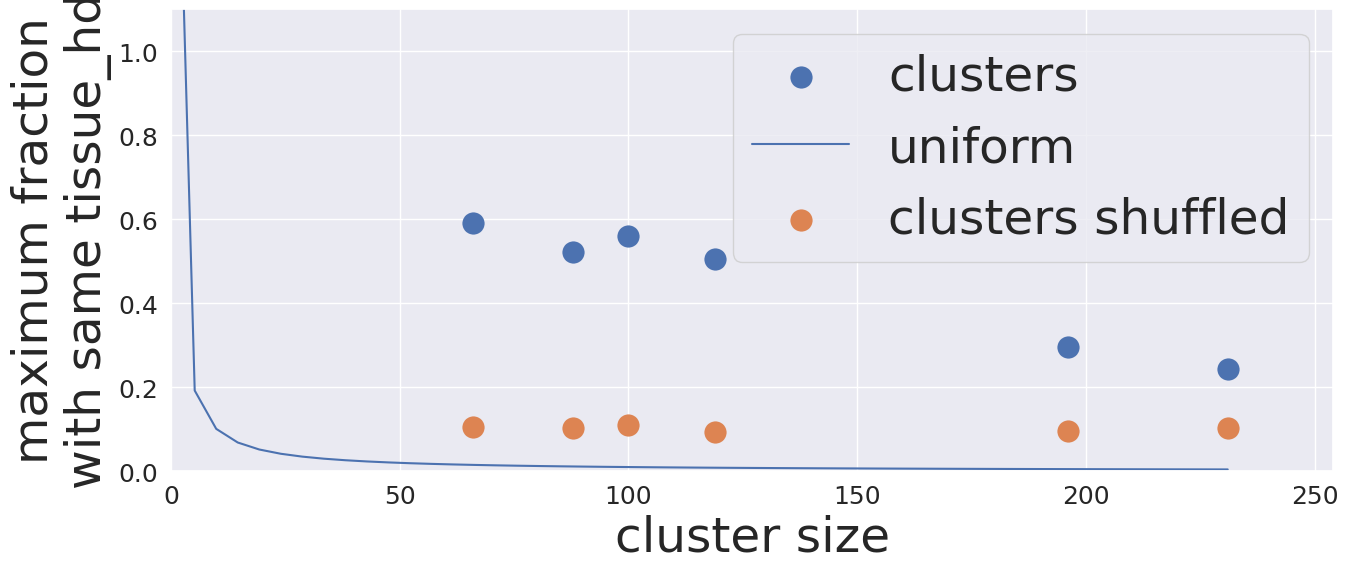

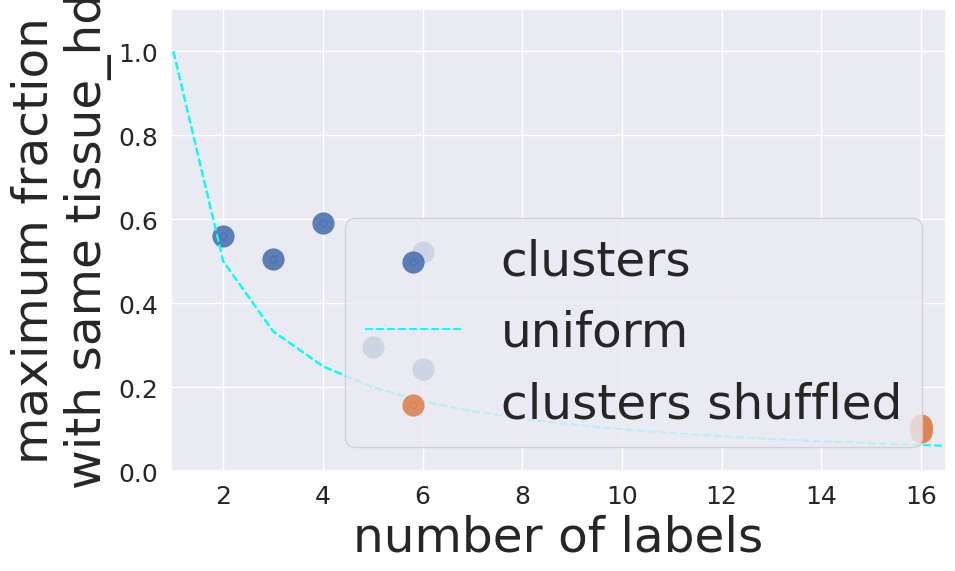

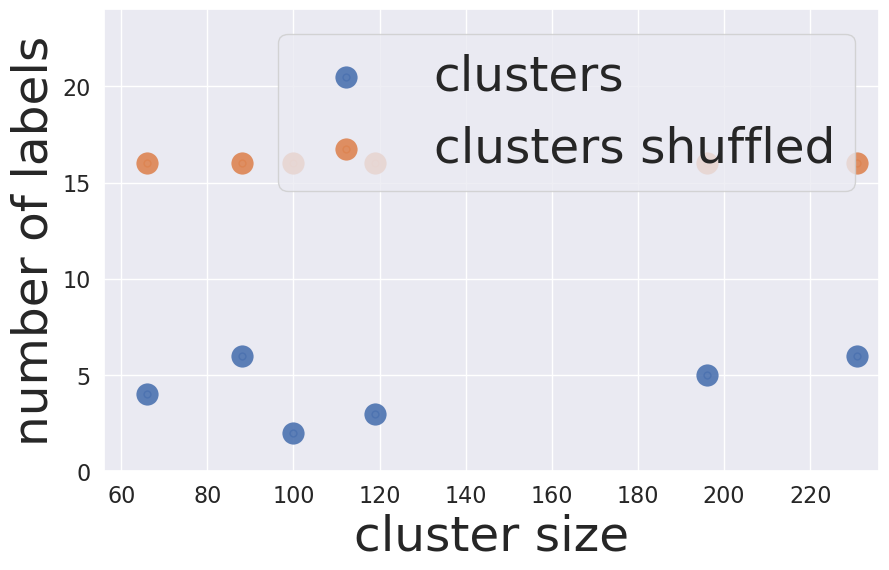

False tissue_hd 2


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


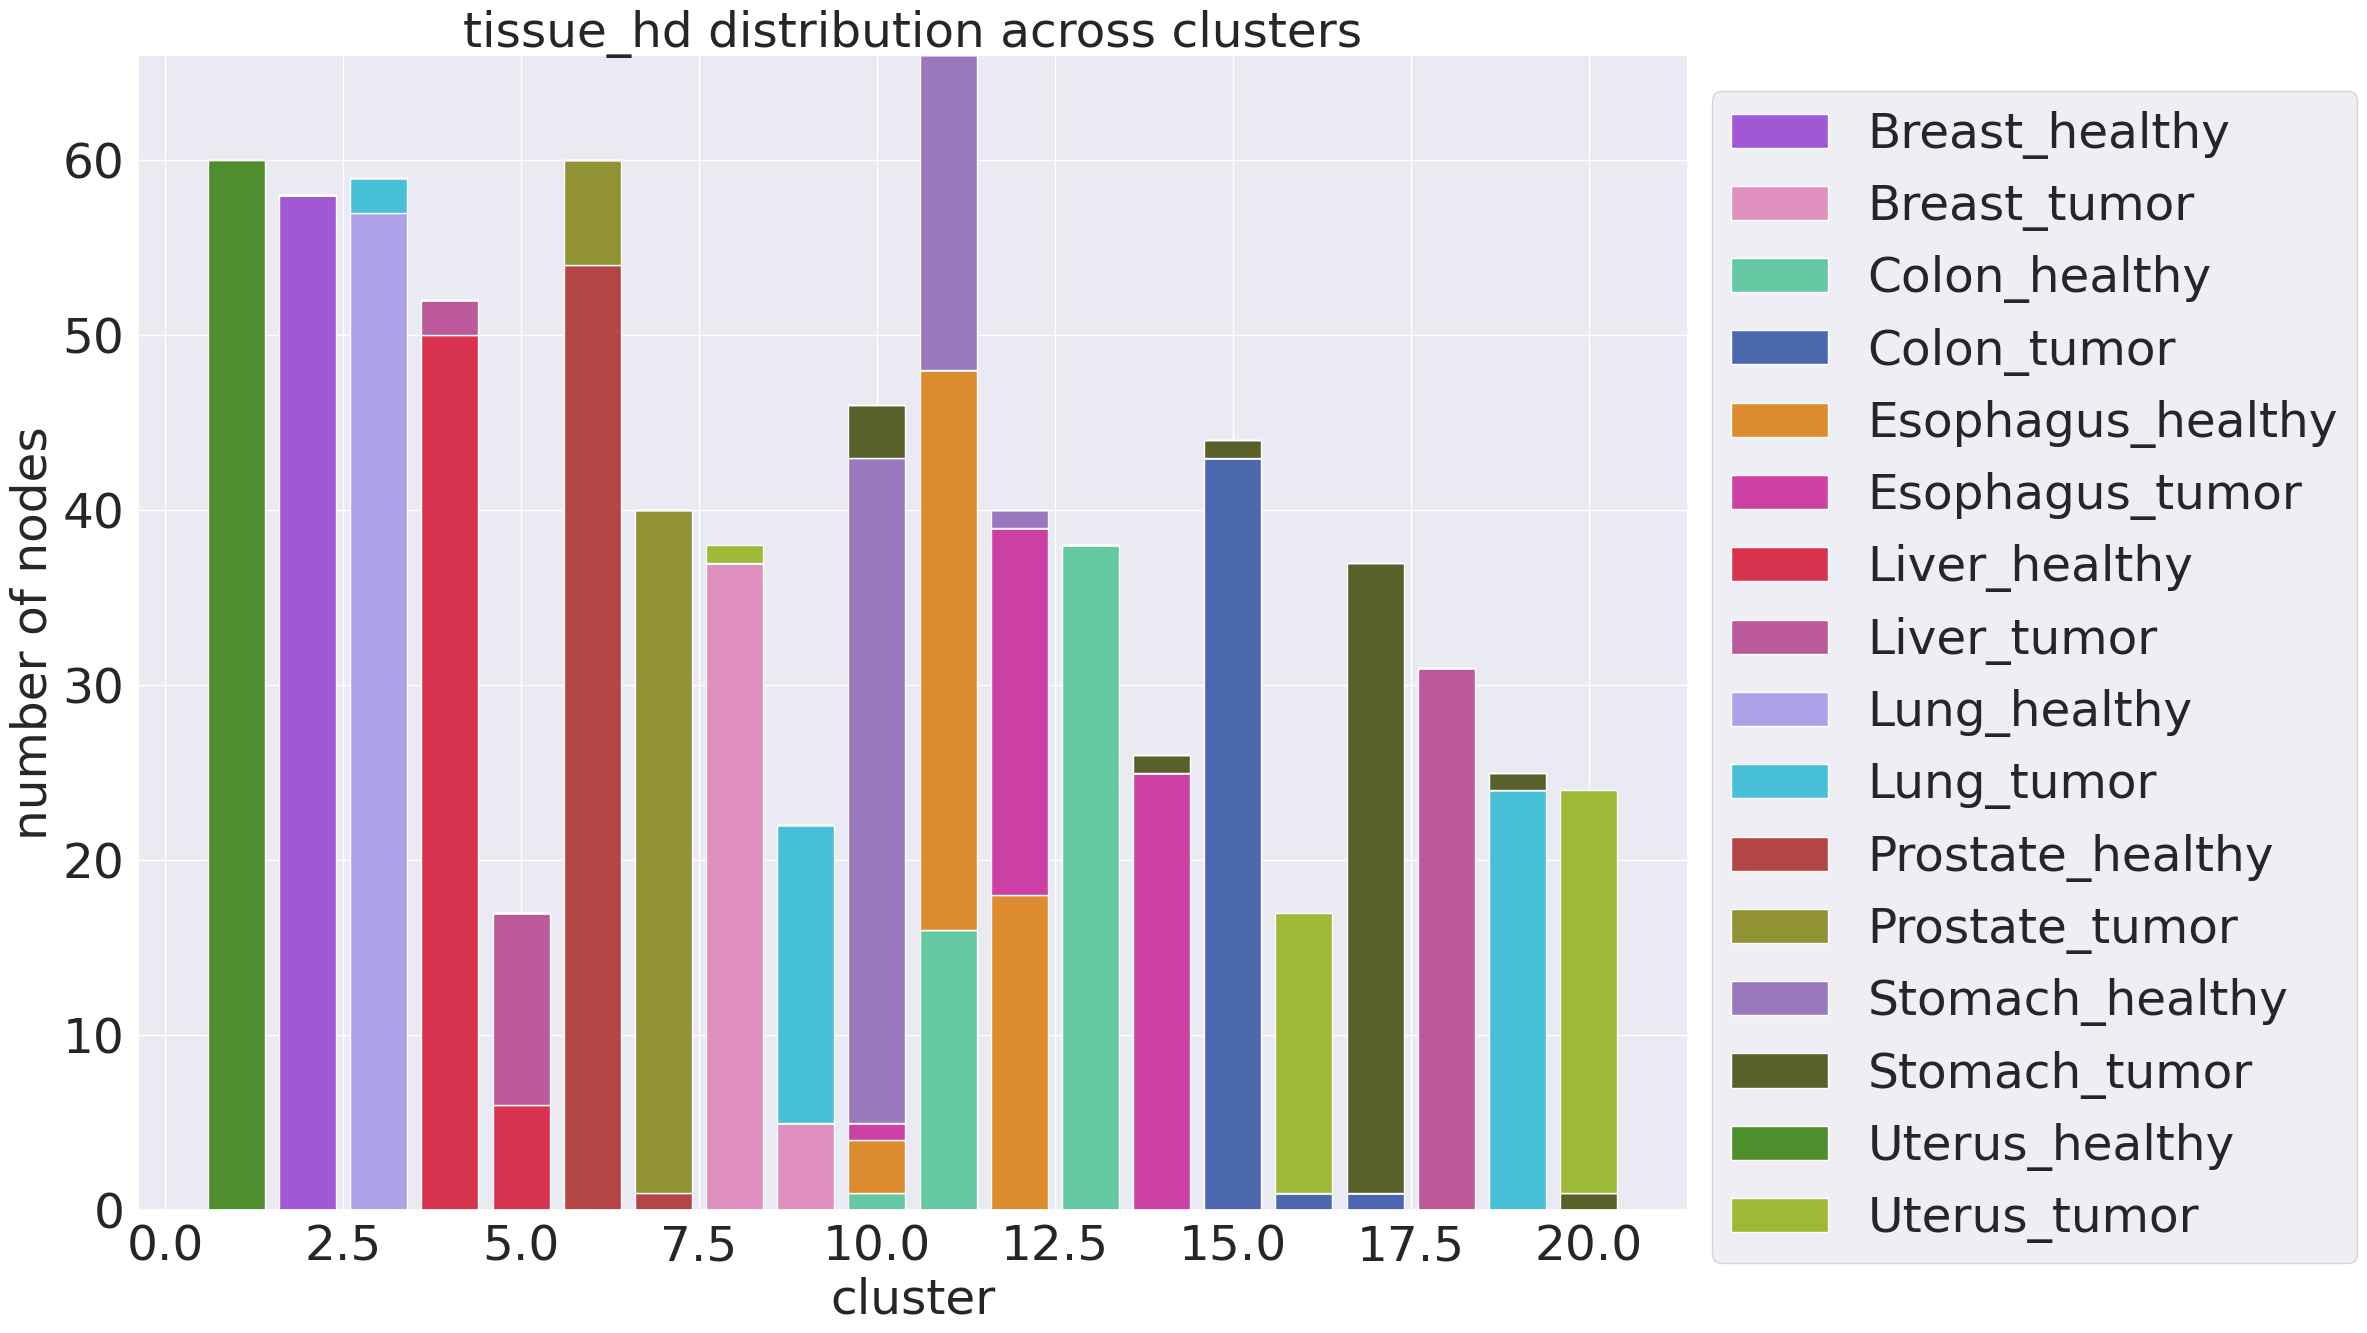

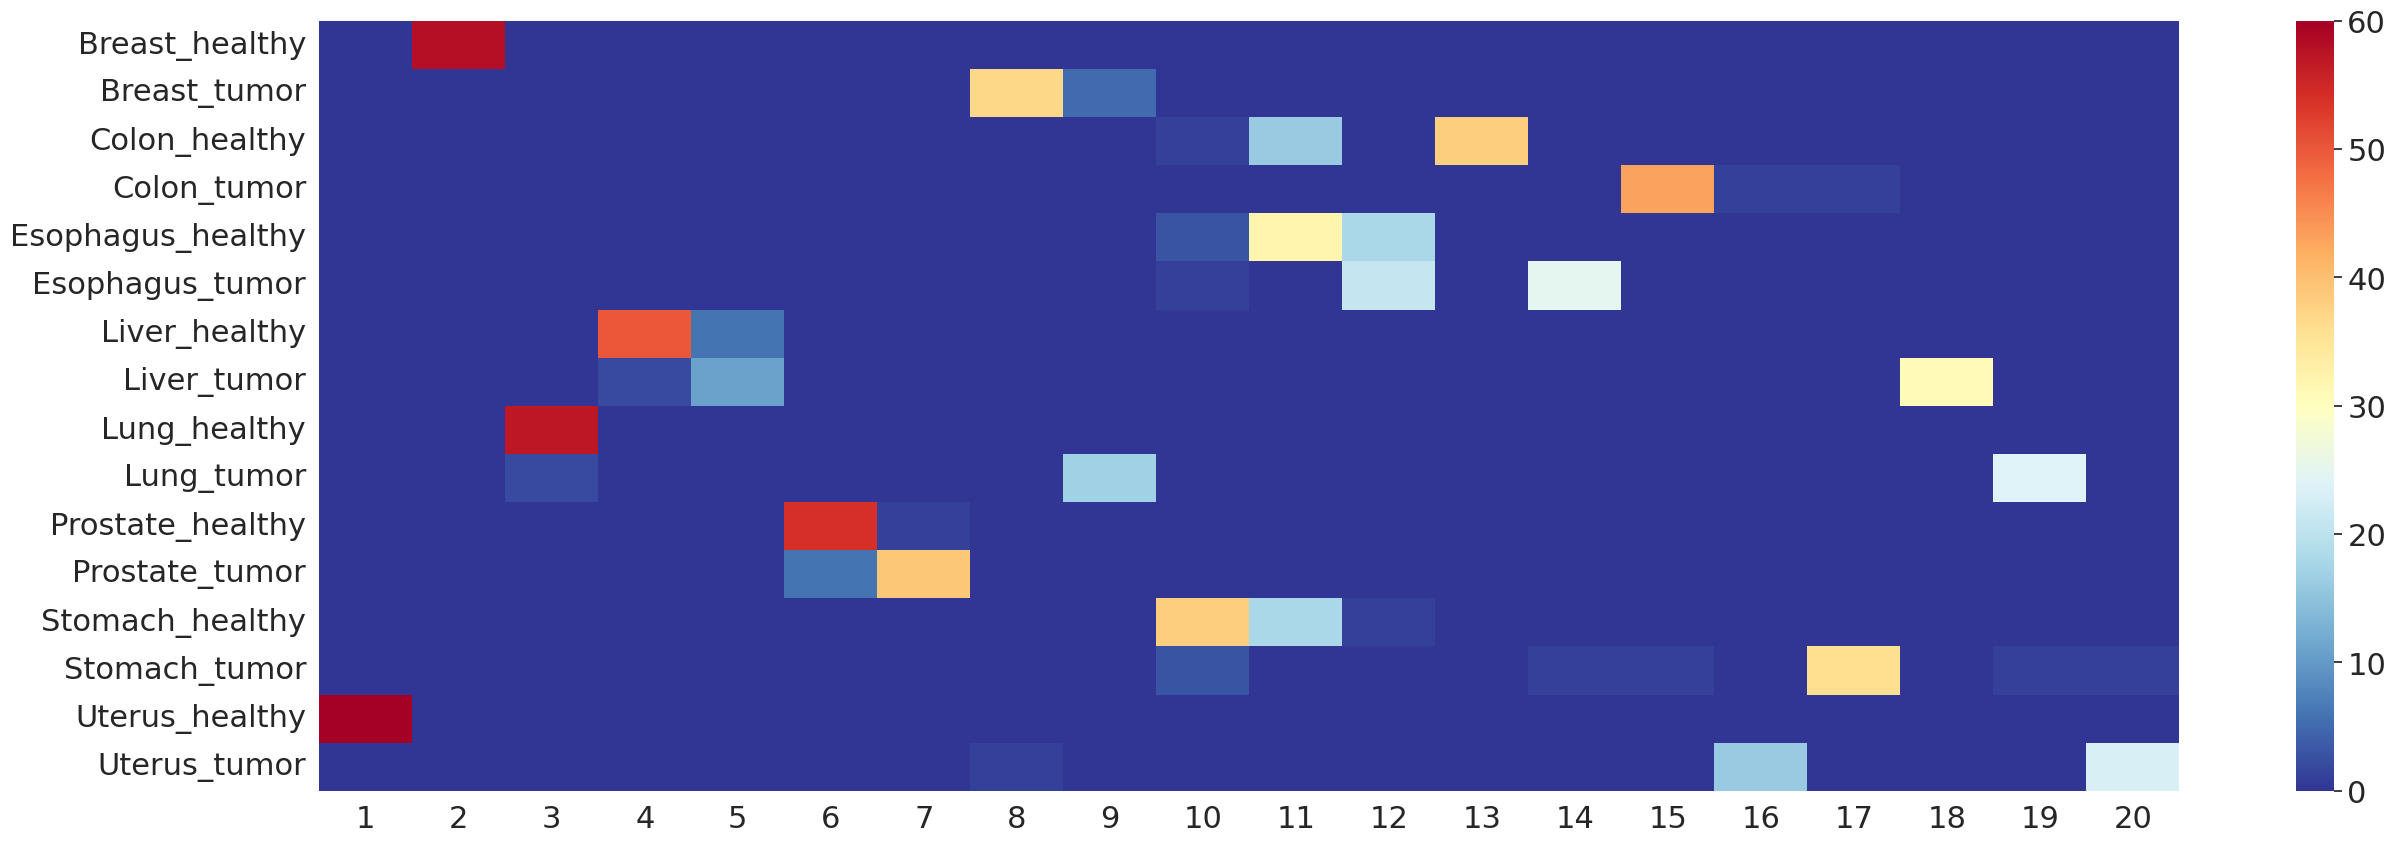

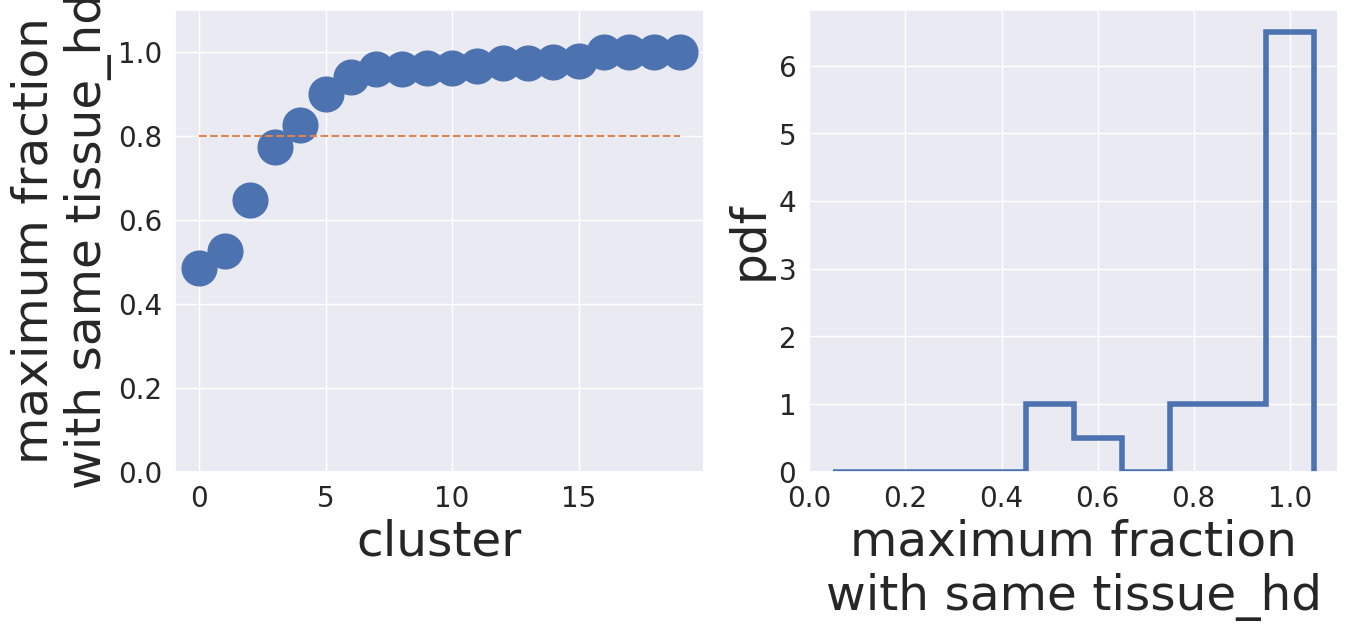

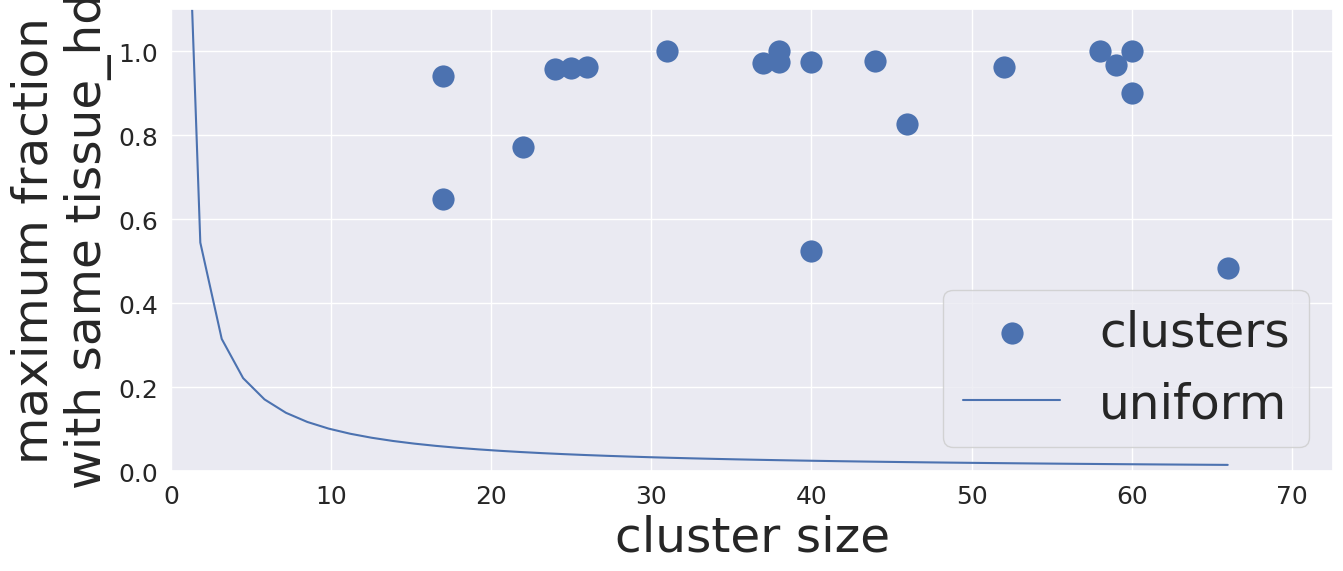

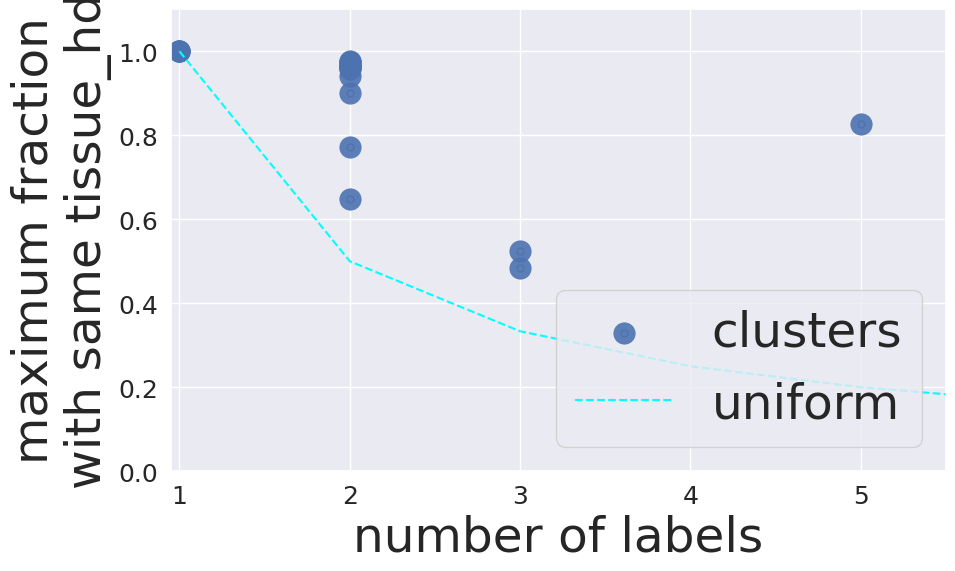

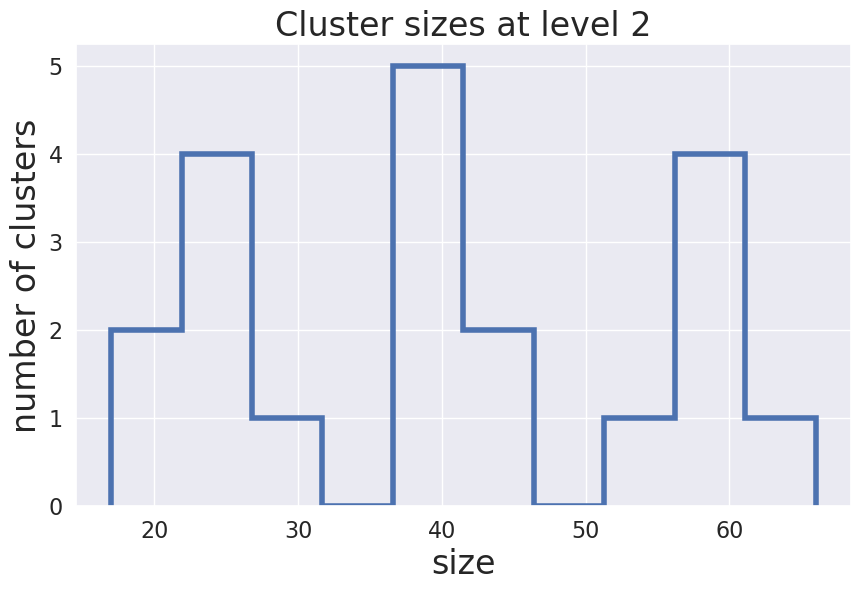

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


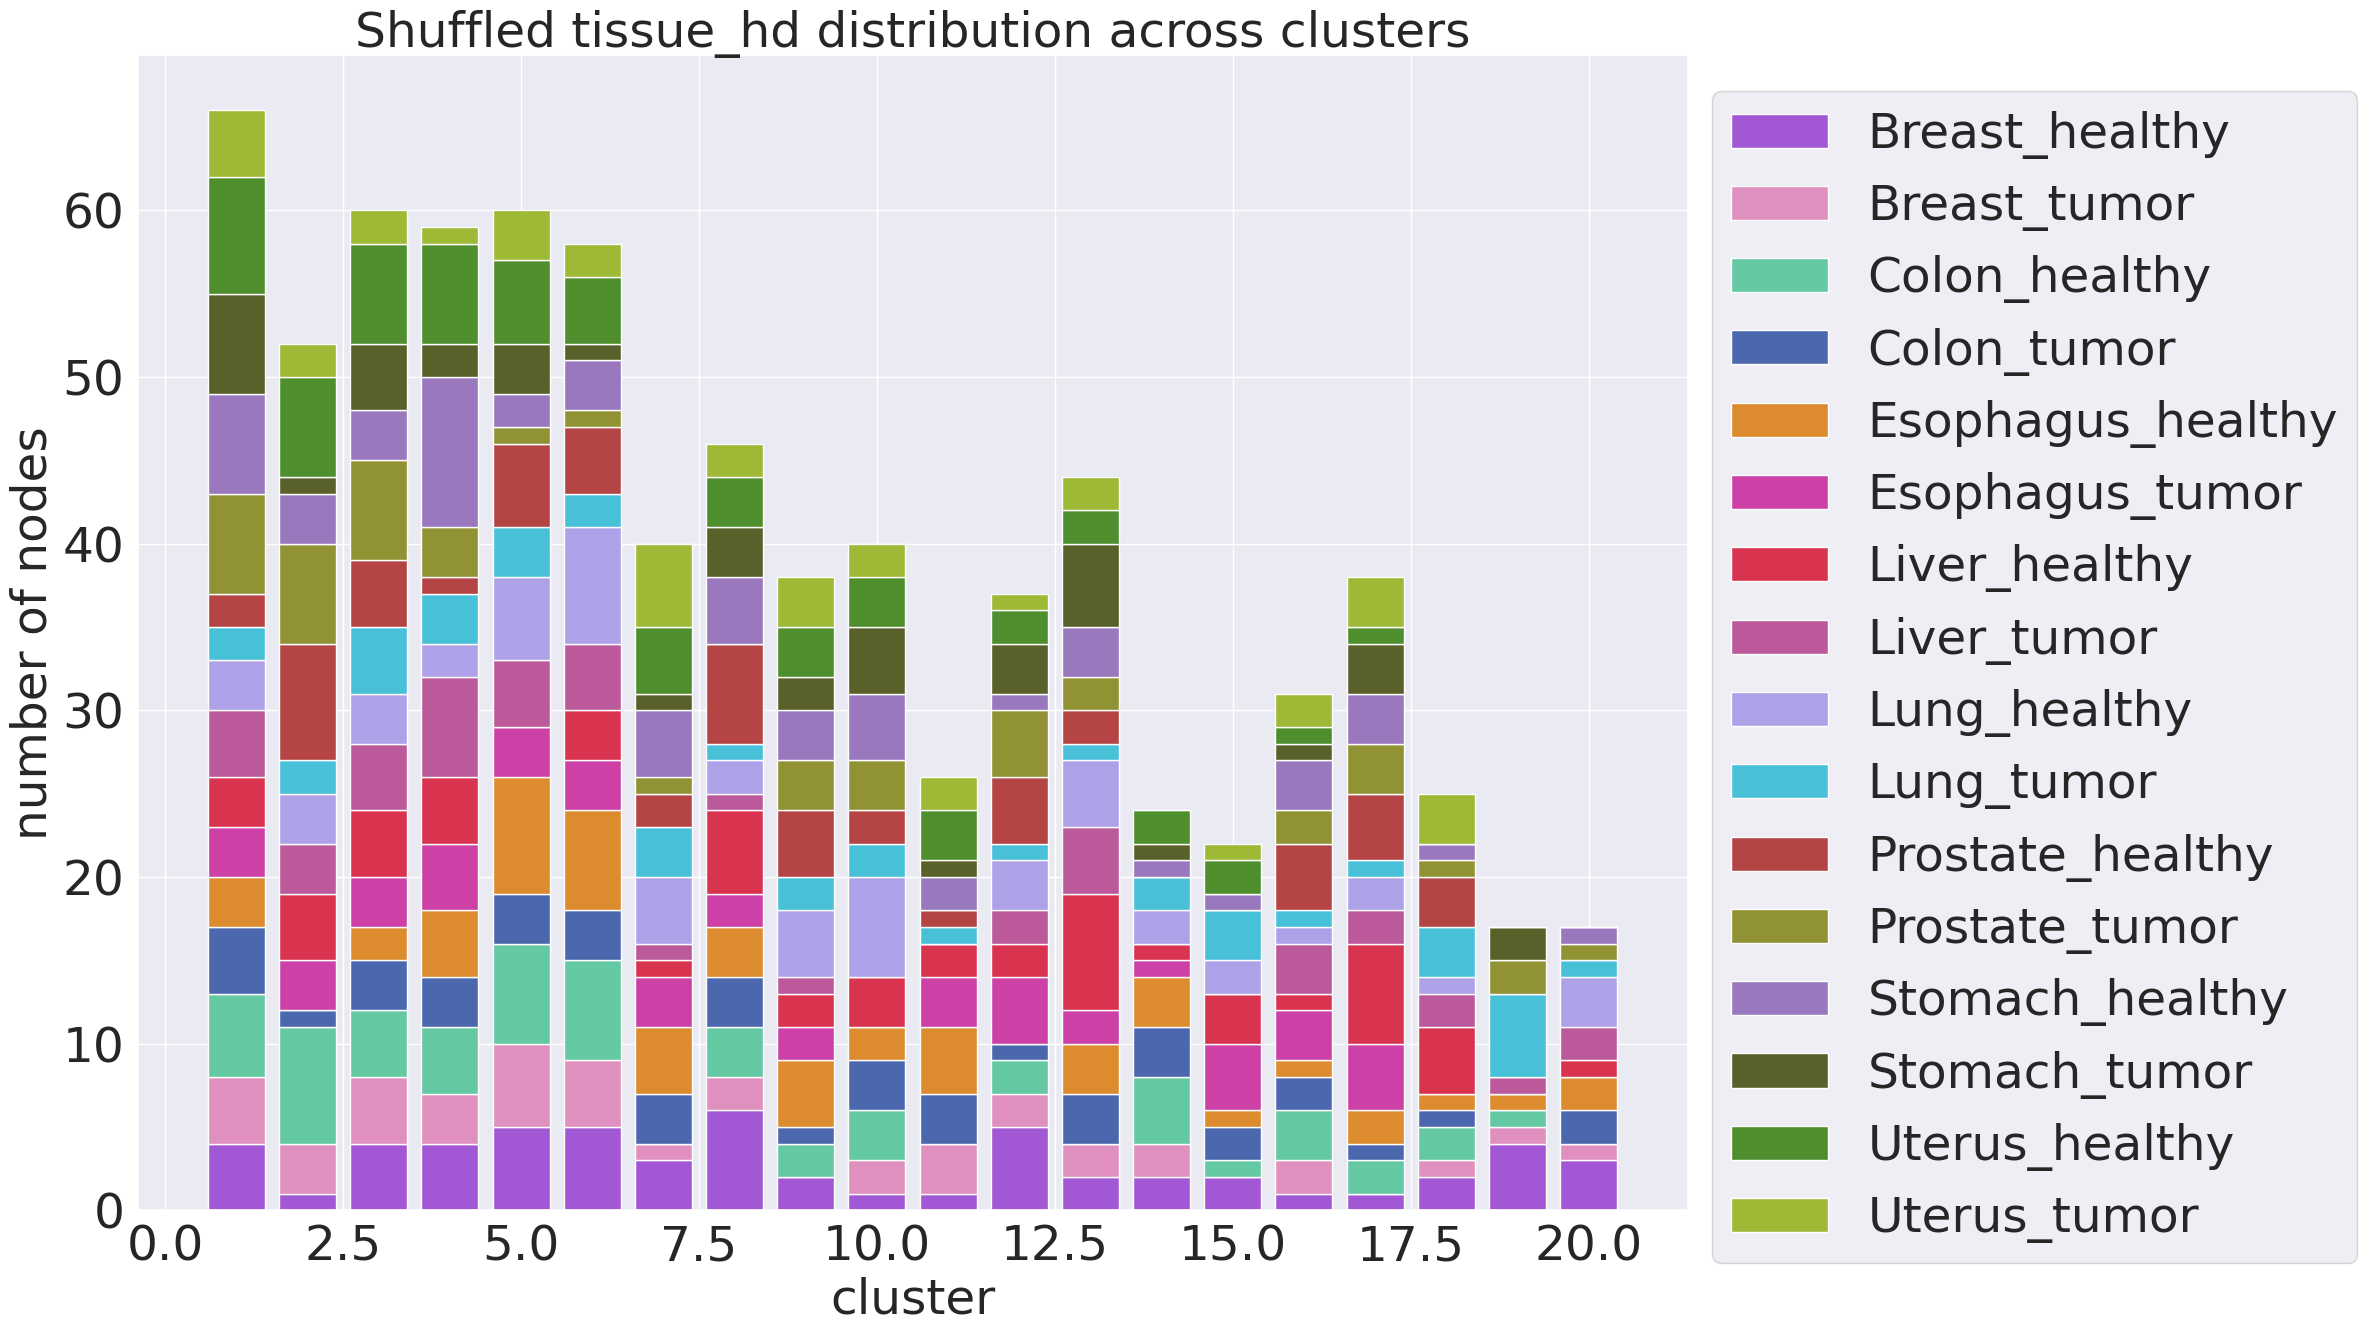

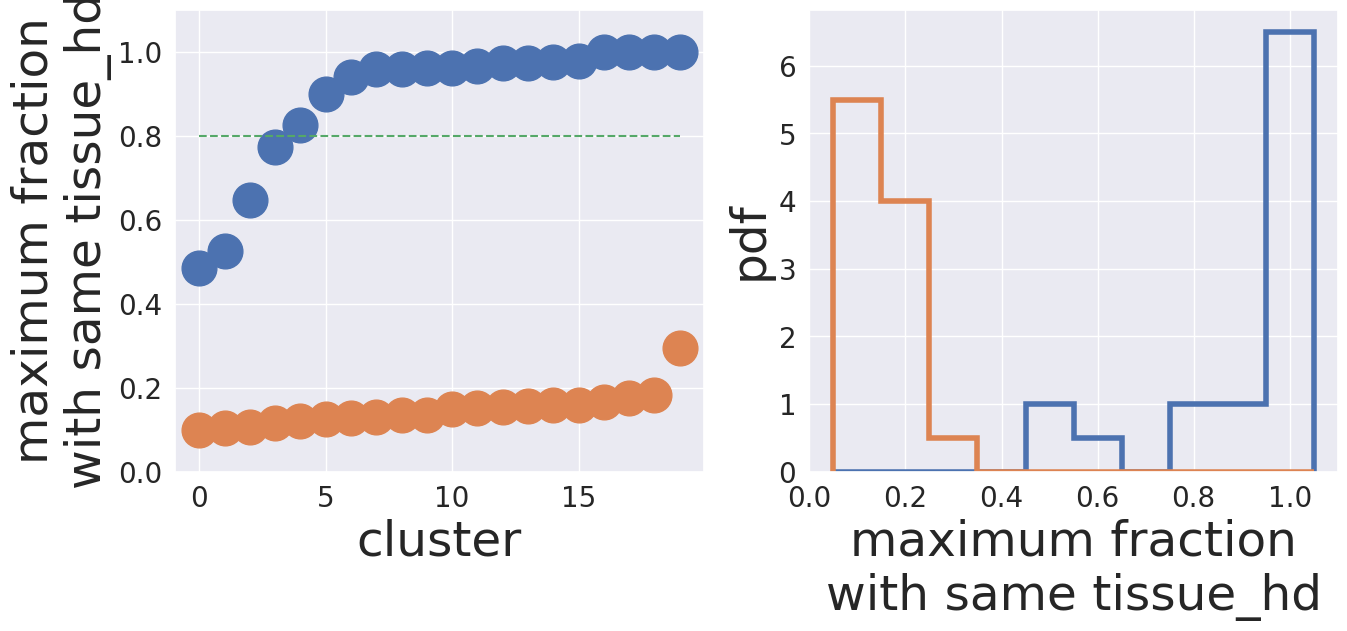

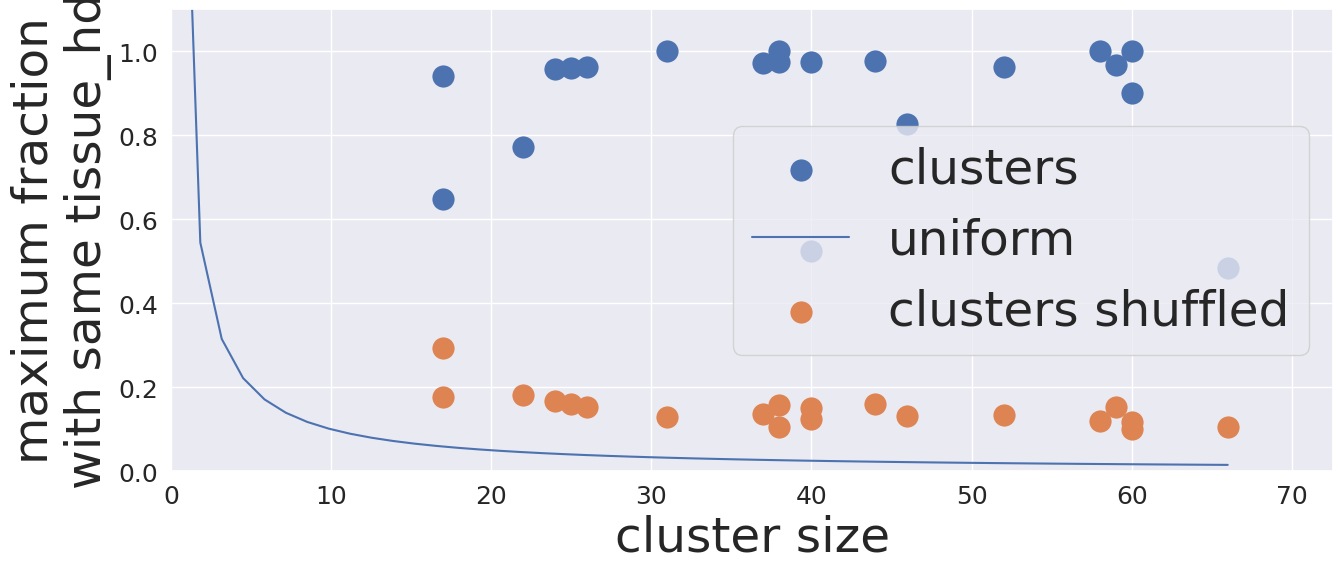

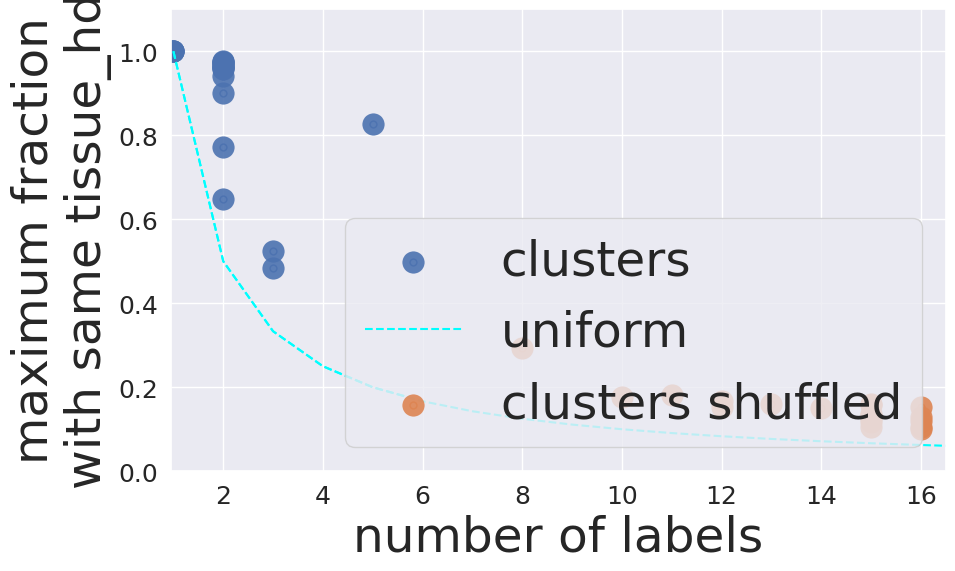

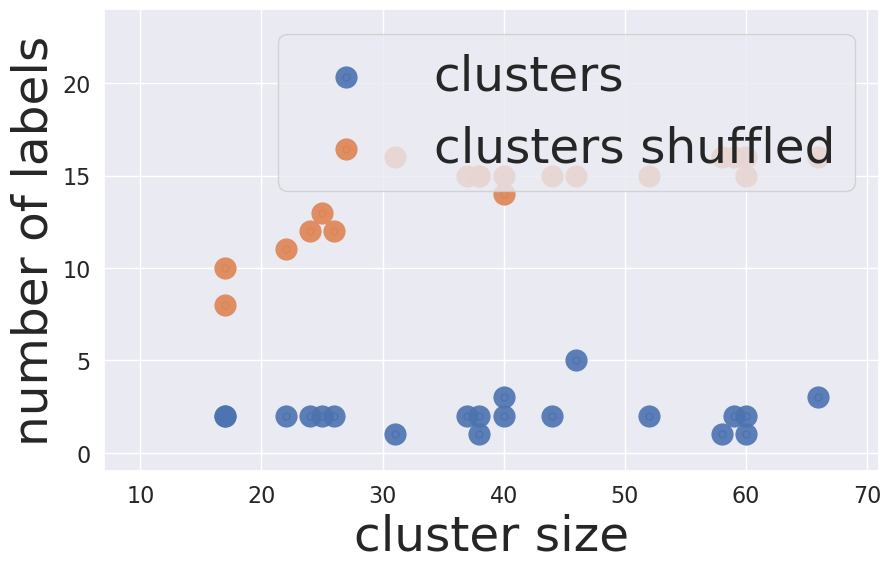

False tissue_hd 1


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


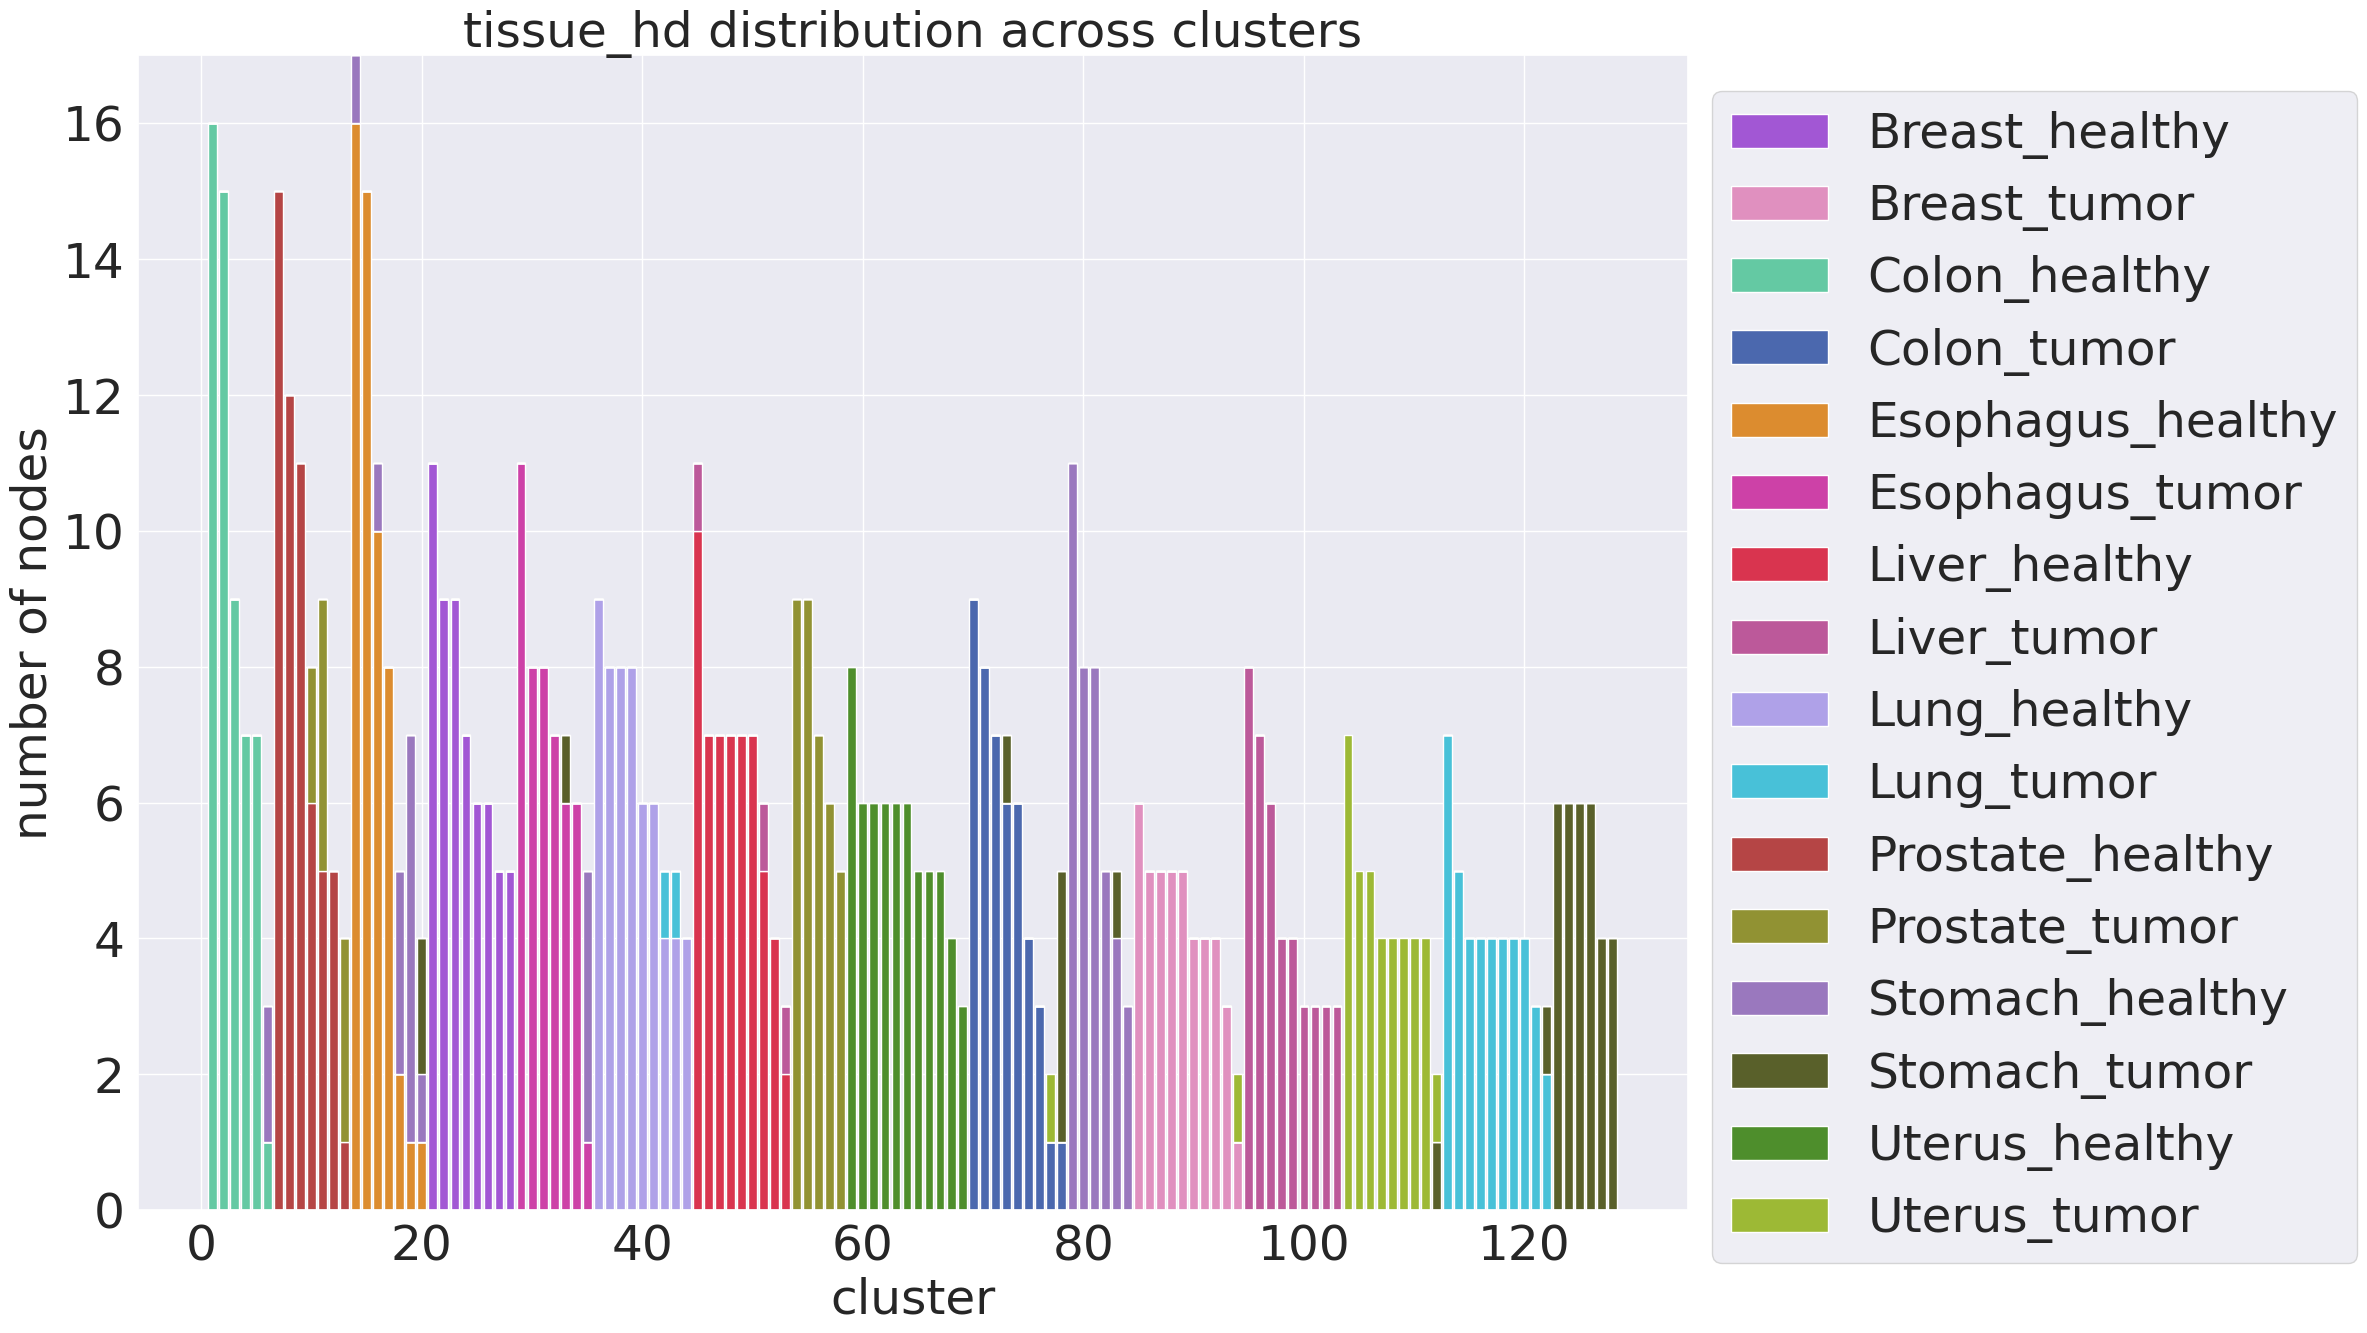

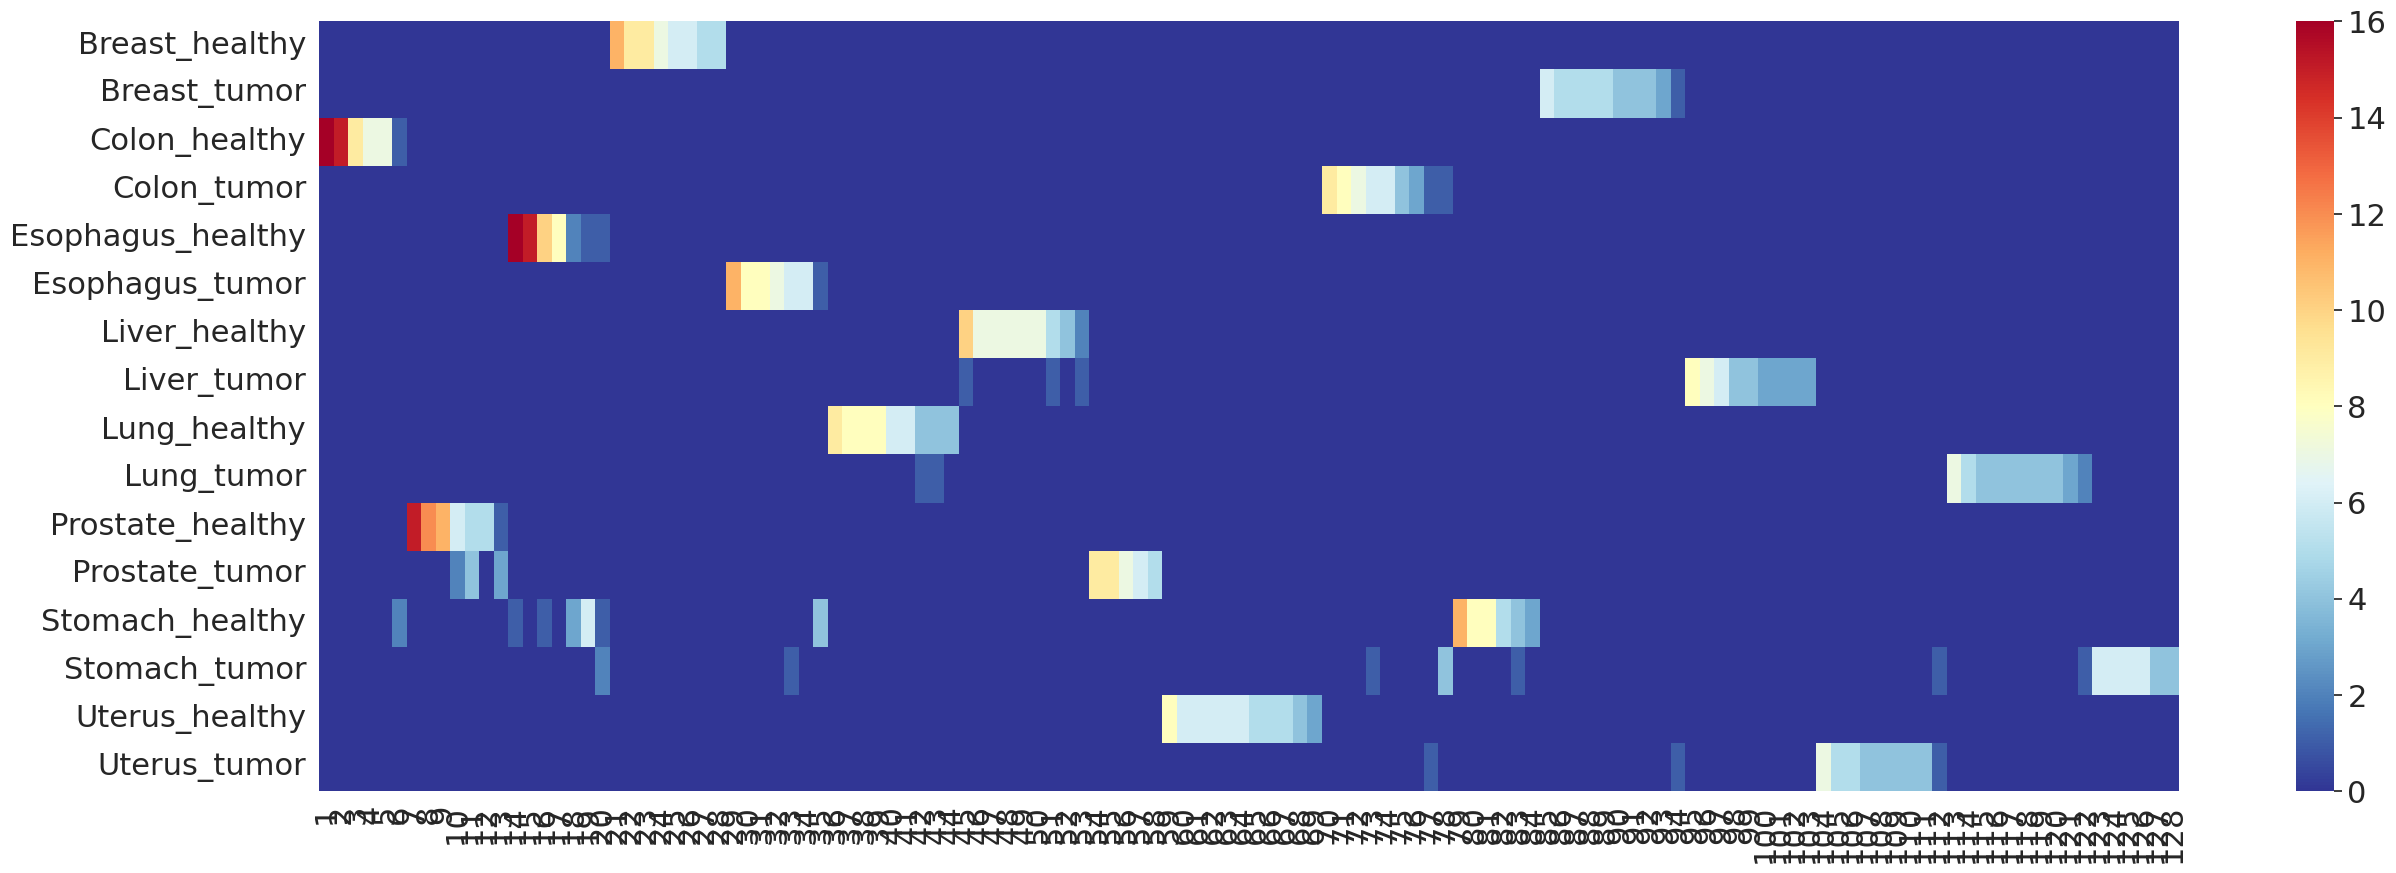

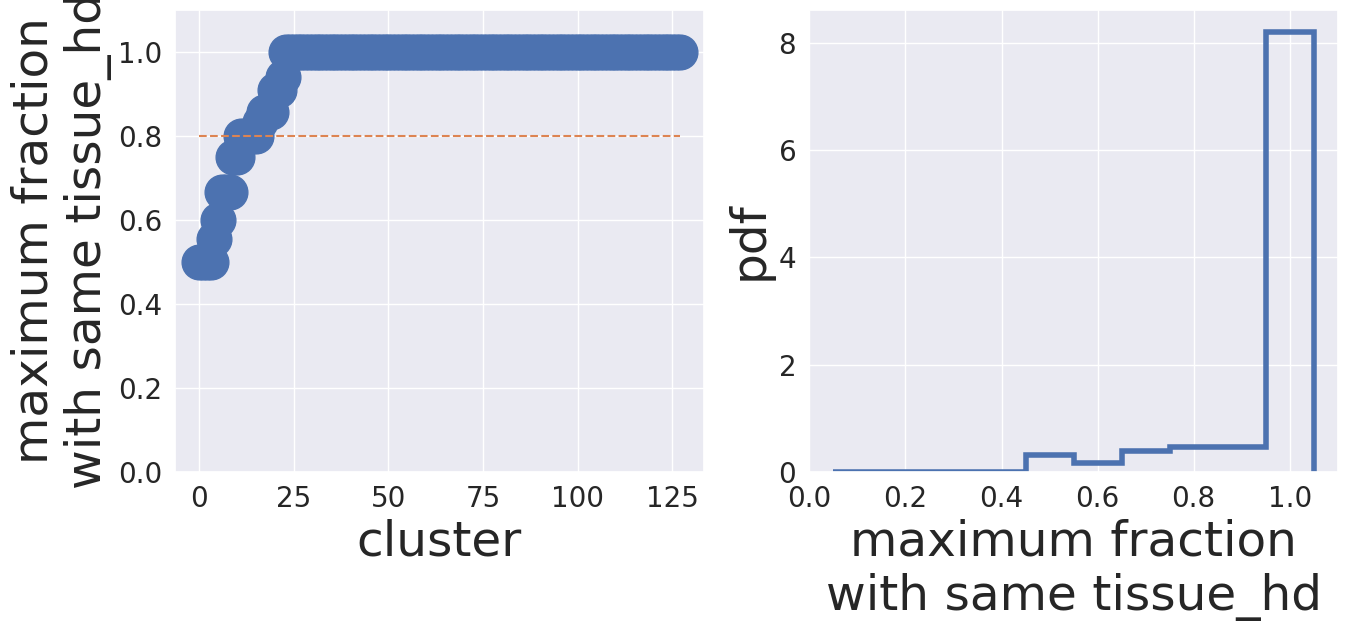

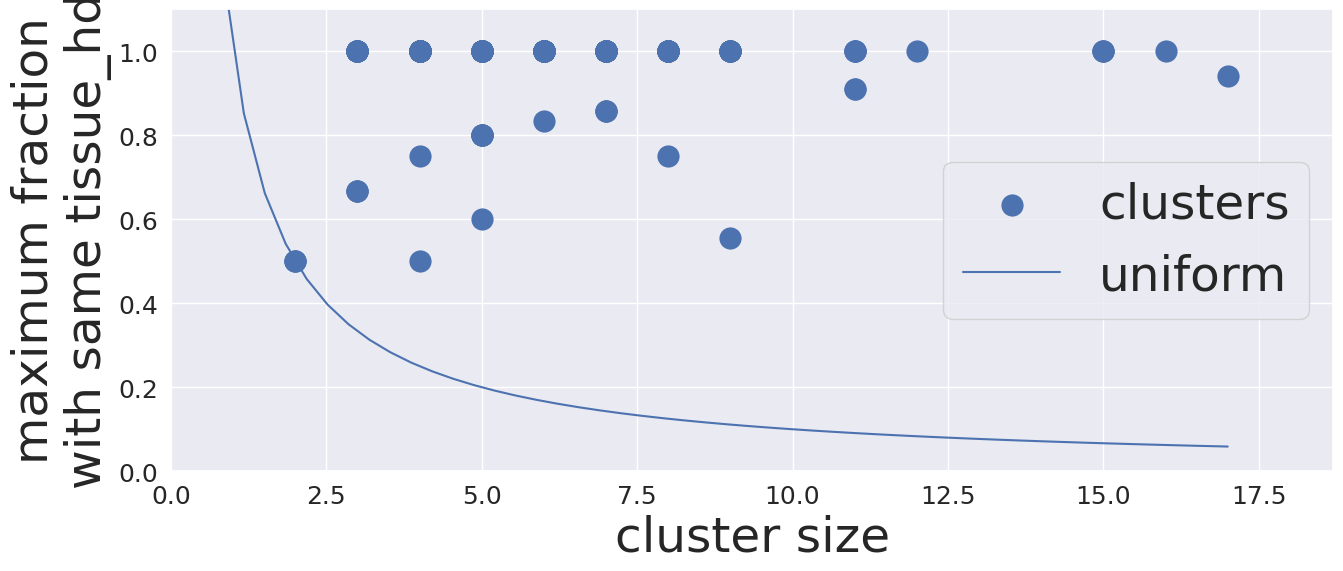

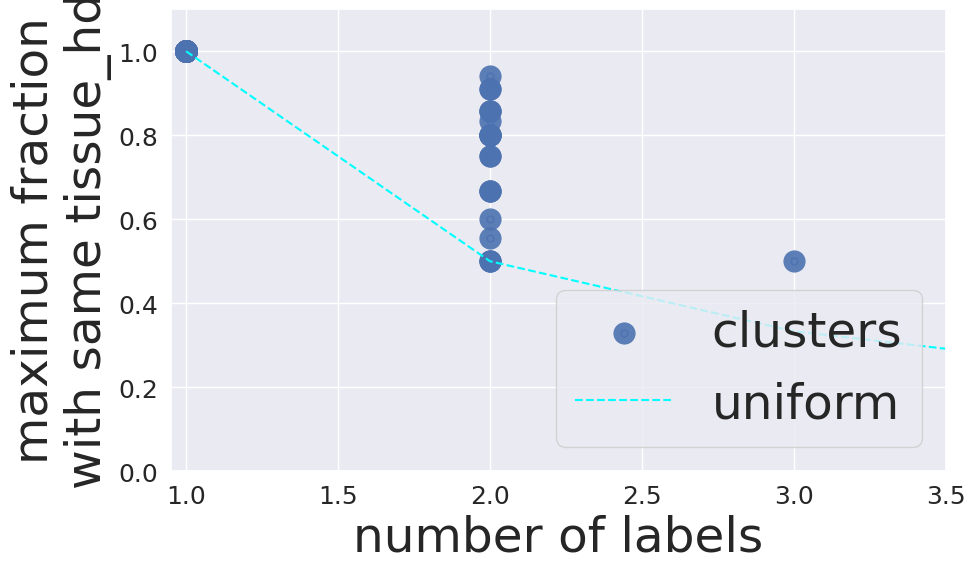

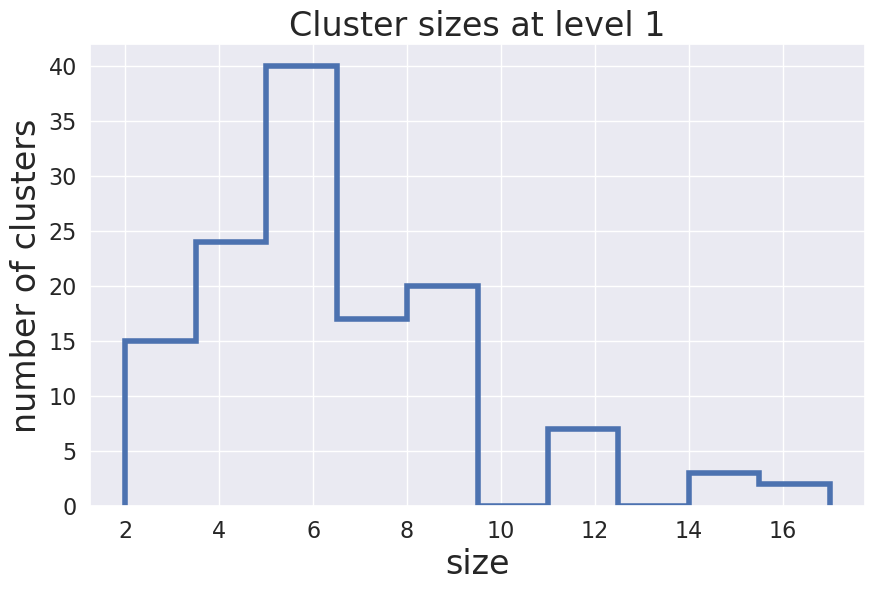

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


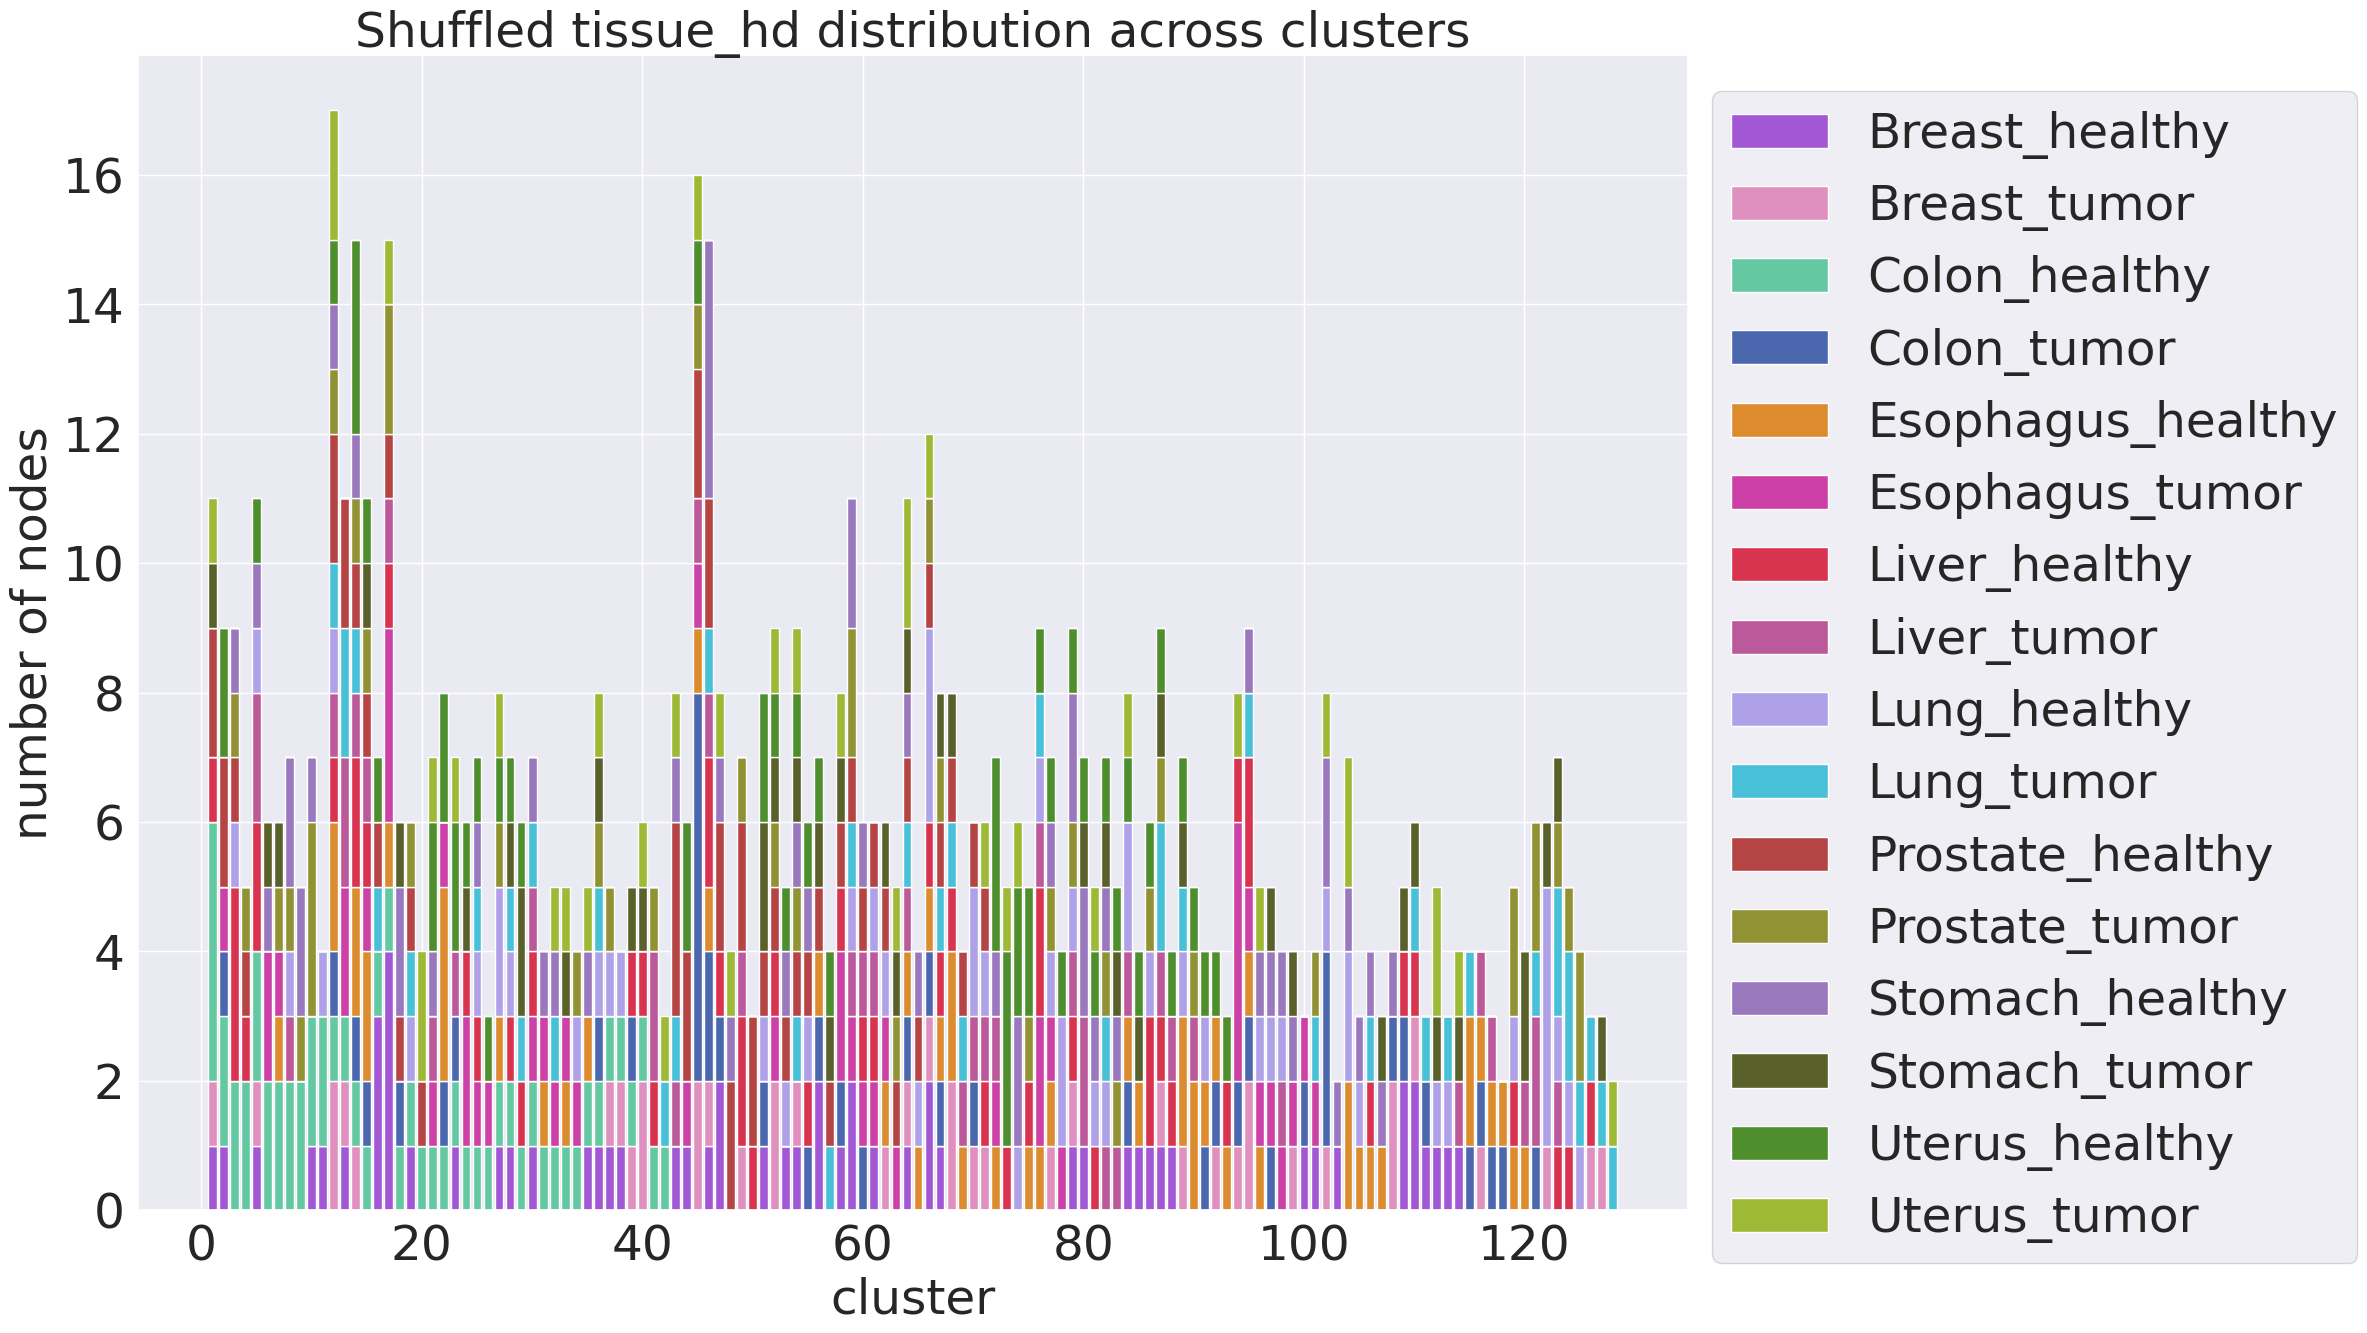

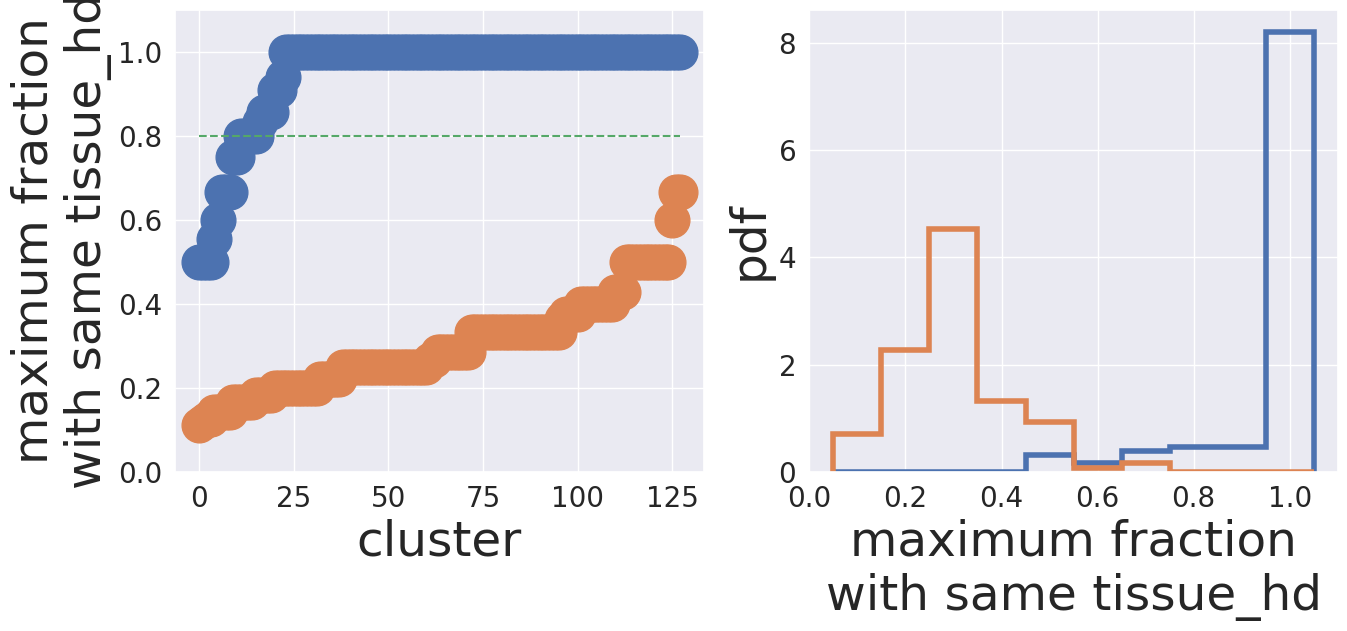

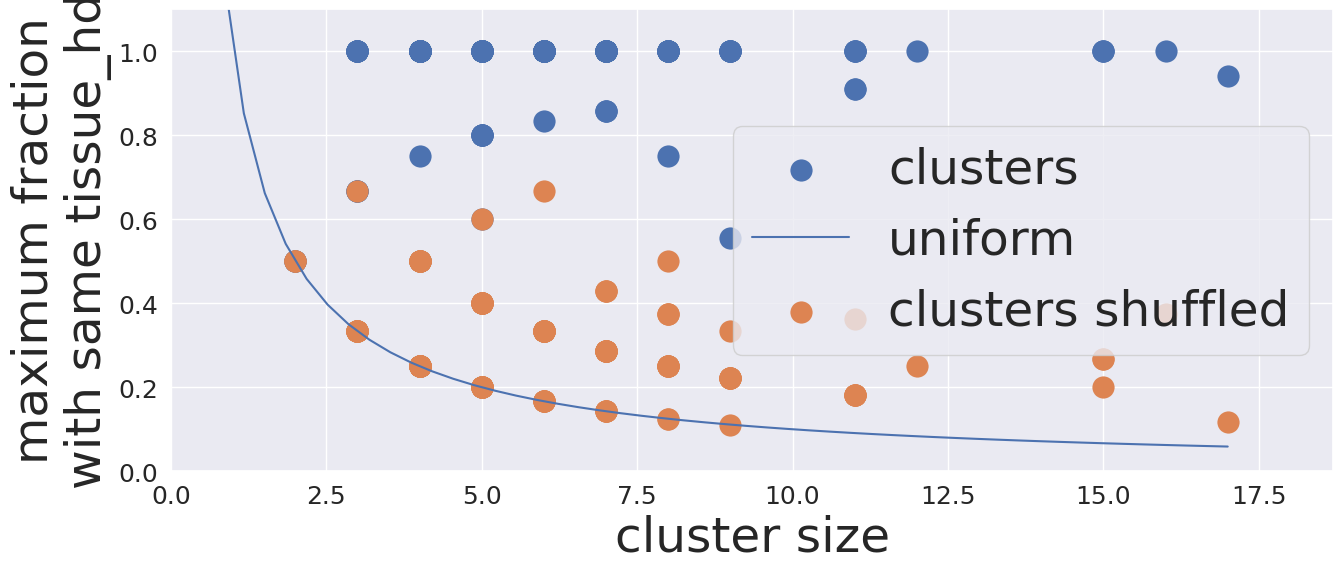

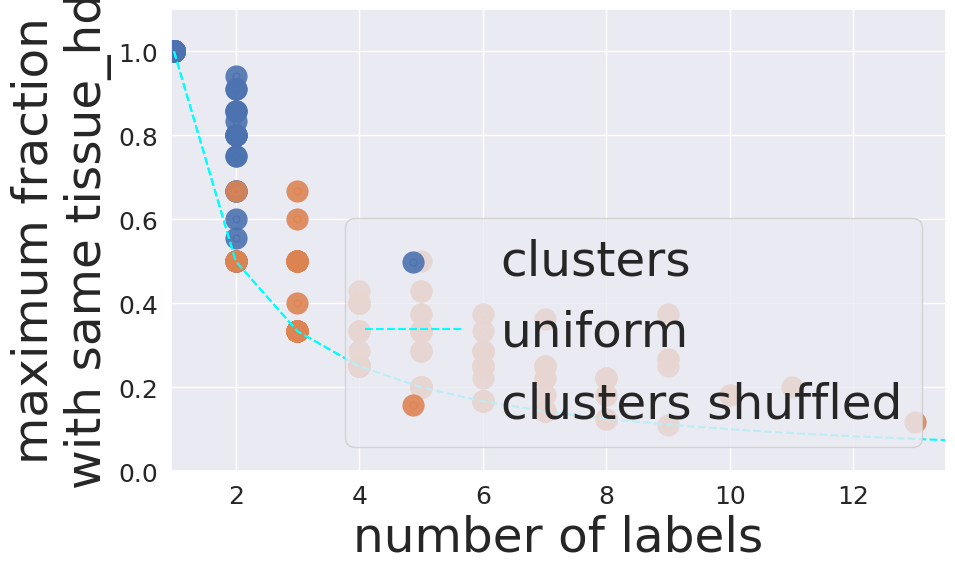

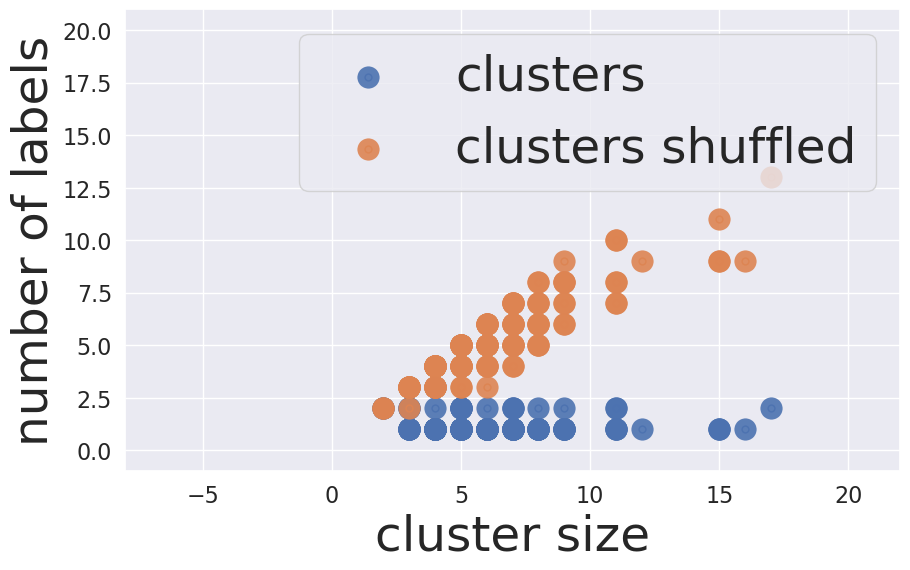

False tissue_hd 0


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<class 'KeyboardInterrupt'>  <traceback object at 0x7fe9131a6840>


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


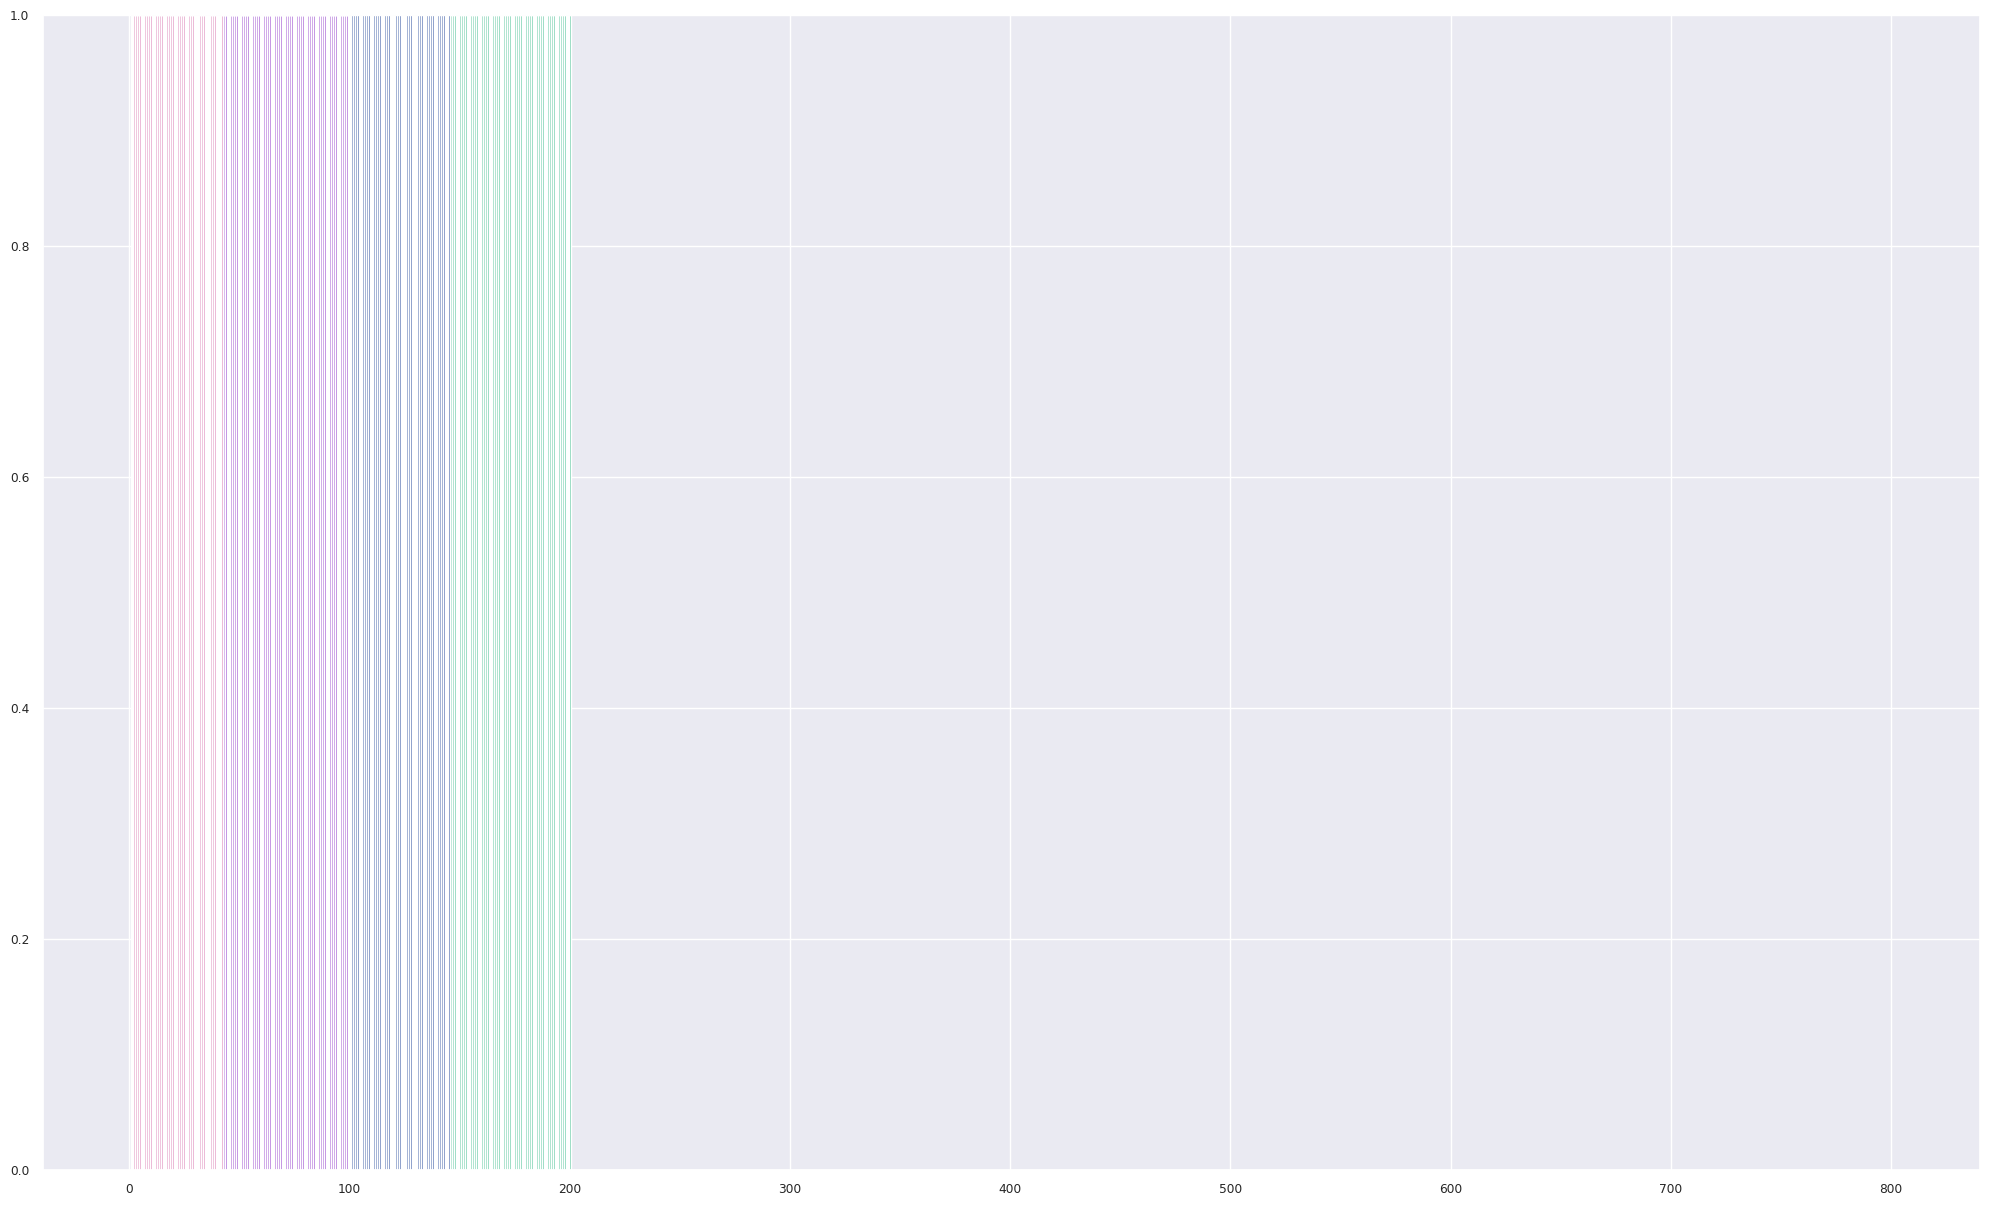

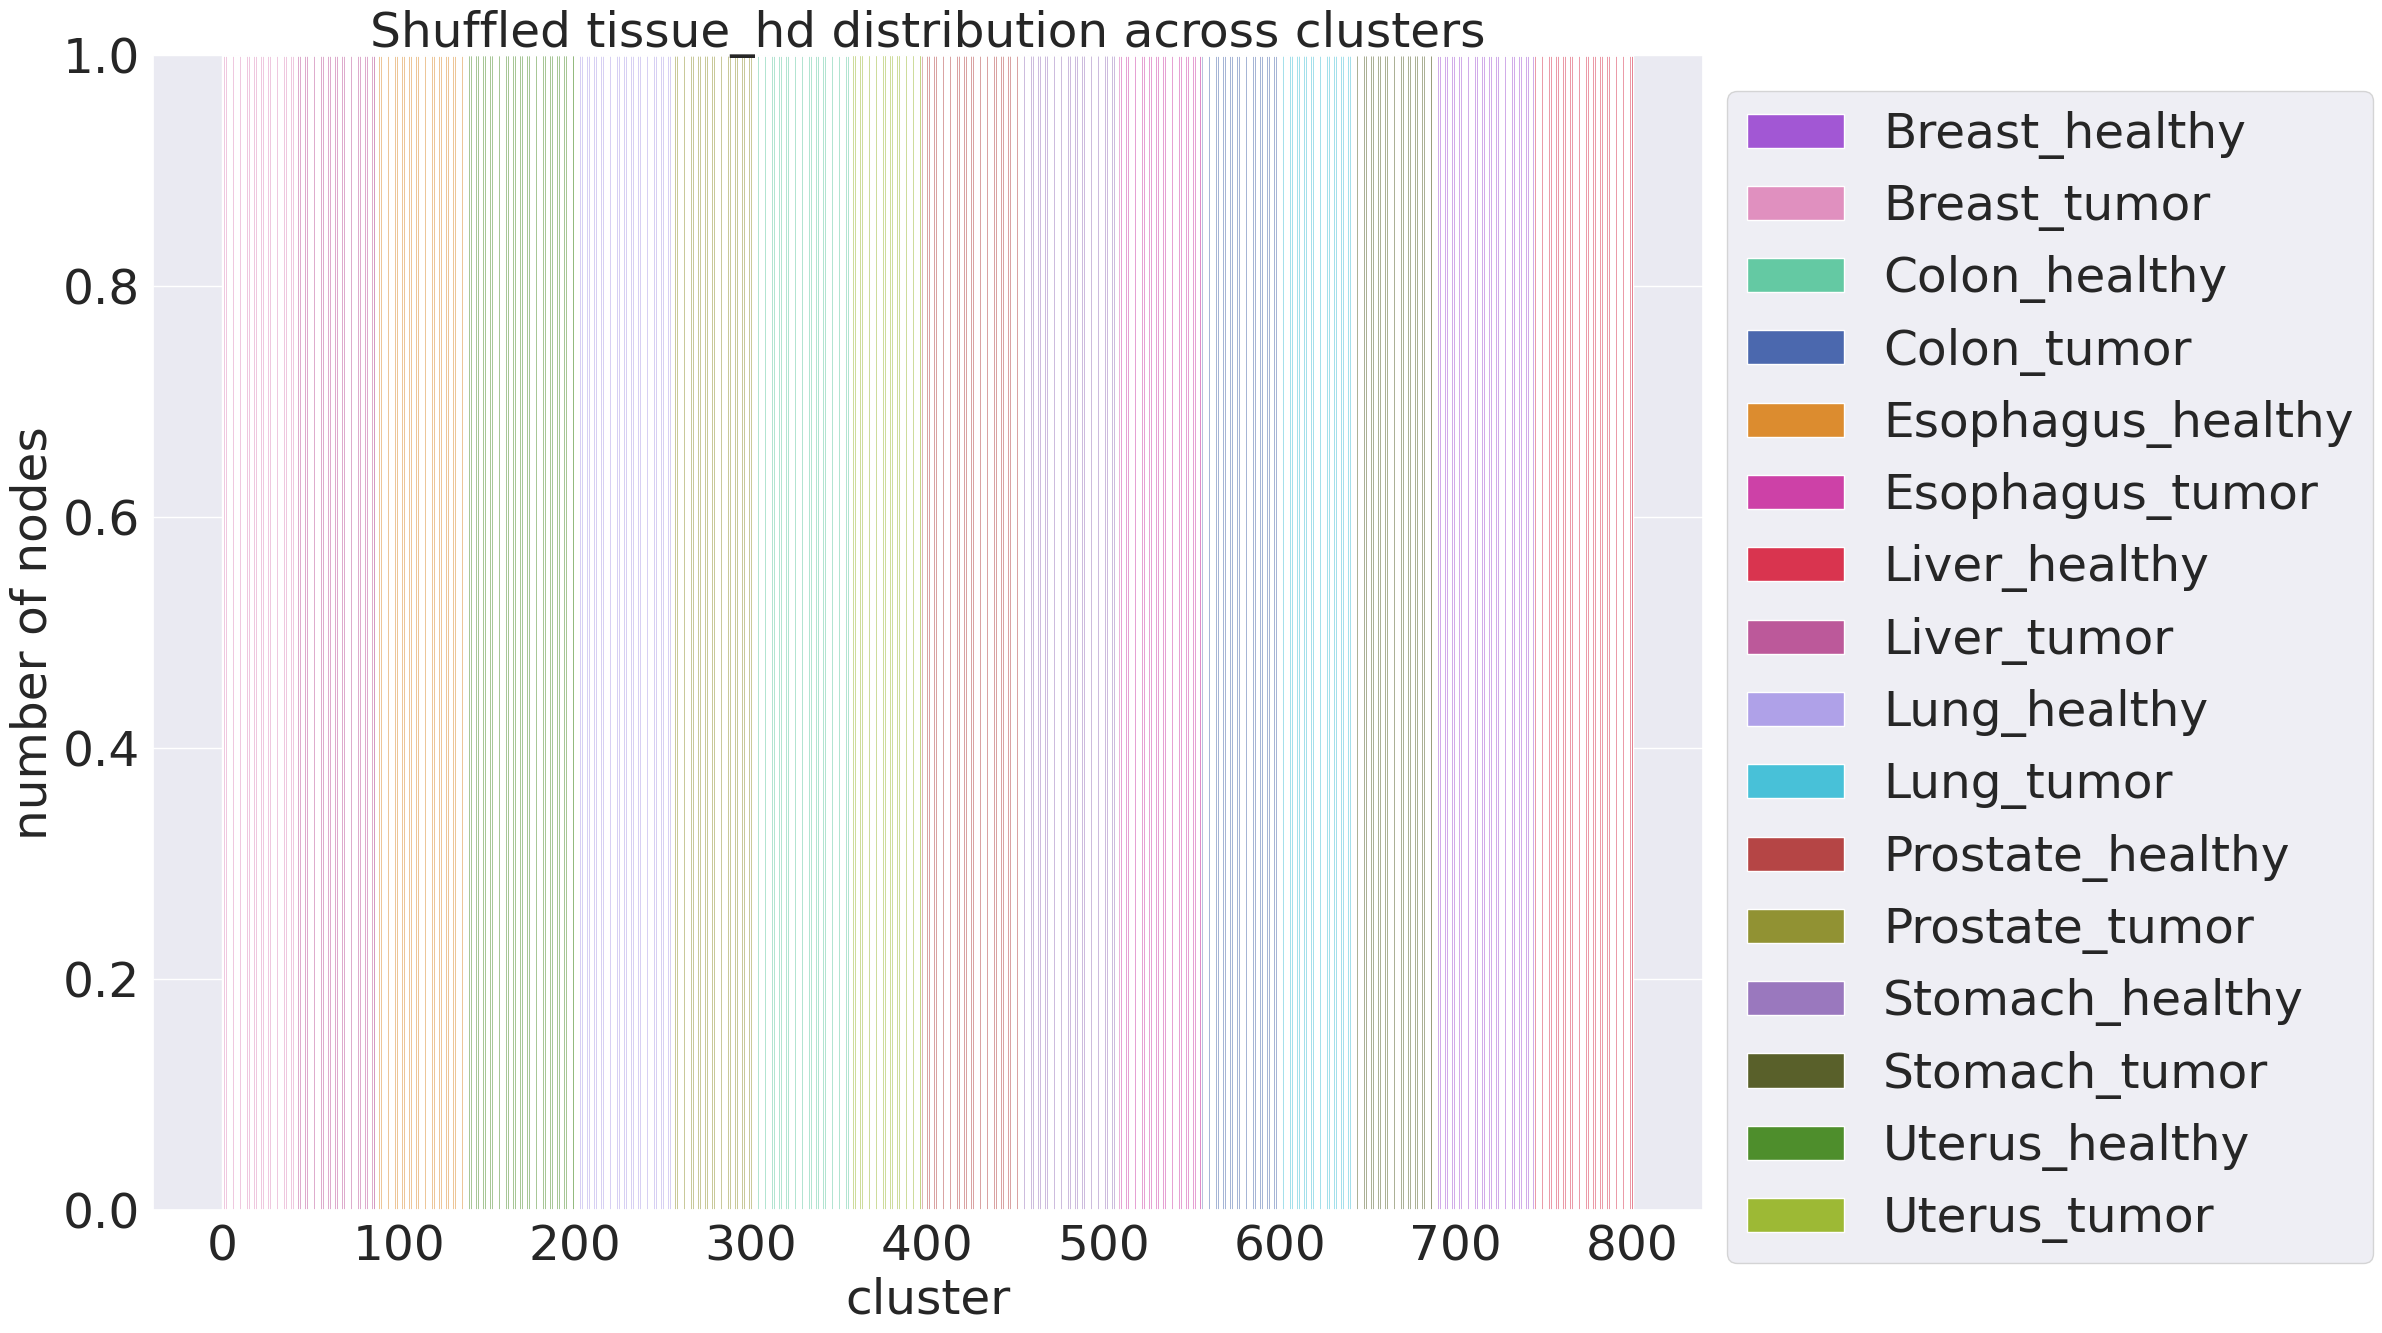

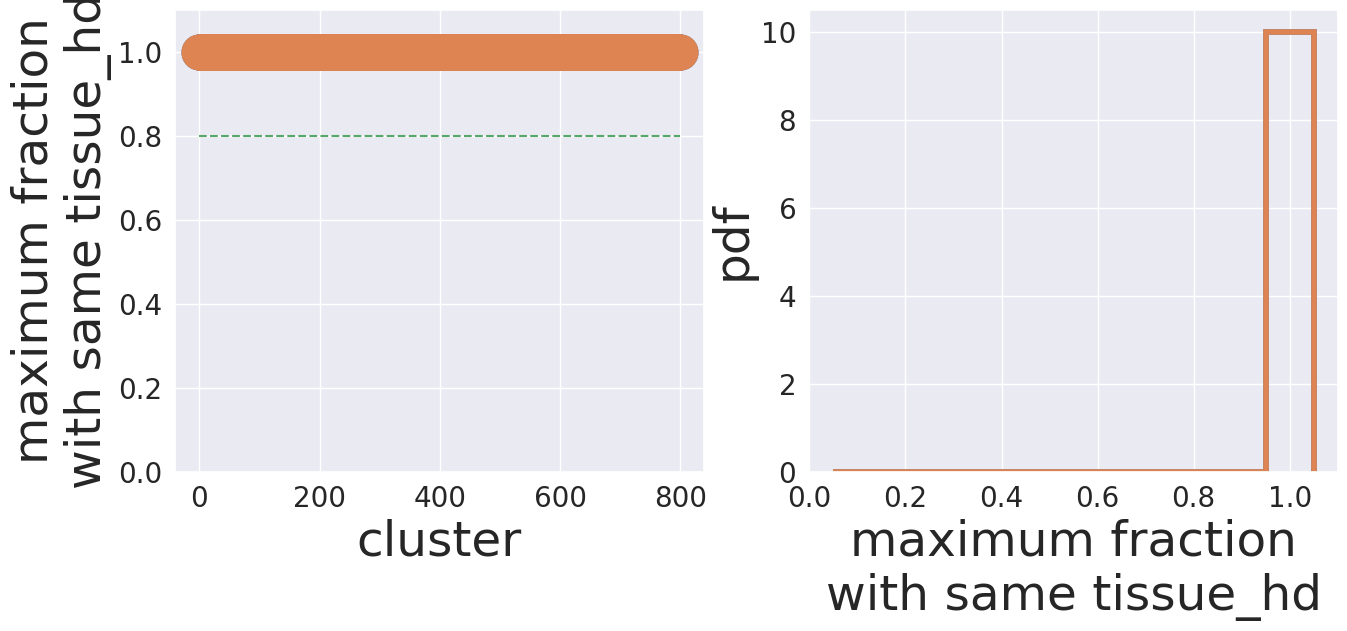

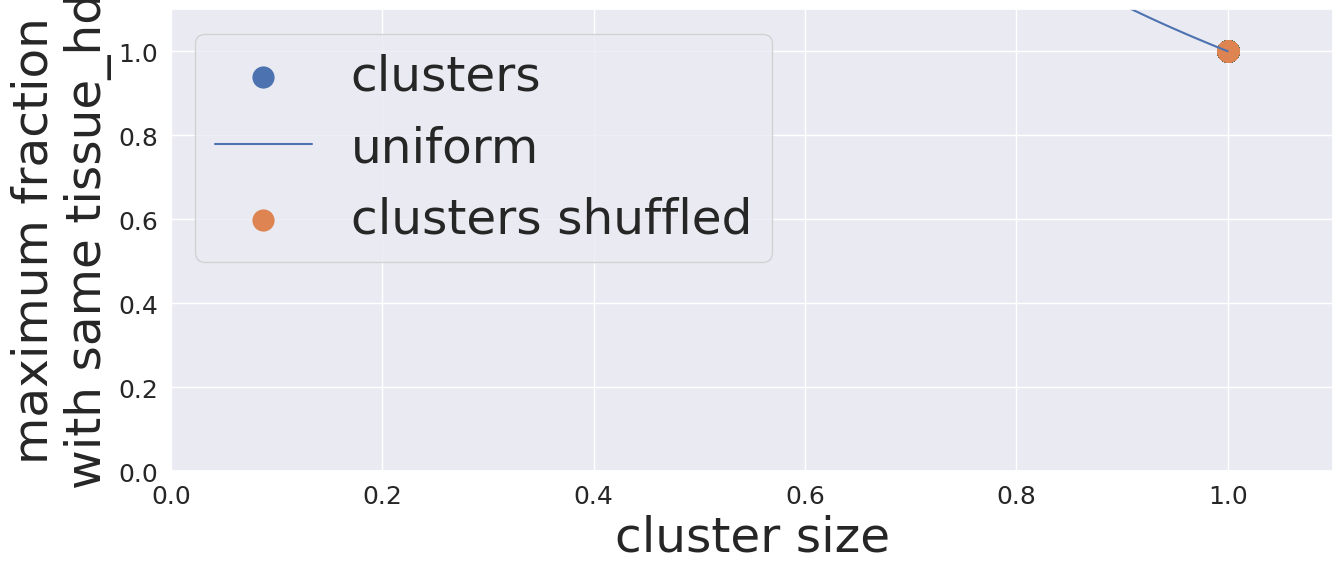

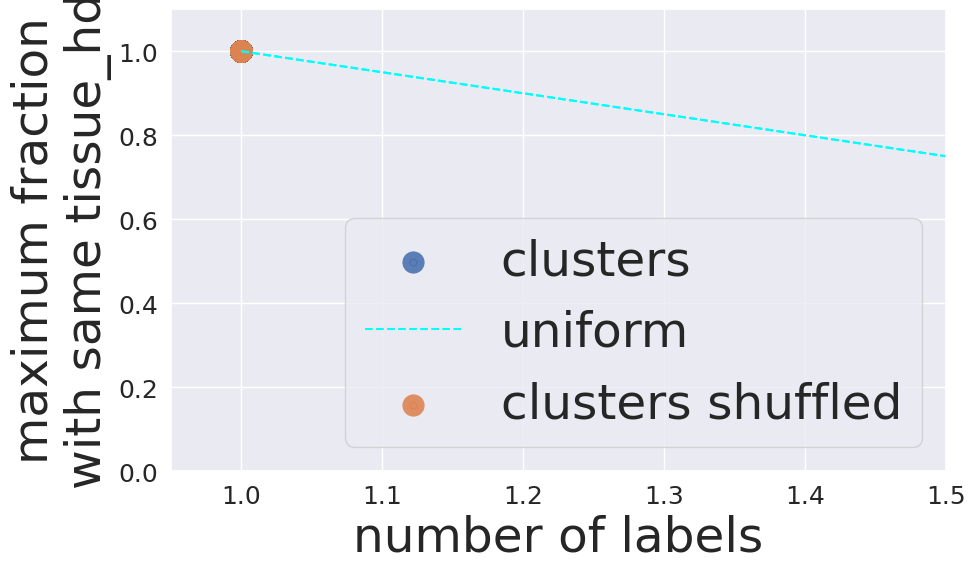

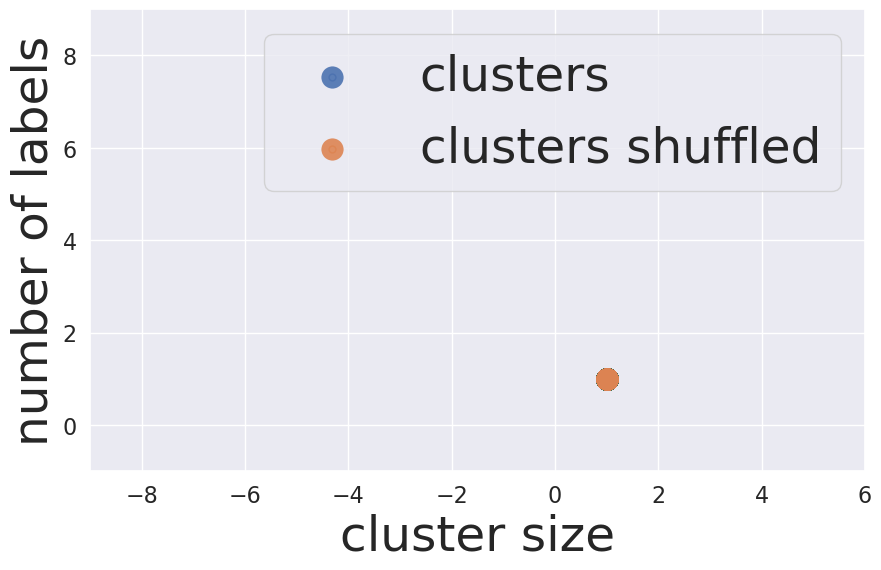

In [6]:
from topicpy.hsbmpy import clusteranalysis
clusteranalysis(working_dir,["tissue_hd"])

# Scores

In [44]:
from topicpy.hsbmpy import get_scores,get_scores_shuffled
scores = {}
labels = ["primary_site", "tissue_hd"]
df_files = pd.read_csv("files.dat", index_col=0)
scores['tissues'] = get_scores(working_dir, labels, df_files=df_files, algorithm = "topsbm", verbose=False)[labels[0]]
scores['status'] = get_scores(working_dir, labels, df_files=df_files, algorithm = "topsbm", verbose=False)[labels[1]]
scores['shuffle'] = get_scores_shuffled(working_dir, df_files, label=labels[0], algorithm='topsbm')

In [45]:
from topicpy.hsbmpy import normalise_score
if "mixed" in scores.keys():
    scores.pop("mixed")
norm_scores = scores.copy()
normalise_score(norm_scores, base_algorithm="shuffle")

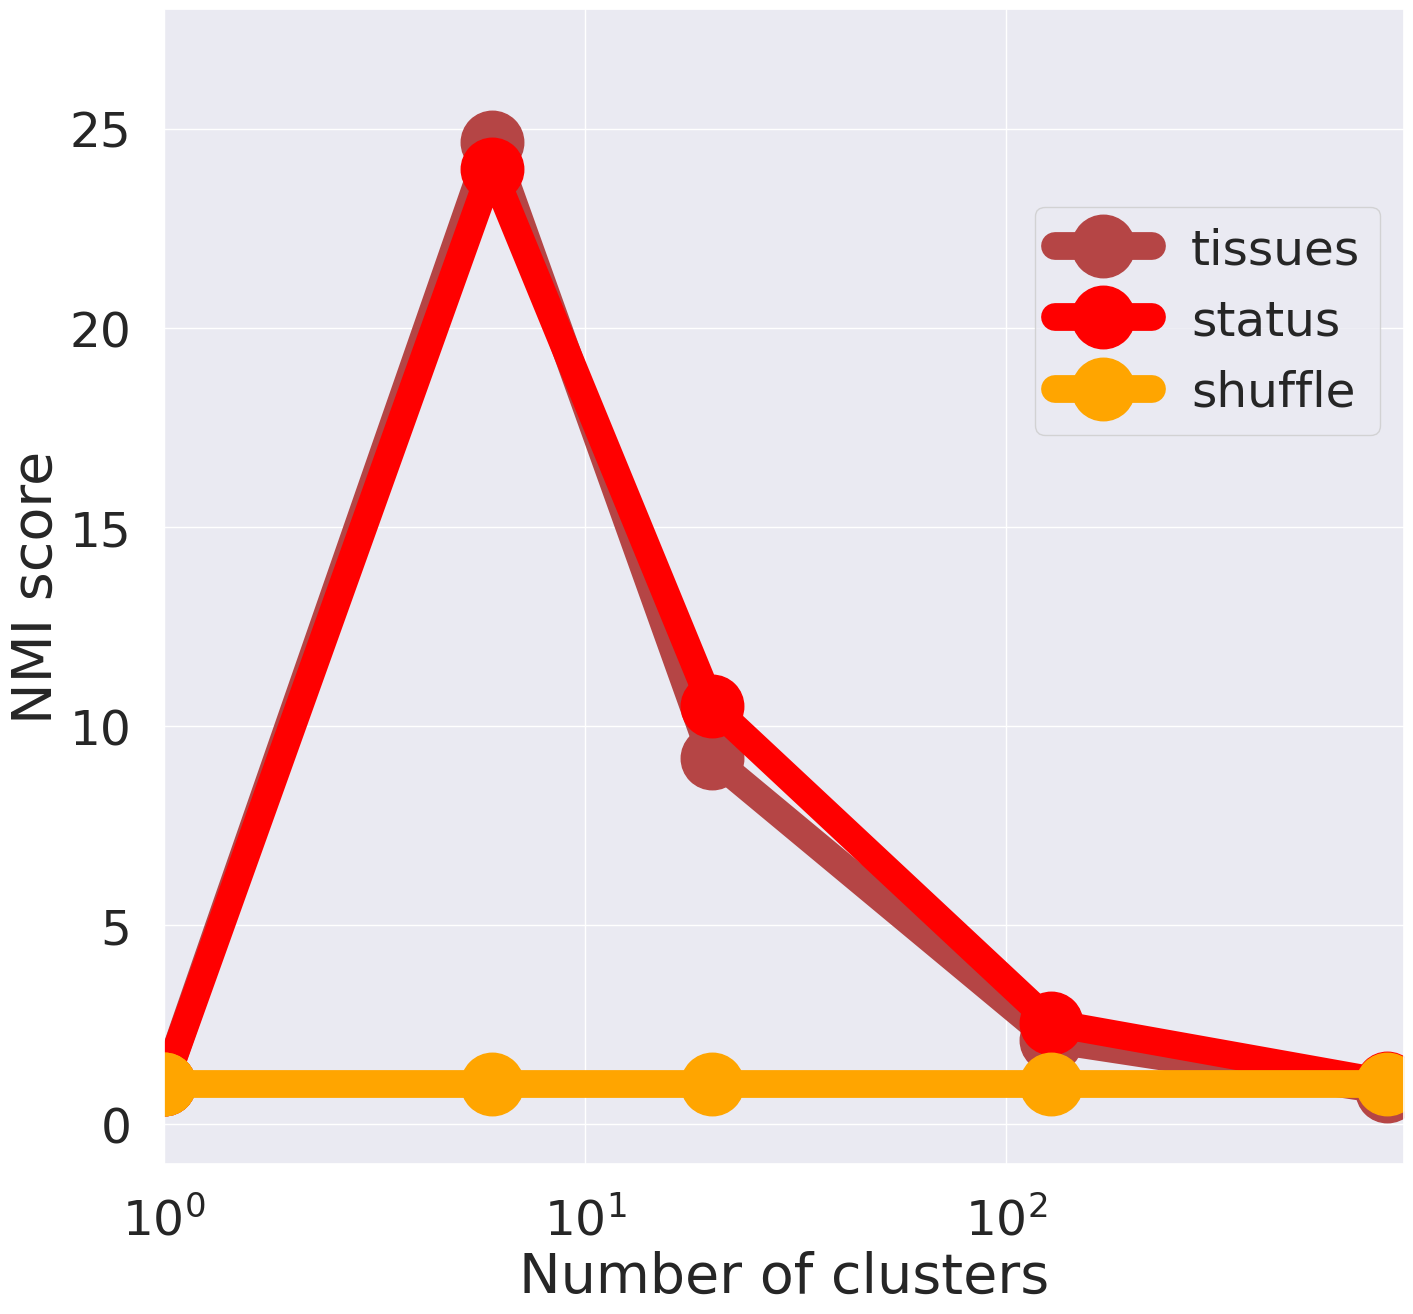

In [49]:
from topicpy.hsbmpy import add_score_lines, customize_metric_plot
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax, scores, V="norm_V", labels=scores.keys())
#ax.set_xscale('linear')
#plt.xlim(1,2000)
plt.ylim(-1,28)
plt.show()
fig.savefig("%s/metric_scores_%s.pdf"%(working_dir,"tissue_hd"))